<a id="nlp-trials-using-gensim-for-selecting-number-of-topics"></a>

# [NLP Trials using Gensim for selecting number of topics](#nlp-trials-using-gensim-for-selecting-number-of-topics)

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from collections import Counter
from glob import glob
from io import StringIO
from operator import itemgetter

import altair as alt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from azure.storage.blob import BlobServiceClient
from gensim.corpora.dictionary import Dictionary
from joblib import dump, load
from scipy import stats
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%aimport src.data_helpers
from src.data_helpers import load_data

%aimport src.extraction_helpers
from src.extraction_helpers import get_top_n_most_freq_words

%aimport src.hybrid_helpers
from src.hybrid_helpers import get_nmf_coherence_scores

%aimport src.processing_helpers
from src.processing_helpers import (
    do_tokenize,
    expand_contractions,
    expand_match,
    process_text,
)

%aimport src.visualization_helpers
from src.visualization_helpers import (
    altair_boxplot_sorted,
    altair_datetime_heatmap,
    altair_plot_bar_chart_value_counts,
    altair_plot_bar_chart_value_counts_sortable,
    altair_plot_grid_by_column,
    altair_plot_horiz_bar_chart,
    altair_plot_line_chart,
    altair_plot_histogram_grid_by_column,
    altair_plot_triangular_heatmap,
    boxplot_sorted,
    plot_histogram,
)

<a id="toc"></a>

## [Table of Contents](#table-of-contents)
0. [About](#about)
1. [User Inputs](#user-inputs)
2. [Load Data, Concatenate and Filter](#load-data-concatenate-and-filter)
3. 3. [Topic modeling using Gensim NMF with Topic coherence to find best number of topics](#topic-modeling-using-gensim-nmf-with-topic-coherence-to-find-best-number-of-topics)
   - 3.1. [Pre-Processing for Gensim NMF, Tokenization, Stemming, etc.](#pre-processing-for-gensim-nmf,-tokenization,-stemming-etc.)
   - 3.2. [Use Gensim to perform Bag-of-Words transformation](#use-gensim-to-perform-bag-of-words-transformation)
   - 3.3. [Use Gensim NMF and Topic coherence to find number of topics](#use-gensim-nmf-and-topic-coherence-to-find-number-of-topics)
4. [Topic modeling using TFIDF vectorization and NMF](#topic-modeling-using-tfidf-vectorization-and-nmf)
   - 4.1. [Pre-processing for NMF](#pre-processing-for-nmf)
   - 4.2. [NMF](#nmf)
   - 4.3. [Merging with the original data](#merging-with-the-source-data)
   - 4.4. [Coherence Residual by Topic](#coherence-residual-by-topic)
   - 4.5. [Assign Names to 15 Topics](#assign-names-to-15-topics)
5. [Exploring topics combined with source data and 15 topics](#exploring-topics-combined-with-source-data-and-15-topics)
6. [Exploring articles with 35 topics](#exploring-articles-with-35-topics)
   - 6.1. [Coherence Residual by Topic](#coherence-residual-by-topic)
   - 6.2. [Assign Names to 35 Topics](#assign-names-to-35-topics)
7. [Exploring topics combined with source data and 35 topics](#exploring-topics-combined-with-source-data-and-35-topics) 
   - 7.1. [Years Featured](#years-featured)
   - 7.2. [Most Popular Topic by Year](#most-popular-topic-by-year)
   - 7.3. [All Topics by Year](#all-topics-by-year)
   - 7.4. [Examining Infrequently Occurring Topics](#examining-infrequently-occurring-topics)
   - 7.5. [Terms by Topic](#terms-by-topic)
     - 7.5.1. [Philae](#philae)
     - 7.5.2. [SpaceX](#spacex)
     - 7.5.3. [Discovery of Gravitational Waves](#discovery-of-gravitational-waves)
     - 7.5.4. [MIR Space Spation Funding](#mir-space-station-funding)
     - 7.5.5. [Reporting on Pluto](#reporting-on-pluto)
   - 7.6. [Training Summary Statistics](#training-summary-statistics)
9. [Conclusion](#conclusion)
10. [Looking Forward](#looking-forward)

<a id="about"></a>

## 0. [About](#about)

In this notebook, we will go through a second experiment with [topic coherence](https://en.wikipedia.org/wiki/Coherence_(linguistics)) approaches using Gensim to find an optimal number of topics from the Guardian's Space news listings data in `data/processed/*_processed.csv`. Following previous work ([1](https://github.com/robsalgado/personal_data_science_projects/blob/master/topic_modeling_nmf/topic_modeling_cnn.ipynb)), this will be done using [`sklearn`](https://en.wikipedia.org/wiki/Scikit-learn)'s [`NMF` model](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization#Text_mining) with [TFIDF vectorization](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), after determining the optimal number of topics using [Gensim](https://en.wikipedia.org/wiki/Gensim)'s topic coherence pipeline to evaluate the topics determined by Gensim's `NMF`.

<a id="user-inputs"></a>

## 1. [User Inputs](#user-inputs)

We'll define below the variables that are to be used throughout the code.

In [5]:
PROJ_ROOT_DIR = os.getcwd()
data_dir = os.path.join(PROJ_ROOT_DIR, "data", "raw")
processed_data_dir = os.path.join(PROJ_ROOT_DIR, "data", "processed")

In [6]:
# General inputs
cloud_data = True

# Topic naming
topic_nums = list(range(10, 45 + 5, 5))
n_top_words = 10

unwanted_guardian_cols = [
    "webTitle",
    "id",
    "sectionId",
    "sectionName",
    "type",
    "isHosted",
    "pillarId",
    "pillarName",
    "page",
    "document_type",
    "apiUrl",
    "publication",
    "year",
    "month",
    "day",
    "dayofweek",
    "dayofyear",
    "weekofyear",
    "quarter",
]

In [7]:
def get_top_words_per_topic(row, n_top_words=5):
    return row.nlargest(n_top_words).index.tolist()


def shaprio_wilk_is_normal(g):
    """
    Use Shapiro Wilk test to check if data is normally distributed
    SOURCE
    ------
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro
    .html
    """
    sw_statistic, p_value = stats.shapiro(g)
    if len(g) > 5000:  # W-stat is more accurate for larger sample sizes
        if sw_statistic < 0.05:
            return False
    if p_value < 0.05:
        return False
    return True


def levene_has_equal_variance(g1, g2):
    """
    Use Levene test to Check homnoscedasticity (equal variance)
    SOURCE
    ------
    https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.
    levene.html
    """
    _, p_value = stats.levene(g1, g2)
    if p_value < 0.05:
        return False
    else:
        return True


def ttest_or_manwhitu(g1, g2):
    """
    Use T-test (if normal and homoskedastic) or Mann Whitney U test to
    calculate test statistic between two groups
    SOURCES
    -------
    1. Mann Whitney U test
       - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.
         mannwhitneyu.html
    2. T-test (without, by default, and with equal variance)
       - use parameter `equal_var` to indicate if variances are equal or not
       - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.
         ttest_ind.html
    """
    if shaprio_wilk_is_normal(g1) and shaprio_wilk_is_normal(g2):
        if levene_has_equal_variance(g1, g2):
            test_type = "T-Test"
            return stats.ttest_ind(g1, g2)
        else:
            test_type = "T-Test with unequal variance"
            return stats.ttest_ind(g1, g2, equal_var=False)
    test_type = "U-Test"
    print(f"Performing {test_type} ...")
    return [stats.mannwhitneyu(g1, g2), test_type]


def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)

    percentile_.__name__ = "percentile_%s" % n
    return percentile_


def add_datepart(df):
    df[["year", "month", "day"]] = df["url"].str.extract(
        r"/(\d{4})/([a-z]{3})/(\d{2})/"
    )
    d = {"jan": 1, "feb": 2, "nov": 11, "dec": 12, "sep": 9, "oct": 10}
    df["month"] = df["month"].map(d).astype(int)
    df["date"] = pd.to_datetime(df[["year", "month", "day"]])
    df["month"] = df["month"].map({v: k.title() for k, v in d.items()})
    df["weekday"] = df["date"].dt.day_name()
    df["week_of_month"] = df["date"].apply(lambda d: (d.day - 1) // 7 + 1)
    return df


def percentage_change(col1, col2):
    return ((col2 - col1) / col1) * 100

In [8]:
# General inputs
az_storage_container_name = "myconedesx7"

# Guardian Filenames
# # Cloud-based files
guardian_inputs = {
    "blobedesz21": "urls",
    "blobedesz19": "text1",
    "blobedesz20": "text2",
}

In [10]:
conn_str = (
    "DefaultEndpointsProtocol=https;"
    f"AccountName={os.getenv('AZURE_STORAGE_ACCOUNT')};"
    f"AccountKey={os.getenv('AZURE_STORAGE_KEY')};"
    f"EndpointSuffix={os.getenv('ENDPOINT_SUFFIX')}"
)
blob_service_client = BlobServiceClient.from_connection_string(conn_str=conn_str)

<a id="load-data-concatenate-and-filter"></a>

## 2. [Load Data, Concatenate and Filter](#load-data-concatenate-and-filter)

We'll start by loading the data and drop the news articles that are 500 characters or shorter in length

In [11]:
%%time
df_guardian = load_data(
    cloud_data,
    data_dir,
    "",
    "",
    guardian_inputs,
    blob_service_client,
    az_storage_container_name,
    unwanted_guardian_cols,
)
df_guardian["year"] = pd.to_datetime(df_guardian["publication_date"]).dt.year
df_guardian["article_chars"] = df_guardian["text"].str.split().str.len()

CPU times: user 599 ms, sys: 256 ms, total: 856 ms
Wall time: 2.97 s


In [12]:
assert pd.to_datetime(df_guardian["publication_date"]).is_monotonic

Next, we will show a bar chart of the number of article characters by year

In [13]:
altair_boxplot_sorted(
    df_guardian[["article_chars", "year"]],
    "year",
    "article_chars",
    "",
    "Article Characters by Year",
    14,
    14,
    16,
    dx=50,
    offset=-5,
    x_tick_label_angle=-45,
    horiz_bar_chart=False,
    axis_range=[0, 8_000],
    fig_size=(700, 300),
)

alt.Chart(...)

Most of the articles are 1,000 characters in length. For those (outliers, circles) that are longer than this, they extend upto approx. 4,000 characters with only a very small number of articles being longer than this.

The number of articles per year is shown below

In [14]:
altair_plot_bar_chart_value_counts(
    df_guardian["year"].value_counts().sort_index().reset_index(),
    "Number of articles by Year",
    "index:N",
    "year:Q",
    labelFontSize=12,
    titleFontSize=12,
    plot_titleFontSize=16,
    dx=30,
    offset=-5,
    x_tick_label_angle=-45,
    horiz_bar_chart=False,
    fig_size=(700, 250),
)

alt.Chart(...)

Prior to 1999, very few **Space** articles were published by the Guardian. There was also a drop from the years 2006 to 2010, likely coinciding to the [Great Recession](https://www.investopedia.com/terms/g/great-recession.asp). Since 2011, article length increased until 2015 and has been dropping since then.

The big events in British space news in 2003-2005 were the launch of and search for the missing Beagle 2 Mars rover. It was found in 2015. See the timeline [here](https://www.itv.com/news/2015-01-16/the-timeline-of-events-surrounding-the-beagle-2). In 2015, there was big news about the search for the ESA mission's Philae lander (as part of the Rosetta mission to the comet 67P). the lander was declared lost in 2016. The mission timeline is available [here](http://www.esa.int/Education/Teach_with_Rosetta/Rosetta_timeline/). These could account for the increased number of the newspaper's online publications during these year.

<a id="topic-modeling-using-gensim-nmf-with-topic-coherence-to-find-best-number-of-topics"></a>

## 3. [Topic modeling using Gensim NMF with Topic coherence to find best number of topics](#topic-modeling-using-gensim-nmf-with-topic-coherence-to-find-best-number-of-topics)

<a id="pre-processing-for-gensim-nmf,-tokenization,-stemming-etc."></a>

### 3.1. [Pre-Processing for Gensim NMF, Tokenization, Stemming, etc.](#pre-processing-for-gensim-nmf,-tokenization,-stemming-etc.)

Now, we'll perform the following processing actions on each news article's text
- [tokenize](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) the text of the article, using the [NLTK package's `TweetTokenizer`](https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.casual)
- clean the text of the articles
  - convert to lowercase
  - remove numbers
  - [expand contractions](https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html) ([code](https://grammar.yourdictionary.com/style-and-usage/using-contractions.html))
  - ([snowball](https://en.wikipedia.org/wiki/Snowball_(programming_language))) [stemming](https://en.wikipedia.org/wiki/Stemming)
  - remove [punctuation](https://docs.python.org/3/library/string.html#string.punctuation)
  - remove [stopwords](https://en.wikipedia.org/wiki/Stop_word)
  - remove any standalone single character
  - remove [whitespaces](https://en.wikipedia.org/wiki/Whitespace_character)

In [15]:
%%time
texts = df_guardian["text"].apply(process_text)

CPU times: user 51.9 s, sys: 53.5 ms, total: 52 s
Wall time: 52 s


The tokenized texts are made up of nearly 67,000 unique words, as shown below

In [16]:
%%time
len(set(pd.DataFrame(texts.tolist()).to_numpy().flatten()))

CPU times: user 1.98 s, sys: 96.4 ms, total: 2.08 s
Wall time: 2.06 s


66842

After processing them, the most common tokens (expressed as a percentage) by year are shown below, for a subset of years from the data. This is done using a helper function that returns an integer representing the number of times a given token appears in the article's text. The helper function is shown below and is followed by the code to use it for getting the most common tokens by year

In [17]:
with open("src/extraction_helpers.py", "r") as f:
    for k, line in enumerate(f):
        if k >= 4:
            print(str(k) + " " + line.strip("\n"))

4 import pandas as pd
5 from sklearn.feature_extraction.text import CountVectorizer
6 
7 
8 def get_top_n_most_freq_words(df, n=10, return_pct=False):
9     # https://stackoverflow.com/a/56712583/4057186
10     cv = CountVectorizer()
11     cv_fit = cv.fit_transform(df["text"].str.join(","))
12     word_list = cv.get_feature_names()
13     count_list = cv_fit.toarray().sum(axis=0)
14     df_top_words = pd.DataFrame.from_dict(
15         dict(zip(word_list, count_list)), orient="index"
16     )
17     if return_pct:
18         df_top_words[0] = (df_top_words[0] / df_top_words[0].sum()) * 100
19     df_top_words = df_top_words.nlargest(n, 0)
20     return df_top_words.to_dict()


In [18]:
%%time
ywc = [
    1957,
    1986,
    2000,
    2001,
    2003,
    2004,
    2007,
    2011,
    2012,
    2014,
    2015,
    2016,
    2017,
    2018,
    2019,
]
top_n_words = 10

# Get most popular token by year
tokens_by_year = pd.concat([df_guardian["year"], texts], axis=1)
df_mpy = tokens_by_year.groupby("year").apply(lambda x: get_top_n_most_freq_words(x, top_n_words, True)).to_frame()

# Sanity check for first year (1957)
assert pd.DataFrame(
    get_top_n_most_freq_words(
        tokens_by_year[tokens_by_year["year"] == 1957], top_n_words, True
    )
).equals(pd.DataFrame(df_mpy.loc[1957].iloc[0]))

# Put into DataFrame for plotting
df_ywcs = []
for y in ywc:
    df_ywc = (
        pd.DataFrame.from_dict(df_mpy.loc[y][0], orient="index")
        .T.rename(columns={0: "count"})
        .rename_axis("word")
        .assign(year=y)
        .reset_index()
    )
    df_ywcs.append(df_ywc)
df_ywc = pd.concat(df_ywcs)
# display(df_ywc)
altair_plot_grid_by_column(
    df_ywc, xvar="count", yvar="word", col2grid="year", fig_size=(100, 200)
)

CPU times: user 1.15 s, sys: 20 ms, total: 1.17 s
Wall time: 1.17 s


alt.HConcatChart(...)

The token `space` is the universally the most commonly occurring one in Guardian **Space** articles from the Science section. Though, it wasn't used much in the early days of publishing in this section of the newspaper.

In 1986, the space shuttle Challenger's explosion was mentioned in a lot of articles. However, the Columbia shuttle crash in 2003 did not get mentioned by name. Even the token `shuttle` wasn't as frequent in 2003 as it was after the Challenger shuttle crash in 1986. Other topics such as the launch of the twin Mars rovers, later [during the same year](https://www.nasa.gov/directorates/somd/reports/2003/table1.html), shared the spotlight with the shuttle crash and were mentioned in a lot of news articles in this section.

<a id="use-gensim-to-perform-bag-of-words-transformation"></a>

### 3.2. [Use Gensim to perform Bag-of-Words transformation](#use-gensim-to-perform-bag-of-words-transformation)

Now, we'll create a corpus comprising an assigned ID and corresponding count frequency of words from the tokens created above. This is Gensim's document conversion into a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) format. It returns a list of tuples comprising token identifier and the corresponding count (frequency).

In [19]:
%%time
# Create Dictionary
dictionary = Dictionary(texts)

# Remove extreme values
dictionary.filter_extremes(
    no_below=3,  # default = 5
    no_above=0.85,  # default is 0.5
    keep_n=5_000,  # default is 100_000
)

# Term Document Frequency for corpus
corpus = [dictionary.doc2bow(text) for text in texts]

CPU times: user 1.55 s, sys: 12.1 ms, total: 1.56 s
Wall time: 1.56 s


<a id="use-gensim-nmf-and-topic-coherence-to-find-number-of-topics"></a>

### 3.3. [Use Gensim NMF and Topic coherence to find number of topics](#use-gensim-nmf-and-topic-coherence-to-find-number-of-topics)

Next, we'll compute the coherence score for our specified list of number of topics to be compared. A [topic coherence `Class`](https://radimrehurek.com/gensim/models/coherencemodel.html), from the [Gensim library](https://pypi.org/project/gensim/), is used to evaluate topics found using an [NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) model. A helper function is used for this and is shown below

In [20]:
with open("src/hybrid_helpers.py", "r") as f:
    for k, line in enumerate(f):
        if k >= 4:
            print(str(k) + " " + line.strip("\n"))

4 from gensim.models.coherencemodel import CoherenceModel
5 from gensim.models.nmf import Nmf
6 
7 
8 def get_nmf_coherence_scores(corpus, texts, num_topics, dictionary):
9     nmf = Nmf(
10         corpus=corpus,
11         num_topics=num_topics,
12         id2word=dictionary,
13         chunksize=2000,
14         passes=5,
15         kappa=0.1,
16         minimum_probability=0.01,
17         w_max_iter=300,
18         w_stop_condition=0.0001,
19         h_max_iter=100,
20         h_stop_condition=0.001,
21         eval_every=10,
22         normalize=True,
23         random_state=42,
24     )
25     # Run the coherence model to get the score
26     cm = CoherenceModel(
27         model=nmf,
28         texts=texts,  # needed for coherence="c_v"
29         corpus=None,  # not needed for coherence="c_v"
30         dictionary=dictionary,
31         coherence="c_v",
32         topn=20,
33         processes=-1,
34     )
35     return round(cm.get_coherence(), 5)


In [21]:
!pygmentize src/hybrid_helpers.py

#!/usr/bin/python3
# -*- coding: utf-8 -*-


from gensim.models.coherencemodel import CoherenceModel
from gensim.models.nmf import Nmf


def get_nmf_coherence_scores(corpus, texts, num_topics, dictionary):
    nmf = Nmf(
        corpus=corpus,
        num_topics=num_topics,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=0.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42,
    )
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,  # needed for coherence="c_v"
        corpus=None,  # not needed for coherence="c_v"
        dictionary=dictionary,
        coherence="c_v",
        topn=20,
        processes=-1,
    )
    return round(cm.get_coherence(), 5)


The coherence model's reported coherence score will be computed as the number of topics used to train an NMF model is varied. The higher the coherence for the selected number of topics the better. This way, we can select the number of topics in an NMF model that returns the highest coherence score.

In [22]:
%%time
# For each specified number of topics, run NMF and calculate topic coherence
topic_coherence_scores = [
    get_nmf_coherence_scores(corpus, texts, n, dictionary)
    for n in topic_nums
]

# Extract coherence score for each number of topics tried
df_coherence_scores = (
    pd.DataFrame.from_dict(dict(zip(topic_nums, topic_coherence_scores)), orient="index")
    .reset_index()
    .rename(columns={"index": "num_topics", 0: "coherence"})
    .set_index("num_topics")
)

CPU times: user 1min 40s, sys: 2min 49s, total: 4min 29s
Wall time: 2min 9s


We'll now plot the coherence scores by the number of topics

In [23]:
altair_plot_line_chart(
    df_coherence_scores.reset_index(),
    "num_topics",
    "coherence",
    "Topic Coherence versus Number of Topics",
    labelFontSize=12,
    titleFontSize=14,
    plot_titleFontSize=16,
    linewidth=3,
    dx=35,
    offset=-5,
    x_tick_label_angle=0,
    marker_size=150,
    y_axis_range=[0.44, 0.5],
    fig_size=(700, 250),
)

alt.Chart(...)

Over a range of 15 to 45 topics, we can see that there isn't much of a change in the coherence score and there is little evidence of a trend. For the above choices of pre-processing and coherence-modeling, the choice of 35 topics gives the maximum coherence score but the difference between scores for 15 and 35 topics is less than 10%. That's quite a large range of topics but only a small improvement.

For now, we'll move forward with 15 topics

In [24]:
n_topics_wanted = 15

<a id="topic-modeling-using-tfidf-vectorization-and-nmf"></a>

## 4. [Topic modeling using TFIDF vectorization and NMF](#topic-modeling-using-tfidf-vectorization-and-nmf)

We'll now train an ML model with the best number of topics.

**TFIDF Overview**

First, we'll convert the documents (news articles) into vector representations that will allow numeric ML techniques to be applied. This is [feature extraction or word vectorization](https://en.wikipedia.org/wiki/Word_embedding), since it maps single or multiple words from a vocabulary of words to a corresponding real-numbered vector.

Here, we'll use a [TFIDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) vectorizer as a preliminary step before the NMF model, as opposed to NLTK's `TweetTokenizer` which was used when selecting the optimal number of topics. So, for this part, `scikit-learn` will be used instead of Gensim.

**NMF Overview**

The ML model will be [Non-Negative Matrix Factorization, or NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization). At a high level, NMF approximates a given matrix using a [low-rank matrix approximation](https://en.wikipedia.org/wiki/Low-rank_approximation). It decomposes an input matrix into two lower dimensionality matrices (a weighted sum of some number of [basis vectors](https://en.wikipedia.org/wiki/Basis_(linear_algebra)))
- a matrix of basis vectors
- a matrix of associated basis weights

The matrix product of these two is an approximation (but not a perfect match) to the original matrix. How good is this approximation? One approach to estimating the goodness of this approximation is by computing the [Frobenius norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm) between the original and approximated data.

For NLP tasks, NMF takes a [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix) of TFIDF features (output of the vectorizer) and creates an approximate representation of weighted combinations of the document terms that go together across the corpus. The combinations are of basis documents (topics) and their weights indicate how to add the contributions of each topic to approximately re-assemble an orginal document. In other words, these topics represent sets of terms that occur simultaneously in different documents.

<a id="pre-processing-for-nmf"></a>

### 4.1. [Pre-processing for NMF](#pre-processing-for-nmf)

First, a two-step pipeline, of TFIDF vectorization (convert processed text to numerical vectors) followed by NMF, is instantiated.

The TFIDF vectorization hyper-parameters are set as follows (and can be tuned if necessary)
- uni- and bi-grams will be extracted (`ngram_range = (1,2)`)
- pre-processing is not done, since the processed tokens are being used
- text is already converted to lowercase before tokenization, so nothing new will be done here
- of the nearly 67,000 unique words in the corpus, use only the top `max_features = 5000` terms, by term frequency, when building vectors
  - the default is to use all the terms
  - this level of feature reduction can be adjusted by varying the `max_features` hyper-parameter
- the default token pattern is used
  - tokens are comprised of 2 or more alphanumeric characters (removes any standalone single character)
    - this won't be done here since the processed tokens are already filtered
- instead, `min_df` and `max_df` is used to eliminate words based on terms by frequency across the text corpus (collection of documents).i.e. ignore any terms that are found in
    - more than 85% (`max_df = 0.85`)
    - less than three (`min_df = 3`)
    
  of the processed texts in the corpus
- no stopwords are used
  - these were aleady removed earlier, so this does not need to be done here

In [25]:
vectorizer = TfidfVectorizer(
    tokenizer=None,  # default is None
    stop_words=None,  # default is None
    lowercase=True,  # default is True
    ngram_range=(1, 2),  # default is (1, 2)
    max_df=0.85,  # default is 1.0
    min_df=3,  # default is 1
    max_features=5000,  # default is None
    preprocessor=" ".join,  # default is None
    binary=False,  # default is False
    strip_accents=None,  # default is None
    # token_pattern='(?u)\\b\\w\\w+\\b',  # default is '(?u)\\b\\w\\w+\\b'
)

Next, the NMF step is defined, again with hyper-parameter choices that can be tuned later as required

In [26]:
sk_nmf = NMF(
    n_components=n_topics_wanted,
    solver="cd",  # default is "cd"
    init="nndsvd",  # default is None, "nnsvd" = Nonnegative Double Singular Value Decomposition
    max_iter=500,  # default is 200
    l1_ratio=0.0,  # default is 0.0
    alpha=0.0,  # default is 0.0
    tol=0.0001,  # default is 0.0001
    random_state=42,
)
pipe = Pipeline([("vectorizer", vectorizer), ("nmf", sk_nmf)])

**Note**
1. When randomly initialized, NMF results are not deterministic. This stability can be improved if [NMF is initialized using SVD](https://arxiv.org/abs/1702.07186) and so this has been done here.

<a id="nmf"></a>

### 4.2. [NMF](#nmf)

The pipeline is now trained on the data, giving the document-term matrix `W`

In [27]:
%%time
doc_topic = pipe.fit_transform(texts)

CPU times: user 10 s, sys: 4.89 s, total: 14.9 s
Wall time: 8.63 s


First, we'll show the Document-Term Matrix produced by TFIDF vectorization.

In [28]:
%%time
display(pd.DataFrame(pipe.named_steps["vectorizer"].transform(texts).toarray()))

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.000000,0.055872,0.0,0.0,0.085680,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.043517,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.036915,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4143,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4144,0.000000,0.0,0.016954,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.058467,0.069032,0.0,0.0,0.0,0.0,0.028448,0.0,0.0
4145,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4146,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


CPU times: user 1.65 s, sys: 676 ms, total: 2.33 s
Wall time: 1.57 s


This is the TFIDF-weighted frequency of terms across the corpus. So, each row corresponds to a single document and the each column corresponds to a single term. This is the matrix of TFIDF features.

The extracted topics and their top ten most important terms (using basis weights, from the NMF transformation) are shown below (these are the sets of corpus-wide coexisting terms mentioned [earlier](#topic-modeling-using-tfidf-vectorization-and-nmf) and they come from the factorization matrix `H`, where rows represent topics and columns represent the input data features)

In [29]:
# Factorization matrix, of weights
H = pipe.named_steps["nmf"].components_
topic_words = pd.DataFrame(
    H,
    index=[str(k) for k in range(n_topics_wanted)],
    columns=pipe.named_steps["vectorizer"].get_feature_names(),
)
# display(topic_words)

# Get row-wise (topic-wise) top 10 weights
topic_df = (
    pd.DataFrame(
        topic_words.apply(
            lambda x: get_top_words_per_topic(x, n_top_words), axis=1
        ).tolist(),
        index=topic_words.index,
    )
    .reset_index()
    .rename(columns={"index": "topic"})
    # .assign(topic_num=range(1, n_topics_wanted + 1))
    .assign(topic_num=range(n_topics_wanted))
)
# Sanity check on first row
assert (
    topic_words.iloc[0].nlargest(n_top_words).index.tolist()
    == topic_df.iloc[0, 1:-1].tolist()
)
for k, v in topic_df.iterrows():
    print(k, ",".join(v[1:-1]))
# display(topic_df)

0 brain,peopl,human,use,thing,time,work,cell,just,think
1 shuttl,nasa,columbia,astronaut,discoveri,launch,space shuttl,mission,flight,atlanti
2 mar,beagl,martian,mission,rover,lander,life,planet,land,nasa
3 planet,star,earth,pluto,solar,sun,kepler,orbit,life,astronom
4 comet,rosetta,phila,lander,sun,dust,solar,mission,surfac,probe
5 star,telescop,galaxi,hubbl,astronom,light,univers,imag,dark,space telescop
6 moon,lunar,apollo,armstrong,astronaut,mission,nasa,land,man,china
7 rocket,spacex,compani,flight,musk,launch,falcon,virgin,land,privat
8 asteroid,earth,impact,object,rock,meteorit,hit,collis,near earth,near
9 station,space station,mir,russian,astronaut,iss,crew,cosmonaut,intern space,peak
10 cassini,saturn,titan,huygen,ring,moon,water,ice,ocean,probe
11 scienc,research,uk,climat,govern,fund,public,scientif,scientist,technolog
12 particl,higg,matter,lhc,dark matter,energi,dark,physic,boson,cern
13 black hole,hole,black,gravit wave,wave,gravit,hawk,univers,theori,einstein
14 satellit

<a id="merging-with-the-source-data"></a>

### 4.3. [Merging with the original data](#merging-with-the-source-data)

Next, we'll start combining the original news article data with the NMF model output (document-topic matrix `W`) which is shown below

In [30]:
display(pd.DataFrame(doc_topic))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.013298,0.000000,0.000000,0.001537,0.000000,0.005281,0.000000,0.038760,0.000000,0.027608,0.000000,0.000000,0.012006,0.001935,0.210091
1,0.005722,0.032159,0.000000,0.005051,0.000333,0.000000,0.010043,0.064665,0.000000,0.035426,0.003016,0.000000,0.000000,0.000185,0.023636
2,0.009477,0.032668,0.000000,0.000000,0.000000,0.000000,0.063489,0.063008,0.000000,0.037621,0.002992,0.000000,0.000000,0.000000,0.011694
3,0.015237,0.009484,0.005866,0.000000,0.000005,0.000000,0.009575,0.042753,0.000000,0.072537,0.005894,0.005100,0.001906,0.000000,0.020060
4,0.012236,0.011435,0.004269,0.000000,0.010682,0.002841,0.111113,0.013131,0.006401,0.023689,0.000858,0.000000,0.000000,0.000000,0.006073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4143,0.000000,0.000000,0.028938,0.000000,0.005105,0.000000,0.100402,0.034895,0.000000,0.000000,0.000000,0.018488,0.000000,0.000000,0.000000
4144,0.012448,0.002114,0.001151,0.000118,0.001537,0.000000,0.041088,0.010734,0.000038,0.048584,0.000000,0.000000,0.000000,0.000364,0.018904
4145,0.044000,0.000000,0.000000,0.007968,0.010605,0.061509,0.001801,0.000000,0.000000,0.053994,0.004988,0.000000,0.000000,0.001182,0.000000
4146,0.000576,0.000000,0.000000,0.001584,0.000000,0.002673,0.000000,0.173735,0.000000,0.000000,0.000000,0.023222,0.000000,0.000000,0.000000


The document-topic matrix (`W`) is the transformed data produced by NMF. Here, each row is a unique document vector in the topic space - here, there are 15 elements per vector since 15 topics were used.

Each element of a single such vector is NMF's learned weight of each of the specified number of topics - 15 topics, so 15 columns. This weight is translated into the importance of that topic. Since we have a single vector for each document, we have the importance of each topic for each document.

There are two things we could do with this document-topic matrix
- the topic with the highest importance (weight) is the topic that most strongly reconstructs the combination of terms for a particular document
  - we'll be doing this here
- if we were to add up all the contributions from the different topics then we could reassemble the combination of terms for a particular document in the corpus

First, the most popular topic for each article (highest topic weight) is found by taking the row-wise maximum of the document-topic matrix.

In [31]:
# df_temp = pd.DataFrame({"topic_num": doc_topic.argmax(axis=1)})
df_temp = (
    pd.DataFrame(doc_topic)
    .idxmax(axis=1)
    .rename("topic_num")
    .to_frame()
    .assign(url=df_guardian["url"].tolist())
    # .assign(publication_date=df_guardian["publication_date"].tolist())
)
assert df_temp["url"].tolist() == df_guardian["url"].tolist()
print(f"Number of rows = {df_temp.shape[0]}")
display(df_temp.head())

Number of rows = 4148


,topic_num,url
0,14,https://www.theguardian.com/science/1957/nov/0...
1,7,https://www.theguardian.com/science/1962/feb/2...
2,6,https://www.theguardian.com/science/1967/jan/2...
3,9,https://www.theguardian.com/science/1967/apr/2...
4,6,https://www.theguardian.com/science/1969/jul/2...


In [32]:
print(df_temp["topic_num"].min(), df_temp["topic_num"].max())

0 14


This gives the (most popular) topic number for each document - the topic numbers start at 0 and end at 14.

Earlier, we got the most important terms for each topic. So, now, we'll merge those with this most popular topic, on the topic number column.

Since we ultimately want to merge these results back with the original news article data (including the metadata columns), we'll also append a column of the news article URL
- `LEFT JOIN` is required since the order of `DF` of predicted topics `df_temp` (which in-turn respects the chronological - ascending - order of news article publication dates in the unseen data) should be maintained

In [33]:
merged_topic = df_temp.merge(topic_df, on="topic_num", how="left")
assert merged_topic["url"].tolist() == df_guardian["url"].tolist()
print(f"Number of rows = {merged_topic.shape[0]}")
display(merged_topic.head())

Number of rows = 4148


,topic_num,url,topic,0,1,2,3,4,5,6,7,8,9
0,14,https://www.theguardian.com/science/1957/nov/0...,14,satellit,china,orbit,launch,debri,earth,chines,militari,missil,rocket
1,7,https://www.theguardian.com/science/1962/feb/2...,7,rocket,spacex,compani,flight,musk,launch,falcon,virgin,land,privat
2,6,https://www.theguardian.com/science/1967/jan/2...,6,moon,lunar,apollo,armstrong,astronaut,mission,nasa,land,man,china
3,9,https://www.theguardian.com/science/1967/apr/2...,9,station,space station,mir,russian,astronaut,iss,crew,cosmonaut,intern space,peak
4,6,https://www.theguardian.com/science/1969/jul/2...,6,moon,lunar,apollo,armstrong,astronaut,mission,nasa,land,man,china


We now merge this result with the original data, to get access all the metadata columns, this time on the common `URL` columns which are aligned for both of these data structures
- `LEFT JOIN` is required since the order of `DF` of predicted topics `df_topics` (which in-turn respects the chronological - ascending - order of news article publication dates in the unseen data) should be maintained

In [34]:
df_topics = df_guardian.merge(merged_topic, on=["url"], how="left").astype(
    {"topic_num": int}
)
assert pd.to_datetime(df_topics["publication_date"]).is_monotonic
assert df_topics["url"].tolist() == df_guardian["url"].tolist()
l = df_topics.sample(155)["url"]
r = df_guardian.iloc[l.index]["url"]
assert l.tolist() == r.tolist()
print(f"Number of rows = {df_topics.shape[0]}")
display(df_topics.head())

Number of rows = 4148


,url,text,publication_date,year,article_chars,topic_num,topic,0,1,2,3,4,5,6,7,8,9
0,https://www.theguardian.com/science/1957/nov/0...,The second Russian satellite has demonstrated ...,1957-11-04,1957,1095,14,14,satellit,china,orbit,launch,debri,earth,chines,militari,missil,rocket
1,https://www.theguardian.com/science/1962/feb/2...,"Col. Glenn reported ""hale and hearty""Picked up...",1962-02-21,1962,435,7,7,rocket,spacex,compani,flight,musk,launch,falcon,virgin,land,privat
2,https://www.theguardian.com/science/1967/jan/2...,The entire three-man crew of the Apollo One sp...,1967-01-27,1967,479,6,6,moon,lunar,apollo,armstrong,astronaut,mission,nasa,land,man,china
3,https://www.theguardian.com/science/1967/apr/2...,Russia's celebratory gesture in manned space f...,1967-04-25,1967,764,9,9,station,space station,mir,russian,astronaut,iss,crew,cosmonaut,intern space,peak
4,https://www.theguardian.com/science/1969/jul/2...,Men are on the moon. At 3 39 a.m. this morning...,1969-07-21,1969,1091,6,6,moon,lunar,apollo,armstrong,astronaut,mission,nasa,land,man,china


The NMF factorization matrix is shown below, with scores (matrix product of topics and weights) for all features (terms, in the column names) and for each component (topic, along the rows)
- for brevity, a random selelction of 10 columns (terms) is shown

In [35]:
topic_word = pd.DataFrame(
    pipe.named_steps["nmf"].components_.round(3),
    index=[k for k in range(n_topics_wanted)],
    columns=pipe.named_steps["vectorizer"].get_feature_names(),
)
print(f"Number of rows = {topic_word.shape[0]}")
display(topic_word.sample(10, axis=1))

Number of rows = 15


,popular,futur space,capit,shuttl columbia,lethal,blind,olymp,nearest,creativ,strang
0,0.086,0.000,0.006,0.003,0.013,0.046,0.025,0.008,0.048,0.069
1,0.000,0.021,0.000,0.087,0.006,0.000,0.000,0.000,0.000,0.000
2,0.000,0.004,0.000,0.000,0.003,0.001,0.001,0.006,0.000,0.000
3,0.003,0.003,0.000,0.000,0.000,0.000,0.000,0.047,0.000,0.020
4,0.000,0.000,0.000,0.000,0.003,0.006,0.004,0.003,0.000,0.012
5,0.014,0.000,0.001,0.000,0.000,0.010,0.000,0.022,0.000,0.007
6,0.006,0.012,0.000,0.000,0.000,0.000,0.000,0.020,0.000,0.013
7,0.000,0.006,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.000,0.002,0.000,0.000,0.004,0.004,0.002,0.006,0.000,0.003
9,0.000,0.007,0.001,0.000,0.000,0.000,0.003,0.000,0.000,0.000


From the NMF factorization matrix, we'll get the top 10 terms by weight for each topic

In [36]:
%%time
df_topic_word_factors = (
    topic_word.groupby(topic_word.index)
    .apply(lambda x: x.iloc[0].nlargest(n_top_words))
    .reset_index()
    .rename(columns={"level_0": "topic_num", "level_1": "term", 0: "weight"})
)
display(df_topic_word_factors.head())

,topic_num,term,weight
0,0,brain,0.716
1,0,peopl,0.706
2,0,human,0.534
3,0,use,0.499
4,0,thing,0.480


CPU times: user 20 ms, sys: 5 µs, total: 20 ms
Wall time: 18.8 ms


We'll also get the 10 most common words by topic

In [37]:
%%time
tokens_by_topic = tokens_by_year[["text"]].assign(
    topic_num=df_topics["topic_num"].tolist()
)
df_mpt = (
    tokens_by_topic.groupby("topic_num")
    .apply(lambda x: get_top_n_most_freq_words(x, top_n_words, True))
    .to_frame()
)
df_twcs = []
for t in np.sort(tokens_by_topic["topic_num"].unique()):
    df_twc = (
        pd.DataFrame.from_dict(df_mpt.loc[t][0], orient="index")
        .T.rename(columns={0: "count"})
        .rename_axis("word")
        .assign(topic_num=t)
        .reset_index()
    )
    df_twcs.append(df_twc)
df_twc = pd.concat(df_twcs)
display(df_twc.head())

,word,count,topic_num
0,use,0.510746,0
1,time,0.489295,0
2,year,0.482235,0
3,peopl,0.479520,0
4,work,0.396975,0


CPU times: user 1.03 s, sys: 49.2 ms, total: 1.08 s
Wall time: 1.08 s


**Notes**
1. Each term may be associated with more than a single topic.

<a id="coherence-residual-by-topic"></a>

### 4.4. [Coherence Residual by Topic](#coherence-residual-by-topic)

Here, we'll use the [Frobenius Norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm) to examine how well the topics found represent the news article text - this will be a residual between the modeled and true document-term matrix.

To get the Frobenius norm, from TFIDF, we're interested in
- `A`
  - the TF-IDF normalised document-term matrix
  - comes from the `.transform()` method ([1](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.transform)) of a trained `TfidfVectorizer()` object
    - shape is `len_corpus` (or number of news articles) X `num_most_frequent_words`
    - this is a [sparse matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html), so to get its shape, we'll call the `.to_array()` method ([1](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.toarray.html))

NMF produces two factor matrices as its output and we need both to calculate the Frobenius norm
- `W`
  - Factorization matrix, sometimes called *dictionary*
  - comes from the `.components_` attribute ([1](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF)) of a trained `NMF()` object
    - shape is `num_topics` X `num_most_frequent_words`
    - we've set `num_topics` to 15 and `num_most_frequent_words` is `max_features`, which was set to 5,000
  - W factor contains the document membership weights relative to each of the k topics. Each row corresponds to a single document, and each column correspond to a topic.
- `H`
  - transformed data
  - comes from the `.transform()` method ([1](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF.transform)) of a trained `NMF()` object
    - again, per the `sklearn` docs, shape is `len_corpus` (or number of news articles) X `num_topics`
    - we know we have a corpus with a length of approx. 4,000 and, as above, we've indicated to use 15 topics
  -  H factor contains the term weights relative to each of the k topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

For the current dataset, we'll compute these three matrices

In [38]:
%%time
A = pipe.named_steps["vectorizer"].transform(texts)
W = pipe.named_steps["nmf"].components_
H = pipe.named_steps["nmf"].transform(A)

CPU times: user 1.51 s, sys: 0 ns, total: 1.51 s
Wall time: 1.51 s


We'll now show the shapes of each of the three matrices above

In [39]:
f"A={A.toarray().shape}, W={W.shape}, H={H.shape}"

'A=(4148, 5000), W=(15, 5000), H=(4148, 15)'

We'll now compute the residual (Frobenius norm) for the text (row) of each news article in our dataset. This is the difference between the true text and the NMF approximations

In [40]:
r = np.zeros(A.shape[0])
for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), "fro")
df_topics["resid"] = r
display(df_topics.head())

,url,text,publication_date,year,article_chars,topic_num,topic,0,1,2,3,4,5,6,7,8,9,resid
0,https://www.theguardian.com/science/1957/nov/0...,The second Russian satellite has demonstrated ...,1957-11-04,1957,1095,14,14,satellit,china,orbit,launch,debri,earth,chines,militari,missil,rocket,0.886346
1,https://www.theguardian.com/science/1962/feb/2...,"Col. Glenn reported ""hale and hearty""Picked up...",1962-02-21,1962,435,7,7,rocket,spacex,compani,flight,musk,launch,falcon,virgin,land,privat,0.962175
2,https://www.theguardian.com/science/1967/jan/2...,The entire three-man crew of the Apollo One sp...,1967-01-27,1967,479,6,6,moon,lunar,apollo,armstrong,astronaut,mission,nasa,land,man,china,0.936398
3,https://www.theguardian.com/science/1967/apr/2...,Russia's celebratory gesture in manned space f...,1967-04-25,1967,764,9,9,station,space station,mir,russian,astronaut,iss,crew,cosmonaut,intern space,peak,0.957497
4,https://www.theguardian.com/science/1969/jul/2...,Men are on the moon. At 3 39 a.m. this morning...,1969-07-21,1969,1091,6,6,moon,lunar,apollo,armstrong,astronaut,mission,nasa,land,man,china,0.926765


We'll show a boxplot of these topic residuals

In [41]:
altair_boxplot_sorted(
    df_topics[["topic_num", "resid"]],
    "topic_num",
    "resid",
    "median(resid)",
    "Topic Residual (sorted by median)",
    14,
    14,
    16,
    dx=30,
    offset=-5,
    x_tick_label_angle=0,
    horiz_bar_chart=False,
    axis_range=[0.5, 1],
    fig_size=(450, 250),
)

alt.Chart(...)

This plot summarizes how the texts in each topic actually fit into that topic. A smaller value on the vertical axis (the residual) indicates a better fit between the news articles in this topic found by the NMF model. Outliers are shown by circles. The topics (horizontal axis) are sorted by the median residual, so the best-performing topic appears on the far left and the worst-scoring one is shown on the far right.

**Observations**
1. None of the topics now have a median residual below 0.80.
2. Only three of the 15 topics have the first quantile of their residuals falling below 0.80.
3. The residuals scale from 0.0 to 1.0. The median residual values are above 0.8 and there is a considerable range.

We're now ready to start reading the articles and assessing the quality of the topics.

<a id="topic-4"></a>

#### 4.4.1. [Topic 4](#topic-4)

The five best texts that fit into the best topic (by residual), topic number 4, are shown below

In [42]:
df_topics[df_topics["topic_num"] == 4].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2014/aug/05/rosetta-spacecraft-rendezvous-rubber-duck-comet',
 'https://www.theguardian.com/science/2014/jan/17/rosetta-comet-chury-esa-67p-churyumov-erasimenko',
 'https://www.theguardian.com/science/2015/aug/13/rosetta-captures-images-of-jet-blasting-comet',
 'https://www.theguardian.com/science/2014/nov/01/rosetta-comet-space-mission-nears-end',
 'https://www.theguardian.com/science/2014/nov/12/rosetta-mission-philae-historic-landing-comet']

**Observations**
1. This is a very coherent sub-grouping of comet-related articles, where the focus is on mission operations related to the [Rosetta spacecraft mission to comet 67P](https://en.wikipedia.org/wiki/Rosetta_(spacecraft)).

The five worst texts that fit into the best topic (by residual) are shown below

In [43]:
df_topics[df_topics["topic_num"] == 4].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2005/jul/07/thisweekssciencequestions2',
 'https://www.theguardian.com/science/2014/nov/14/rosetta-comet-dr-matt-taylor-apology-sexist-shirt',
 'https://www.theguardian.com/science/2001/dec/20/technology',
 'https://www.theguardian.com/science/2002/jul/18/technology',
 'https://www.theguardian.com/science/2014/dec/21/colin-pillinger-remembered-monica-grady-observer-obituaries-2014-open-university']

**Observations**
1. While in some way related to reporting on comets, these aren't connected to the Rosetta mission specifically, or to comet-related missions in general. The topics of these articles are listed below
   - [reports on a theory about comet dust containing diamonds](https://www.theguardian.com/science/2002/jul/18/technology)
   - [end of the Deep Space 1 spacecraft mission which involved studying other comets and asteroids](https://www.theguardian.com/science/2001/dec/20/technology)
   - [obituary for a researcher involved with the advocating for *in situ* analyses on the Philae lander that accompanied Rosetta](https://www.theguardian.com/science/2014/dec/21/colin-pillinger-remembered-monica-grady-observer-obituaries-2014-open-university)
   - [inappropriate attire by one of the scientists providing an update on the mission](https://www.theguardian.com/science/2014/nov/14/rosetta-comet-dr-matt-taylor-apology-sexist-shirt)
   - [related to the Tempel 1 comet](https://www.theguardian.com/science/2005/jul/07/thisweekssciencequestions2)

Although related to comets, the five worst articles aren't directly reporting on Rosetta mission operations or even indirectly in some cases.

<a id="topic-6"></a>

#### 4.4.2. [Topic 6](#topic-6)

The five best texts that fit into topic number 6 are shown below

In [44]:
df_topics[df_topics["topic_num"] == 6].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2009/jun/21/apollo-fallen-dream',
 'https://www.theguardian.com/science/2011/dec/30/china-manned-moon-mission-lunar',
 'https://www.theguardian.com/science/2019/jul/06/everyones-going-to-the-moon-again-apollo-11-50th-aniversary',
 'https://www.theguardian.com/science/2010/feb/02/lunar-us-china-race-moon',
 'https://www.theguardian.com/science/1999/jul/19/spaceexploration.g2']

**Observations**
1. The topics of these articles are listed below and are related to the lundar landings, missions or planned/cancelled missions
   - [Recapping the 1969 Moon Landing, as part of the Apollo Mission](https://www.theguardian.com/science/2009/jun/21/apollo-fallen-dream)
   - [Chinese plans for manned moon mission](https://www.theguardian.com/science/2011/dec/30/china-manned-moon-mission-lunar)
   - [Written in 2019 (as 50th anniversary of Apollo 11 approached), discusses new interest in Moon exploration](https://www.theguardian.com/science/2019/jul/06/everyones-going-to-the-moon-again-apollo-11-50th-aniversary)
   - [written in 2010, reports on Chinese leading the way to a return to the moon](https://www.theguardian.com/science/2010/feb/02/lunar-us-china-race-moon) after [NASA abandons Moon orbit mission](https://www.nbcnews.com/id/wbna35209628)
   - [Written in 1999, references complete absence of moon landings for a period of](https://www.theguardian.com/science/1999/jul/19/spaceexploration.g2) 27 years ([1](https://www.history.com/news/us-moon-landings-apollo))

The five worst texts that fit into this topic are shown below and, while related to the moon, don't necessarily involve missions

In [45]:
df_topics[df_topics["topic_num"] == 6].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2018/oct/18/a-surprise-package-from-a-spaceman-for-a-prisoner-on-earth',
 'https://www.theguardian.com/science/2016/dec/08/john-glenn-us-astronaut-dies',
 'https://www.theguardian.com/science/2017/oct/09/apollo-14-song-a-hymn-to-god-or-to-the-nazis',
 'https://www.theguardian.com/world/2011/aug/04/limousine-pope-neil-armstrong-auction',
 'https://www.theguardian.com/science/1999/sep/22/spaceexploration.business']

**Observations**
1. The topics of these articles are listed below
   - [talks about imprisoned peace activist receiving a photograph of Earth from the 1969 Apollo 11 mission's moon landing](https://www.theguardian.com/science/2018/oct/18/a-surprise-package-from-a-spaceman-for-a-prisoner-on-earth)
   - [Death of US astronaut John Glenn](https://www.theguardian.com/science/2016/dec/08/john-glenn-us-astronaut-dies), who was [connected to the Apollo space program](https://web.archive.org/web/20161210225701/http://www.jsc.nasa.gov/Bios/htmlbios/glenn-j.html)
   - [talks about a song played as Apollo 14 pproached the moon](https://www.theguardian.com/science/2017/oct/09/apollo-14-song-a-hymn-to-god-or-to-the-nazis)
   - [reports on auction of limousine used by Apollo 11 astronauts](https://www.theguardian.com/world/2011/aug/04/limousine-pope-neil-armstrong-auction)
   - [Moon tourism](https://www.theguardian.com/science/1999/sep/22/spaceexploration.business)

<a id="topic-12"></a>

#### 4.4.3. [Topic 12](#topic-12)

The five best texts that fit into topic number 12 are shown below

In [46]:
df_topics[df_topics["topic_num"] == 12].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2012/jul/04/higgs-boson-discovery-real-work',
 'https://www.theguardian.com/science/2008/jun/30/cern.particle.physics1',
 'https://www.theguardian.com/science/2007/may/27/particlephysics.observermagazine',
 'https://www.theguardian.com/science/2011/feb/28/large-hadron-collider-higgs-boson',
 'https://www.theguardian.com/science/2011/dec/13/scientists-higgs-boson-god-particle']

**Observations**
1. The topics of these articles are listed below
   - [discovery of Higgs boson](https://www.theguardian.com/science/2012/jul/04/higgs-boson-discovery-real-work)
   - [explaining fundamental concepts behind science researched at LHC (and CERN, in general) related to th eHiggs boson](https://www.theguardian.com/science/2008/jun/30/cern.particle.physics1)
   - [anticipating the LHC coming online](https://www.theguardian.com/science/2007/may/27/particlephysics.observermagazine)
   - [days away from starting LHC operations](https://www.theguardian.com/science/2011/feb/28/large-hadron-collider-higgs-boson)
   - [getting close to detecting the Higgs boson](https://www.theguardian.com/science/2011/dec/13/scientists-higgs-boson-god-particle)

The five worst texts that fit into this topic are shown below

In [47]:
df_topics[df_topics["topic_num"] == 12].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/punctuated-equilibrium/2011/dec/09/1',
 'https://www.theguardian.com/science/grrlscientist/2012/mar/16/1',
 'https://www.theguardian.com/science/grrlscientist/2012/mar/02/1',
 'https://www.theguardian.com/science/punctuated-equilibrium/2011/jul/08/1',
 'https://www.theguardian.com/science/life-and-physics/2016/feb/02/the-cosmic-gift-of-neutron-stars']

**Observations**
1. The topics of these articles are listed below, are focused on elements of the periodic table
   - [all about the element niobium](https://www.theguardian.com/science/punctuated-equilibrium/2011/dec/09/1)
   - [element Xenon](https://www.theguardian.com/science/grrlscientist/2012/mar/16/1)
   - [element tellurium](https://www.theguardian.com/science/grrlscientist/2012/mar/02/1)
   - [element calcium](https://www.theguardian.com/science/punctuated-equilibrium/2011/jul/08/1)
   - [mentions how the element gold is created when neutron stars collide with each other](https://www.theguardian.com/science/life-and-physics/2016/feb/02/the-cosmic-gift-of-neutron-stars)

These aren't related to the search for the Higgs Boson and likely only appears here since they mention components listed on the periodic table (particles like neutrons, protons, etc.) that are also mentioned in news articles about the Higgs boson. Either these should be incorporated into a sepate topic or this hybrid topic should be named to account for all elementary particles and not just the Higgs boson.

<a id="topic-10"></a>

#### 4.4.4. [Topic 10](#topic-10)

The five best texts that fit into topic number 10 are shown below

In [48]:
df_topics[df_topics["topic_num"] == 10].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2017/apr/30/cassini-saturn-space-probe-fiery-finale-nasa',
 'https://www.theguardian.com/science/2004/jul/01/spaceexploration.research',
 'https://www.theguardian.com/science/2004/jun/04/spaceexploration.starsgalaxiesandplanets',
 'https://www.theguardian.com/science/2017/sep/15/what-did-the-cassini-mission-tell-us-about-saturn-and-its-moons',
 'https://www.theguardian.com/science/2017/sep/14/nasas-cassini-spacecraft-poised-to-begin-mission-ending-dive-into-saturn']

**Observations**
1. The topics of these articles are listed below
   - approaching end of Cassini mission
     - [1](https://www.theguardian.com/science/2017/apr/30/cassini-saturn-space-probe-fiery-finale-nasa)
     - [2](https://www.theguardian.com/science/2017/sep/14/nasas-cassini-spacecraft-poised-to-begin-mission-ending-dive-into-saturn)
   - Cassini spacecraft enters Saturn orbit
     - [1](https://www.theguardian.com/science/2004/jul/01/spaceexploration.research)
     - [2](https://www.theguardian.com/science/2004/jun/04/spaceexploration.starsgalaxiesandplanets)
   - [explores what was learned from Cassini about Saturn](https://www.theguardian.com/science/2017/sep/15/what-did-the-cassini-mission-tell-us-about-saturn-and-its-moons)

The five worst texts that fit into this topic are shown below

In [49]:
df_topics[df_topics["topic_num"] == 10].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2008/may/02/physics.chemistry',
 'https://www.theguardian.com/science/2004/jan/08/research.science1',
 'https://www.theguardian.com/science/2007/jul/19/sudan.water',
 'https://www.theguardian.com/science/2017/may/24/extra-layer-of-tectonic-plates-discovered-within-earths-mantle-scientists-say',
 'https://www.theguardian.com/science/2005/jul/28/thisweekssciencequestions.aeronautics']

**Observations**
1. The topics of these articles are listed below
   - [toy experiment to show that gas takes up more volumne than solids](https://www.theguardian.com/science/2008/may/02/physics.chemistry)
     - water mixed with Alka-Seltzer causes the container to shoot up like a rocket
   - [basic science of a stone skimming on water](https://www.theguardian.com/science/2004/jan/08/research.science1)
   - [discovery of remnants of ancient lake in Sudan](https://www.theguardian.com/science/2007/jul/19/sudan.water)
   - [challenges of a mission to fly a glider into space, due to extreme atmospheric conditions](https://www.theguardian.com/science/2005/jul/28/thisweekssciencequestions.aeronautics)
   - [New Horizons spacecraft captures first images of Ultima Thule, proposed to have been created by mixing of ice and dust during the early days of the Solar System](https://www.theguardian.com/science/2019/jan/02/first-close-ups-of-ultima-thule-reveal-it-resembles-dark-red-snowman)

The themes tying these articles to the Cassini mission to Saturn are
- science involving water/ice, since [Cassini may have found evidence of water on one of Saturn's moons](https://www.nasa.gov/mission_pages/cassini/media/cassini-20060309.html)
- discovery
- mission into a difficult atmosphere

If the article about flying a glider is left out, then discoveries/experiments involving water across the solar system and, even on Earth, is a more appropriate theme of the five worst articles.

**Best** - Cassini mission updates

**Worst** - 

<a id="topic-0"></a>

#### 4.4.5. [Topic 0](#topic-0)

The five best texts that fit into topic number 0 are shown below

In [50]:
df_topics[df_topics["topic_num"] == 0].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2013/sep/01/20-big-questions-in-science',
 'https://www.theguardian.com/science/2014/jan/12/what-scientific-idea-is-ready-for-retirement-edge-org',
 'https://www.theguardian.com/science/2014/jun/29/five-insights-challenging-sciences-unshakable-truths',
 'https://www.theguardian.com/science/2016/sep/18/brian-cox-interview-it-is-a-book-about-how-to-think-universal-a-guide-to-the-cosmos',
 'https://www.theguardian.com/science/2019/mar/31/carlo-rovelli-you-ask-the-questions-time-travel-is-just-what-we-do-every-day-theoretical-physics']

**Observations**
1. The topics of these articles are listed below
   - [about a book discussing biggest remaining questions in science](https://www.theguardian.com/science/2013/sep/01/20-big-questions-in-science)
   - [scientific ideas that aren't very strong](https://www.theguardian.com/science/2014/jan/12/what-scientific-idea-is-ready-for-retirement-edge-org)
   - [unexpected scientific findings that challenge existing beliefs](https://www.theguardian.com/science/2014/jun/29/five-insights-challenging-sciences-unshakable-truths)
   - [about a book on scientific thinking and cosmology](https://www.theguardian.com/science/2016/sep/18/brian-cox-interview-it-is-a-book-about-how-to-think-universal-a-guide-to-the-cosmos)
   - questions for a theorist ([1](https://en.wikipedia.org/wiki/Theoretical_physics)), [primarily about nature of time](https://www.theguardian.com/science/2019/mar/31/carlo-rovelli-you-ask-the-questions-time-travel-is-just-what-we-do-every-day-theoretical-physics)

The five worst texts that fit into this topic are shown below

In [51]:
df_topics[df_topics["topic_num"] == 0].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2015/nov/23/can-you-solve-it-the-crossword-that-counts-itself',
 'https://www.theguardian.com/science/2008/may/02/chemistry.physics',
 'https://www.theguardian.com/science/2001/sep/13/physicalsciences.highereducation',
 'https://www.theguardian.com/science/2003/sep/08/sciencenews.theguardianlifesupplement',
 'https://www.theguardian.com/science/2016/mar/14/pi-day-your-guide-to-this-infinitely-interesting-number']

**Observations**
1. The topics of these articles are listed below
   - [article about a type of puzzle](https://www.theguardian.com/science/2015/nov/23/can-you-solve-it-the-crossword-that-counts-itself)
   - [home science experiment - soda fountain](https://www.theguardian.com/science/2008/may/02/chemistry.physics)
   - [on a inter-disciplinary research study of knots between Biology and Physics](https://www.theguardian.com/science/2001/sep/13/physicalsciences.highereducation) (knots in [Mathematics](https://en.wikipedia.org/wiki/Knot_theory) and [Biology](https://en.wikipedia.org/wiki/Molecular_knot))
   - [scientific study proving that ducks produce an echo](https://www.theguardian.com/science/2003/sep/08/sciencenews.theguardianlifesupplement)
   - celebrating [Pi Day](https://www.piday.org/), with an [article](https://www.theguardian.com/science/2016/mar/14/pi-day-your-guide-to-this-infinitely-interesting-number) all about the number [Pi](https://en.wikipedia.org/wiki/Pi)

This was the worst overall topic in terms of the median residual. The worst of these high-residual news articles also include those with a focus on home science experiments or leisurely activities (Pi Day, puzzle). The loose connection between puzzles and science is that they could promote creative thinking ([1](https://newforums.com/one-activity-develops-creative-thinking/), [2](https://www.lifehack.org/374975/science-explains-why-crossword-puzzles-are-good-for-your-mental-health)). There are articles about scientific findings, remaining questions and concepts (time, cosmos) in the best articles, but also some in the worst (duck echo and knots). Some of the best articles don't relate to scientific research, but are more a discussion about scientific concepts. So, it may be difficult to separate these into two sub-topics. The articles about research tend to focus on academic research. Interesting scientific findings might be the best blanket topic name to use here.

<a id="topic-1"></a>

#### 4.4.6. [Topic 1](#topic-1)

The five best texts that fit into the best topic (by residual), topic number 1, are shown below

In [52]:
df_topics[df_topics["topic_num"] == 1].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2005/jul/07/1',
 'https://www.theguardian.com/science/2010/oct/31/us-space-shuttle-discovery-mission',
 'https://www.theguardian.com/science/2005/apr/10/spaceexploration.usnews',
 'https://www.theguardian.com/science/2005/jul/29/sciencenews.spaceexploration',
 'https://www.theguardian.com/science/2006/jul/01/spaceexploration.internationalnews']

**Observations**
1. The topics of these articles are listed below
   - [reporting on NASA's plans to re-attempt the Columbia shuttle mission, two years after the 2003 crash](https://www.theguardian.com/science/2005/jul/07/1)
   - [about preparing for launch of the last mission for the shuttle Discovery](https://www.theguardian.com/science/2010/oct/31/us-space-shuttle-discovery-mission)
   - [looking ahead to Discovery's last launch mission, while discussing the problem of debris from the 2003 Columbia crash](https://www.theguardian.com/science/2005/jul/29/sciencenews.spaceexploration)
   - [about Discovery's last mission risks despite learning and fixing issues related to 2003 Columbia crash](https://www.theguardian.com/science/2005/apr/10/spaceexploration.usnews)
   - [NASA announcing Discovery is given green-light for launch despite facing safety-related questions in light of the 2003 Columbia crash](https://www.theguardian.com/science/2006/jul/01/spaceexploration.internationalnews)

The five worst texts that fit into the best topic (by residual) are shown below

In [53]:
df_topics[df_topics["topic_num"] == 1].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2003/feb/03/spaceexploration.columbia8',
 'https://www.theguardian.com/science/2005/mar/24/science.research1',
 'https://www.theguardian.com/science/2003/feb/03/spaceexploration.research1',
 'https://www.theguardian.com/science/2003/feb/02/spaceexploration.columbia1',
 'https://www.theguardian.com/science/2009/jun/10/hummingbird-fastest-animal-fighter-jet']

**Observations**
1. The topics of these articles are listed below
   - [about death of Israeli astronaut, who trained at NASA as a craft payload specialist to image aerosols in a desert and died in 2003 Columbia crash](https://www.theguardian.com/science/2003/feb/03/spaceexploration.columbia8)
   - [characteristics of an ideal fuel cell](https://www.theguardian.com/science/2005/mar/24/science.research1)
     - [hydeogen is used in rocket propellants](https://theconversation.com/hydrogen-fuels-rockets-but-what-about-power-for-daily-life-were-getting-closer-112958)
   - [remembering Israeli astronaut who died in 2003 Columbia crash](https://www.theguardian.com/science/2003/feb/03/spaceexploration.research1)
   - [about picture carried by Israeli astronaut who died in 2003 Columbia crash](https://www.theguardian.com/science/2003/feb/02/spaceexploration.columbia1)
   - [about hummingbirds travelling faster than fighter jets and a space shuttle](https://www.theguardian.com/science/2009/jun/10/hummingbird-fastest-animal-fighter-jet)

This seems like a reasonably coherent topic, related to space shuttle crashes. Even some of the worst articles fitting this topic are related to the crashes, though predominantly indirectly. A few of the worst fitting articles focus more on space flight than on shuttle crashes.

<a id="topic-2"></a>

#### 4.4.7. [Topic 2](#topic-2)

The five best texts that fit into the best topic (by residual), topic number 2, are shown below

In [54]:
df_topics[df_topics["topic_num"] == 2].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2003/may/22/spaceexploration.starsgalaxiesandplanets',
 'https://www.theguardian.com/science/2008/jul/14/mars.spaceexploration',
 'https://www.theguardian.com/science/2015/dec/25/2015-big-year-space-exploration-major-tim-peake-pluto',
 'https://www.theguardian.com/science/2003/jun/02/spaceexploration.starsgalaxiesandplanets',
 'https://www.theguardian.com/science/2001/apr/05/spaceexploration.technology']

**Observations**
1. The topics of these news articles are listed below
   - [anticipating the mission launch for the Beagle 2 Mars lander](https://www.theguardian.com/science/2003/may/22/spaceexploration.starsgalaxiesandplanets)
   - [about a joint NASA-ESA Mars mission proposal with sample return, with estimated launch between 2018-2023](https://www.theguardian.com/science/2008/jul/14/mars.spaceexploration)
     - this turned out to be the Insight mission with a [lander](https://en.wikipedia.org/wiki/InSight) and [Perseverance rover](https://en.wikipedia.org/wiki/Perseverance_(rover)) with the [Ingenuity helicopter](https://en.wikipedia.org/wiki/Mars_Helicopter_Ingenuity) onboard
   - [year-end review of scientific, including Mars-based research, findings in 2015](https://www.theguardian.com/science/2015/dec/25/2015-big-year-space-exploration-major-tim-peake-pluto)
   - [looking ahead to Beagle 2 Mars mission launch](https://www.theguardian.com/science/2003/jun/02/spaceexploration.starsgalaxiesandplanets)
   - [reporting on Beagle 2 separating from parent spacecraft, and beginning descent to the Martian surface](https://www.theguardian.com/science/2003/dec/19/spaceexploration.research1)

The five worst texts that fit into the best topic (by residual) are shown below

In [55]:
df_topics[df_topics["topic_num"] == 2].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/uk/2008/jan/14/art.artnews',
 'https://www.theguardian.com/science/2002/aug/29/technology',
 'https://www.theguardian.com/science/2014/apr/30/nasa-spacesuit-zseries-new-design-mars',
 'https://www.theguardian.com/science/shortcuts/2013/feb/28/mars-mission-married-couple-space',
 'https://www.theguardian.com/science/2019/jun/23/all-female-mars-colony-possible-using-frozen-sperm-says-study']

**Observations**
1. The topics of these articles are listed below
   - [about](https://www.theguardian.com/uk/2008/jan/14/art.artnews) the [Martian Museum of Terrestrial Art Exhibition](https://www.frieze.com/article/martian-museum-terrestrial-art)
   - [Scuderia Ferrari Formula 1 team sends its red paint to Mars on the ESA's Mars Express](https://www.theguardian.com/science/2002/aug/29/technology)
   - [about NASA's announced spacesuit to aid humans on Mars](https://www.theguardian.com/science/2014/apr/30/nasa-spacesuit-zseries-new-design-mars)
   - [about space tourism in 2018](https://www.theguardian.com/science/shortcuts/2013/feb/28/mars-mission-married-couple-space)
   - [about colonization on Mars](https://www.theguardian.com/science/2019/jun/23/all-female-mars-colony-possible-using-frozen-sperm-says-study)

Although related to Mars, the five worst articles aren't directly reporting on space missions to the planet operations.

<a id="topic-9"></a>

#### 4.4.8. [Topic 9](#topic-9)

The five best texts that fit into the best topic (by residual), topic number 9, are shown below

In [56]:
df_topics[df_topics["topic_num"] == 9].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2010/oct/24/international-space-station-nasa-astronauts',
 'https://www.theguardian.com/science/2000/nov/02/spaceexploration',
 'https://www.theguardian.com/science/2000/sep/08/spaceexploration',
 'https://www.theguardian.com/science/2000/sep/27/spaceexploration',
 'https://www.theguardian.com/science/2000/nov/15/spaceexploration']

**Observations**
1. The topics of these news articles are listed below
   - [about life on the ISS](https://www.theguardian.com/science/2010/oct/24/international-space-station-nasa-astronauts)
   - [arrival of first crew to the ISS - US astronaut and two Russian cosmonauts](https://www.theguardian.com/science/2000/nov/02/spaceexploration)
   - [launch of Space Shuttle Atlantis, carrying five US and two Russian crew members, heading to the ISS](https://www.theguardian.com/science/2000/sep/08/spaceexploration)
   - [Atlantis returns to Earth after dropping off five-crew team to ISS](https://www.theguardian.com/science/2000/sep/27/spaceexploration)
   - [Four Russian and one US crew member preparing for mission to MIR space station](https://www.theguardian.com/science/2000/nov/15/spaceexploration)

The five worst texts that fit into the best topic (by residual) are shown below

In [57]:
df_topics[df_topics["topic_num"] == 9].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2003/feb/03/spaceexploration.columbia7',
 'https://www.theguardian.com/science/2012/dec/05/space-pioneer-jumping-spider-dies',
 'https://www.theguardian.com/science/1999/aug/13/eclipse.internationalnews',
 'https://www.theguardian.com/science/brain-flapping/2015/aug/18/david-cameron-captain-enterprise-star-trek',
 'https://www.theguardian.com/science/2011/jul/22/our-bouquet-for-yuri-gagarin']

**Observations**
1. The topics of these articles are listed below
   - [remembering US space flight surgeon](https://www.theguardian.com/science/2003/feb/03/spaceexploration.columbia7), [who helped develop an ISS treadmill for astronauts](https://womeninwisconsin.org/profile/laurel-clark/)
   - [remembering spider that spent 100 days on ISS](https://www.theguardian.com/science/2012/dec/05/space-pioneer-jumping-spider-dies)
   - [reporting on a missing tourist (former fashion-designer) who predicted MIR would crash over Paris](https://www.theguardian.com/science/1999/aug/13/eclipse.internationalnews)
   - [article about former British PM as captain of USS Enterprise, from Star Trek](https://www.theguardian.com/science/brain-flapping/2015/aug/18/david-cameron-captain-enterprise-star-trek)
   - [regarding a statue for Yuri Gagarin](https://en.wikipedia.org/wiki/Yuri_Gagarin), who was a former deputy training director for the [Cosmonaut Training Centre](https://en.wikipedia.org/wiki/Yuri_Gagarin_Cosmonaut_Training_Center) ([now named after him](https://en.wikipedia.org/wiki/Yuri_Gagarin_Cosmonaut_Training_Center)) where [ISS crews train](https://www.nasa.gov/feature/remembering-yuri-gagarin-50-years-later)

This is a reasonably coherent topic, related to US and Russian Space Stations - directly, via articles about mission operations, or indirectly involving former astronauts/cosmonauts.

<a id="topic-13"></a>

#### 4.4.9. [Topic 13](#topic-13)

The five best texts that fit into the best topic (by residual), topic number 13, are shown below

In [58]:
df_topics[df_topics["topic_num"] == 13].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2017/jun/01/third-gravitational-wave-detection-gives-hints-on-dark-matter-and-black-holes',
 'https://www.theguardian.com/science/2016/feb/11/gravitational-waves-discovery-hailed-as-breakthrough-of-the-century',
 'https://www.theguardian.com/science/2018/mar/14/a-life-in-science-stephen-hawking',
 'https://www.theguardian.com/science/2019/jan/11/scientists-close-to-capturing-first-image-of-black-hole-at-the-centre-of-the-milky-way',
 'https://www.theguardian.com/science/2019/apr/10/black-hole-picture-captured-for-first-time-in-space-breakthrough']

**Observations**
1. The topics of these news articles are listed below
   - [report on third detection of gravitational wave at LIGO](https://www.theguardian.com/science/2017/jun/01/third-gravitational-wave-detection-gives-hints-on-dark-matter-and-black-holes)
   - [first discovery of gravitational waves](https://www.theguardian.com/science/2016/feb/11/gravitational-waves-discovery-hailed-as-breakthrough-of-the-century)
   - [remembering Stephen Hawking after he passed away](https://www.theguardian.com/science/2018/mar/14/a-life-in-science-stephen-hawking)
     - Hawking radiation is predicted to be released by black holes but [has not been detected](https://www.forbes.com/sites/startswithabang/2020/07/01/this-is-why-well-never-detect-hawking-radiation-from-an-actual-black-hole/?sh=56eaaf8b1f0d)
       - roughly speaking, in order to learn about black holes, instead of detecting Hawking radiation, gravitational waves can be used to collect data about wave sources (such as black hole collisions)
   - [report on being near first sighting of black hole in Milky Way](https://www.theguardian.com/science/2019/jan/11/scientists-close-to-capturing-first-image-of-black-hole-at-the-centre-of-the-milky-way)
     - article explains what is a black hole and that LIGO has detected black hole collisions
   - [reporting on first image of a black hole](https://www.theguardian.com/science/2019/apr/10/black-hole-picture-captured-for-first-time-in-space-breakthrough)
     - article explains what a black hole is and [links to](https://www.theguardian.com/science/2016/feb/11/gravitational-waves-discovery-hailed-as-breakthrough-of-the-century) gravitational wave detection when black holes collide

The five worst texts that fit into the best topic (by residual) are shown below

In [59]:
df_topics[df_topics["topic_num"] == 13].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2017/mar/28/did-you-solve-it-take-the-ada-lovelace-challenge-solution-part-i',
 'https://www.theguardian.com/science/grrlscientist/2015/sep/30/hummingbirds-nest-near-hawks-for-protection',
 'https://www.theguardian.com/science/brain-flapping/2014/dec/12/santa-claus-father-christmas',
 'https://www.theguardian.com/science/2003/jan/16/science.research1',
 'https://www.theguardian.com/science/2003/oct/09/spaceexploration.research']

**Observations**
1. The topics of these articles are listed below
   - article about [Ada Lovelace](https://en.wikipedia.org/wiki/Ada_Lovelace)[-inspired puzzle where black squares are prominent](https://www.theguardian.com/science/2017/mar/28/did-you-solve-it-take-the-ada-lovelace-challenge-solution-part-i)
   - [why why hummingbirds create nest near hawks](https://www.theguardian.com/science/grrlscientist/2015/sep/30/hummingbirds-nest-near-hawks-for-protection)
   - [black hole explains existence of Santa Claus](https://www.theguardian.com/science/brain-flapping/2014/dec/12/santa-claus-father-christmas)
   - [about](https://www.theguardian.com/science/2003/jan/16/science.research1) the Golden Ratio, which [appears in theory of black holes](https://johncarlosbaez.wordpress.com/2013/02/28/black-holes-and-the-golden-ratio/)
   - [about shape of universe being that of an American football](https://www.theguardian.com/science/2003/oct/09/spaceexploration.research)

This is a somewhat coherent topic, related to black holes. The best articles focus on gravitation wave detection as evidence of black hole existence (collision) or direct black hole images. The worst articles indirectly relate to black holes - focus here, though, is on (sometimes loosely) related topics - hawks (birds, due to the connection between black holes and Hawking, or black-body, radiation), puzzle with the colour black and the universe in general (in the case of the latter, at best, this connection could be due to [our universe maybe existing inside a black hole](https://insidescience.org/news/every-black-hole-contains-new-universe), black holes being [spread across the universe](https://www.space.com/15421-black-holes-facts-formation-discovery-sdcmp.html) and [black holes possibly leading to another universe](https://www.space.com/where-do-black-holes-lead.html)).

<a id="assign-names-to-15-topics"></a>

### 4.5. [Assign Names to 15 Topics](#assign-names-to-15-topics)

A mapping will be made between topic number and name, based on the top 10 terms and manual reading to topic articles, will be developed.

In [60]:
d_topics_15 = {
    4: {
        "best": "Rosetta mission updates",
        "worst": "Science involving Comets",
    },
    6: {"best": "About the Moon Landings", "worst": "Moon in Popular Culture"},
    12: {"best": "Discovery of Higgs Boson", "worst": "Particles of Matter"},
    10: {
        "best": "Cassini mission updates",
        "worst": "Fun with Water",
    },
    0: {"best": "Science Facts & Thinking", "worst": "Fun with Science"},
    1: {
        "best": "Columbia shuttle crash",
        "worst": "Space Shuttle Astronauts and Technology",
    },
    2: {
        "best": "Mars mission updates",
        "worst": "Mars Colonization and Tourism",
    },
    9: {
        "best": "ISS updates",
        "worst": "Space Stations - Facts and History",
    },
    13: {
        "best": "Black Holes",
        "worst": "Black Holes in Popular Culture",
    },
    3: {"best": "Topic 3", "worst": "Topic 3"},
    5: {"best": "Topic 5", "worst": "Topic 5"},
    7: {"best": "Topic 7", "worst": "Topic 7"},
    8: {"best": "Topic 8", "worst": "Topic 8"},
    11: {"best": "Topic 11", "worst": "Topic 11"},
    14: {"best": "Topic 14", "worst": "Topic 14"},
}
df_named_topics = (
    pd.DataFrame.from_dict(d_topics_15, orient="index")
    .sort_index()
    .rename_axis("topic_num")
)
display(df_named_topics)

,best,worst
topic_num,,
0,Science Facts & Thinking,Fun with Science
1,Columbia shuttle crash,Space Shuttle Astronauts and Technology
2,Mars mission updates,Mars Colonization and Tourism
3,Topic 3,Topic 3
4,Rosetta mission updates,Science involving Comets
5,Topic 5,Topic 5
6,About the Moon Landings,Moon in Popular Culture
7,Topic 7,Topic 7
8,Topic 8,Topic 8


The residual plot is repeated now with topic names
- `LEFT JOIN` is not required since the `DF`s focus on topics only

In [61]:
altair_boxplot_sorted(
    df_topics[["topic_num", "resid"]].merge(
        df_named_topics.reset_index()[["topic_num", "best"]],
        on="topic_num",
        how="inner",
    ),
    "best",
    "resid",
    "median(resid)",
    "Topic Residual (sorted by median)",
    14,
    14,
    16,
    dx=100,
    offset=-5,
    x_tick_label_angle=-45,
    horiz_bar_chart=False,
    axis_range=[0.5, 1],
    fig_size=(600, 250),
)

alt.Chart(...)

**Observations**
1. The topics related to missions and the Moon are among the best, but the ISS and Cassini mission updates aren't as good
   - could the ISS topic be mixing USS and Russian space programs, rather than just the two countries space stations?
   - for Cassini, could it be getting mixed in with water-related articles which serve to de-focus the overall topic?
2. Topic 7 (SpaceX) doesn't fare so well, while Topic 8 (objects impacting Earth) is among the best. both of these are fairly focused topics. It is somewhat surprising that SpaceX is so far down this list. Articles from this topic were not read. It may that the best articles are focused on other companies involved in rocket launch testing and perhaps also with space tourism.
3. Concrete topics on scientific discoveries - Bosons and Black Holes (middle-of-the-chart) - fare better than general scientific research findings, facts, etc. (the highest residual, or worst) topic.

<a id="exploring-topics-combined-with-source-data-and-15-topics"></a>

## 5. [Exploring topics combined with source data and 15 topics](#exploring-topics-combined-with-source-data-and-15-topics)

The top 10 scoring terms by topic are visualized below
- `LEFT JOIN` is not required since the `DF`s focus on topics only

In [62]:
altair_plot_grid_by_column(
    df_topic_word_factors.merge(
        df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num"
    ),
    xvar="weight",
    yvar="term",
    col2grid="best",
    space_between_plots=5,
    fig_size=(150, 200),
)

alt.HConcatChart(...)

By comparison, the 10 most common words (expressed as a percentage) by topic are visualized below
- `LEFT JOIN` is not required since the `DF`s focus on topics only

In [63]:
altair_plot_grid_by_column(
    df_twc.merge(
        df_named_topics.reset_index()[["topic_num", "best"]],
        on="topic_num",
        how="inner",
    ),
    xvar="count",
    yvar="word",
    col2grid="best",
    space_between_plots=5,
    fig_size=(150, 200),
)

alt.HConcatChart(...)

We can comment on these charts for a couple of topics
1. Topic 10 relates to the [Cassini-Huygens mission](https://en.wikipedia.org/wiki/Cassini%E2%80%93Huygens) to Saturn, exploring the planet and its system of moons, rings, etc. The important terms are tied to the mission. The most commonly used words place a focus on ice and water (some of the findings of the Cassini mission).
2. Topic 2 is clearly about the Guardian's reporting on Mars. The (British) Beagle 2 Mars lander is given high importance. The word-count frequency doesn't include `beagle` in the top 10 most commonly used words. The ML model's predictions suggest the Beagle lander should be among the most important sub-topics, which we cannot determine from just looking at the most frequently used words.

Next, we will show a heatmap of the number of years in which a topic appears, using 15 topics
- `LEFT JOIN` is required since the order of `DF` of predicted topics `df_topics` (which in-turn respects the chronological - ascending - order of news article publication dates in the unseen data) should be maintained

In [64]:
altair_plot_bar_chart_value_counts(
    df_topics.groupby(["topic_num"])["year"]
    .nunique()
    .sort_values()
    .reset_index()
    .merge(
        df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num", how="left"
    ),
    "Number of years in which a topic appears",
    "best:N",
    "year:Q",
    labelFontSize=12,
    titleFontSize=12,
    plot_titleFontSize=16,
    dx=20,
    offset=0,
    x_tick_label_angle=-45,
    fig_size=(650, 250),
)

alt.Chart(...)

**Observations**
1. If a topic does not occur in the majority of years, then that could be an indication that it is a poor choice of a standalone topics and should be combined. This is not the case for topic assignments here.

Next, we will show a heatmap of all the years when each topic's articles appear, with 15 topics

In [65]:
topics_by_timeframe = (
    df_topics.groupby(["topic_num", "year"])
    .size()
    .reset_index()
    .sort_values(by=["topic_num", 0, "year"], ascending=False)
    .rename(columns={0: "count"})
)
display(topics_by_timeframe.head().append(topics_by_timeframe.tail()))

,topic_num,year,count
306,14,2011,26
298,14,2003,25
313,14,2018,21
312,14,2017,21
299,14,2004,21
20,0,2019,16
10,0,2009,15
7,0,2006,15
0,0,1999,15
8,0,2007,10


Sanity checks

In [66]:
assert (
    df_topics.loc[(df_topics["topic_num"] == 1) & (df_topics["year"] == 2003)].shape[0]
    == topics_by_timeframe.loc[
        (topics_by_timeframe["topic_num"] == 1) & (topics_by_timeframe["year"] == 2003)
    ]["count"].iloc[0]
)

In [67]:
assert topics_by_timeframe["count"].sum() == df_guardian.shape[0]

Generate the heatmap
- `LEFT JOIN` is required since the order of `DF` containing predicted topics `topics_by_timeframe` (which in-turn respects the chronological - ascending - order of news article publication dates in the unseen data) should be maintained

In [68]:
altair_datetime_heatmap(
    topics_by_timeframe.sort_values(by="year").merge(
        df_named_topics.reset_index()[["topic_num", "best"]],
        on="topic_num",
        how="left",
    ),
    x="year:O",
    y="best:N",
    xtitle="Year",
    ytitle="Topics by Year",
    tooltip=[
        {
            "title": "Year",
            "field": "year",
            "type": "ordinal",
        },
        {
            "title": "Topic",
            "field": "best",
            "type": "nominal",
        },
        {
            "title": "Number of articles",
            "field": "count",
            "type": "quantitative",
        },
    ],
    cmap="yelloworangered",
    legend_title="",
    color_by_col="count:Q",
    yscale="log",
    axis_tick_font_size=12,
    axis_title_font_size=16,
    title_font_size=20,
    legend_fig_padding=10,  # default is 18
    y_axis_title_alignment="left",
    fwidth=650,
    fheight=450,
    file_path="",
    save_to_html=False,
    sort_y=[],
    sort_x=[],
)

alt.LayerChart(...)

**Observations**
1. There are two topics - Topic 11 (did not manually read articles here) and a blanket *Science Findings* topic that feature a lot of articles for most years. It is likely that several sub-topics are embedded in here and might allow for logical sub-topics.

<a id="exploring-articles-with-35-topics"></a>

## 6. [Exploring articles with 35 topics](#exploring-articles-with-35-topics)

The blocks of TFIDF-NMF code are combined below and are re-run with 35 topics now as opposed to 15 previously
- `LEFT JOIN` is required since the order of `DF` of predicted topics `df_topics` (which in-turn respects the chronological - ascending - order of news article publication dates in the unseen data) should be maintained

In [69]:
%%time
n_topics_wanted = 35

vectorizer = TfidfVectorizer(
    tokenizer=None,  # default is None
    stop_words=None,  # default is None
    lowercase=True,  # default is True
    ngram_range=(1, 2),  # default is (1, 2)
    max_df=0.85,  # default is 1.0
    min_df=3,  # default is 1
    max_features=5000,  # default is None
    preprocessor=" ".join,  # default is None
    binary=False,  # default is False
    strip_accents=None,  # default is None
    # token_pattern='(?u)\\b\\w\\w+\\b',  # default is '(?u)\\b\\w\\w+\\b'
)
sk_nmf = NMF(
    n_components=n_topics_wanted,
    solver="cd",  # default is "cd"
    init="nndsvd",  # default is None, "nnsvd" = Nonnegative Double Singular Value Decomposition
    max_iter=500,  # default is 200
    l1_ratio=0.0,  # default is 0.0
    alpha=0.0,  # default is 0.0
    tol=0.0001,  # default is 0.0001
    random_state=42,
)
pipe = Pipeline([("vectorizer", vectorizer), ("nmf", sk_nmf)])
doc_topic = pipe.fit_transform(texts)

topic_words = pd.DataFrame(
    pipe.named_steps["nmf"].components_,
    index=[str(k) for k in range(n_topics_wanted)],
    columns=pipe.named_steps["vectorizer"].get_feature_names(),
)
topic_df = (
    pd.DataFrame(
        topic_words.apply(
            lambda x: get_top_words_per_topic(x, n_top_words), axis=1
        ).tolist(),
        index=topic_words.index,
    )
    .reset_index()
    .rename(columns={"index": "topic"})
    .assign(topic_num=range(n_topics_wanted))
)
# display(topic_df.head(20))
# for k, v in topic_df.iterrows():
#     print(k, ",".join(v[1:-1]))

df_temp = pd.DataFrame(doc_topic).idxmax(axis=1).rename("topic_num").to_frame().assign(url=df_guardian["url"].tolist())

merged_topic = df_temp.merge(topic_df, on="topic_num", how="left").assign(
    url=df_guardian["url"].tolist()
)
assert merged_topic["url"].tolist() == df_guardian["url"].tolist()
df_topics = df_guardian.merge(merged_topic, on=["url"], how="left").astype(
    {"topic_num": int}
)
assert pd.to_datetime(df_topics["publication_date"]).is_monotonic
assert df_topics["url"].tolist() == df_guardian["url"].tolist()
l = df_topics.sample(155)["url"]
r = df_guardian.iloc[l.index]["url"]
assert l.tolist() == r.tolist()
display(df_topics.head())

,url,text,publication_date,year,article_chars,topic_num,topic,0,1,2,3,4,5,6,7,8,9
0,https://www.theguardian.com/science/1957/nov/0...,The second Russian satellite has demonstrated ...,1957-11-04,1957,1095,32,32,satellit,orbit,debri,launch,earth,junk,rocket,space debri,spacecraft,missil
1,https://www.theguardian.com/science/1962/feb/2...,"Col. Glenn reported ""hale and hearty""Picked up...",1962-02-21,1962,435,27,27,apollo,armstrong,astronaut,aldrin,man,neil,neil armstrong,land,moon,nasa
2,https://www.theguardian.com/science/1967/jan/2...,The entire three-man crew of the Apollo One sp...,1967-01-27,1967,479,27,27,apollo,armstrong,astronaut,aldrin,man,neil,neil armstrong,land,moon,nasa
3,https://www.theguardian.com/science/1967/apr/2...,Russia's celebratory gesture in manned space f...,1967-04-25,1967,764,18,18,mir,russian,station,cosmonaut,russia,space station,moscow,russian space,crew,control
4,https://www.theguardian.com/science/1969/jul/2...,Men are on the moon. At 3 39 a.m. this morning...,1969-07-21,1969,1091,27,27,apollo,armstrong,astronaut,aldrin,man,neil,neil armstrong,land,moon,nasa


CPU times: user 22.3 s, sys: 29.2 s, total: 51.5 s
Wall time: 14.2 s


<a id="coherence-residual-by-topic"></a>

### 6.1. [Coherence Residual by Topic](#coherence-residual-by-topic)

In [70]:
A = pipe.named_steps["vectorizer"].transform(texts)
W = pipe.named_steps["nmf"].components_
H = pipe.named_steps["nmf"].transform(A)
f"A={A.toarray().shape}, W={W.shape}, H={H.shape}"
r = np.zeros(A.shape[0])
for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), "fro")
df_topics["resid"] = r

altair_boxplot_sorted(
    df_topics[["topic_num", "resid"]],
    "topic_num",
    "resid",
    "median(resid)",
    "Topic Residual (sorted by median)",
    14,
    14,
    16,
    dx=30,
    offset=-5,
    x_tick_label_angle=0,
    horiz_bar_chart=False,
    axis_range=[0.4, 1],
    fig_size=(700, 250),
)

alt.Chart(...)

**Observations**
1. Only two topics now have a median residual below 0.80.
2. 15 of the 35 topics have the first quantile of their residuals falling below 0.80.
3. There are now 10 topics with a median residual of approx. 0.83 or better (lower), compared to only 1 previously.

A histogram of the residuals is shown below

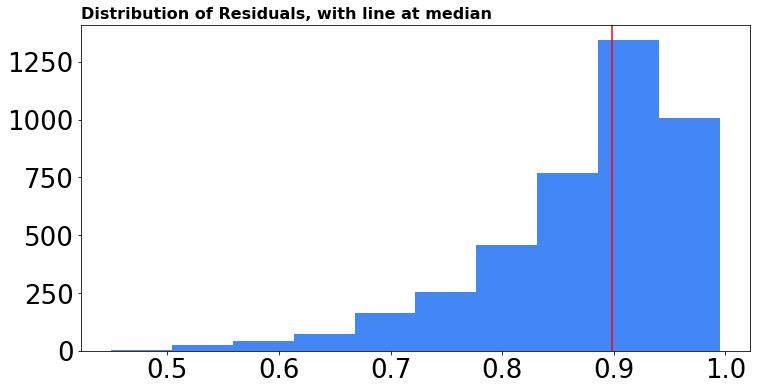

In [71]:
plot_histogram(
    df_topics["resid"],
    "Distribution of Residuals, with line at median",
    df_topics["resid"].median(),
    "#4287f5",
    (12, 6),
)

<a id="topic-2"></a>

#### 6.1.1. [<span style="color:red">Topic 2</span>](#topic-2)

The five best texts that fit into topic number 2 are shown below

In [72]:
df_topics[df_topics["topic_num"] == 2].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2015/dec/25/2015-big-year-space-exploration-major-tim-peake-pluto',
 'https://www.theguardian.com/science/2011/jun/05/mars-anniversary-40-years-space',
 'https://www.theguardian.com/science/2008/jul/14/mars.spaceexploration',
 'https://www.theguardian.com/science/2001/apr/05/spaceexploration.technology',
 'https://www.theguardian.com/science/2016/oct/20/total-recall-of-unsuccessful-mars-lander-schiaparelli-exomars']

**Observations**
1. The topics of these articles are listed below
   - [year-end review of scientific, including Mars-based research, findings in 2015](https://www.theguardian.com/science/2015/dec/25/2015-big-year-space-exploration-major-tim-peake-pluto)
   - [anticipating answers about Mars habitability on 40 year anniversary of Mariner 9 launch](https://www.theguardian.com/science/2011/jun/05/mars-anniversary-40-years-space)
   - [about a joint NASA-ESA Mars mission proposal with sample return, with estimated launch between 2018-2023](https://www.theguardian.com/science/2008/jul/14/mars.spaceexploration)
     - this turned out to be the Insight mission with a [lander](https://en.wikipedia.org/wiki/InSight) and [Perseverance rover](https://en.wikipedia.org/wiki/Perseverance_(rover)) with the [Ingenuity helicopter](https://en.wikipedia.org/wiki/Mars_Helicopter_Ingenuity) onboard
   - [anticipating the launch of the Odyssey orbiter launch](https://www.theguardian.com/science/2001/apr/05/spaceexploration.technology)
   - [list and operational details about of Mars missions that were lost](https://www.theguardian.com/science/2016/oct/20/total-recall-of-unsuccessful-mars-lander-schiaparelli-exomars)

The five worst texts that fit into this topic are shown below

In [73]:
df_topics[df_topics["topic_num"] == 2].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2014/apr/30/nasa-spacesuit-zseries-new-design-mars',
 'https://www.theguardian.com/science/shortcuts/2013/feb/28/mars-mission-married-couple-space',
 'https://www.theguardian.com/science/2019/jun/23/all-female-mars-colony-possible-using-frozen-sperm-says-study',
 'https://www.theguardian.com/science/sifting-the-evidence/2013/mar/13/medical-research-health',
 'https://www.theguardian.com/science/2012/jul/20/spacewatch-curiosity-mars-landing']

**Observations**
1. The topics of these articles are listed below   
   - [about NASA's announced spacesuit to aid humans on Mars](https://www.theguardian.com/science/2014/apr/30/nasa-spacesuit-zseries-new-design-mars)
   - [about space tourism in 2018](https://www.theguardian.com/science/shortcuts/2013/feb/28/mars-mission-married-couple-space)
   - [about colonization on Mars](https://www.theguardian.com/science/2019/jun/23/all-female-mars-colony-possible-using-frozen-sperm-says-study)
   - [book discussing extreme conditions that could be encountered during a manned mission to Mars](https://www.theguardian.com/science/sifting-the-evidence/2013/mar/13/medical-research-health)
   - [reporting on the Curiosity rover's landing procedure on Mars in 2012](https://www.theguardian.com/science/2012/jul/20/spacewatch-curiosity-mars-landing)

The focus of the best articles remains on science and operations for Mars missions. The worst articles focus on manned missions to Mars - habitability, spacesuits, landing sequence (for spacecraft), tourism.

<a id="topic-1"></a>

#### 6.1.2. [<span style="color:red">Topic 1</span>](#topic-1)

The five best texts that fit into topic number 1 are shown below

In [74]:
df_topics[df_topics["topic_num"] == 1].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2005/jul/07/1',
 'https://www.theguardian.com/science/2010/oct/31/us-space-shuttle-discovery-mission',
 'https://www.theguardian.com/science/2005/apr/10/spaceexploration.usnews',
 'https://www.theguardian.com/science/2005/jul/29/sciencenews.spaceexploration',
 'https://www.theguardian.com/science/2005/aug/09/sciencenews.usnews']

**Observations**
1. The topics of these articles are listed below
   - [reporting on NASA's plans to re-attempt the Columbia shuttle mission, two years after the 2003 crash](https://www.theguardian.com/science/2005/jul/07/1)
   - [about preparing for launch of the last mission for the shuttle Discovery](https://www.theguardian.com/science/2010/oct/31/us-space-shuttle-discovery-mission)
   - [about Discovery's last mission risks despite learning and fixing issues related to 2003 Columbia crash](https://www.theguardian.com/science/2005/apr/10/spaceexploration.usnews)
   - [looking ahead to Discovery's last launch mission, while discussing the problem of debris from the 2003 Columbia crash](https://www.theguardian.com/science/2005/jul/29/sciencenews.spaceexploration)
   - [about Discovery reaching back safely](https://www.theguardian.com/science/2005/apr/10/spaceexploration.usnews)

The five worst texts that fit into this topic are shown below

In [75]:
df_topics[df_topics["topic_num"] == 1].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2003/jan/17/spaceexploration.internationaleducationnews',
 'https://www.theguardian.com/science/2007/feb/08/spaceexploration.weekendmagazinespacesection',
 'https://www.theguardian.com/science/2011/may/17/photograph-space-shuttle-endeavour-aeroplane',
 'https://www.theguardian.com/science/2004/sep/23/thisweekssciencequestions2',
 'https://www.theguardian.com/science/2000/jan/31/spaceexploration']

**Observations**
1. The topics of these articles are listed below
   - [about approval for the Endeavour shuttle launch in 2000 to map the Earth](https://www.theguardian.com/science/2000/jan/31/spaceexploration)
   - [about more stringent NASA screening after astronaut arrested for at attempted murder](https://www.theguardian.com/science/2007/feb/08/spaceexploration.weekendmagazinespacesection)
   - [about an Israeli astronaut on the Columbia shuttle mission](https://www.theguardian.com/science/2003/jan/17/spaceexploration.internationaleducationnews)
   - [about picture of Endeavour shuttle's launch](https://www.theguardian.com/science/2011/may/17/photograph-space-shuttle-endeavour-aeroplane)
   - [about nuclear technology in use for Prometheus project](https://www.theguardian.com/science/2004/sep/23/thisweekssciencequestions2)

The best articles focus on the Columbia shuttle crash. The worst focus on space shuttles in a variety of contexts.

<a id="topic-6"></a>

#### 6.1.3. [<span style="color:red">Topic 6</span>](#topic-6)

The five best texts that fit into topic number 6 are shown below

In [76]:
df_topics[df_topics["topic_num"] == 6].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2011/aug/03/second-moon-collision',
 'https://www.theguardian.com/science/2018/dec/07/chinese-spacecraft-attempt-first-landing-far-side-of-moon-change-4',
 'https://www.theguardian.com/science/2019/jul/06/everyones-going-to-the-moon-again-apollo-11-50th-aniversary',
 'https://www.theguardian.com/science/2005/jul/18/spaceexploration.internationalnews',
 'https://www.theguardian.com/science/1999/jul/19/spaceexploration.g2']

**Observations**
1. The topics of these articles are listed below
   - [about possible previous collision between Moon and another moon](https://www.theguardian.com/science/2011/aug/03/second-moon-collision)
   - [about China's plans to land on moon](https://www.theguardian.com/science/2018/dec/07/chinese-spacecraft-attempt-first-landing-far-side-of-moon-change-4)
   - [Written in 2019 (as 50th anniversary of Apollo 11 approached), discusses new interest in Moon exploration](https://www.theguardian.com/science/2019/jul/06/everyones-going-to-the-moon-again-apollo-11-50th-aniversary)
   - [about Lunar orbiter to take pictures of Apollo landing site](https://www.theguardian.com/science/2005/jul/18/spaceexploration.internationalnews)
   - [Written in 1999, references complete absence of moon landings for a period of](https://www.theguardian.com/science/1999/jul/19/spaceexploration.g2) 27 years ([1](https://www.history.com/news/us-moon-landings-apollo))

The five worst texts that fit into this topic are shown below

In [77]:
df_topics[df_topics["topic_num"] == 6].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/1999/sep/22/spaceexploration.business',
 'https://www.theguardian.com/science/2019/aug/06/tardigrades-may-have-survived-spacecraft-crashing-on-moon',
 'https://www.theguardian.com/science/2018/oct/17/the-most-iconic-photograph-of-earth',
 'https://www.theguardian.com/science/2006/jun/15/spaceexploration.alternativeinvestment',
 'https://www.theguardian.com/science/2006/oct/18/spaceexploration.g2']

**Observations**
1. The topics of these articles are listed below
   - [Moon tourism](https://www.theguardian.com/science/1999/sep/22/spaceexploration.business)
   - [about a phyllum surviving Israeli private Moon lander crash](https://www.theguardian.com/science/2019/aug/06/tardigrades-may-have-survived-spacecraft-crashing-on-moon)
   - [about picture of Earth taken by Appolo 8 astronaut](https://www.theguardian.com/science/2018/oct/17/the-most-iconic-photograph-of-earth)
   - [about real estate on the Moon](https://www.theguardian.com/science/2006/jun/15/spaceexploration.alternativeinvestment)
   - [about a competition to put a Swedish house on the moon](https://www.theguardian.com/science/2006/oct/18/spaceexploration.g2)

The focus of the best articles is on exploring the Moon. The worst articles focus on manned missions to the Moon.

<a id="topic-15"></a>

#### 6.1.4. [<span style="color:red">Topic 15</span>](#topic-15)

The five best texts that fit into topic number 15 are shown below

In [78]:
df_topics[df_topics["topic_num"] == 15].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2004/jul/01/spaceexploration.research',
 'https://www.theguardian.com/science/2017/apr/30/cassini-saturn-space-probe-fiery-finale-nasa',
 'https://www.theguardian.com/science/2004/jun/04/spaceexploration.starsgalaxiesandplanets',
 'https://www.theguardian.com/science/2004/jun/27/spaceexploration.research',
 'https://www.theguardian.com/science/2017/sep/14/nasas-cassini-spacecraft-poised-to-begin-mission-ending-dive-into-saturn']

**Observations**
1. The topics of these articles are listed below
   - approaching end of Cassini mission
     - [1](https://www.theguardian.com/science/2017/apr/30/cassini-saturn-space-probe-fiery-finale-nasa)
     - [2](https://www.theguardian.com/science/2017/sep/14/nasas-cassini-spacecraft-poised-to-begin-mission-ending-dive-into-saturn)
   - Cassini spacecraft enters Saturn orbit
     - [1](https://www.theguardian.com/science/2004/jul/01/spaceexploration.research)
     - [2](https://www.theguardian.com/science/2004/jun/04/spaceexploration.starsgalaxiesandplanets)
     - [3](https://www.theguardian.com/science/2004/jun/27/spaceexploration.research)

The five worst texts that fit into this topic are shown below

In [79]:
df_topics[df_topics["topic_num"] == 15].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2017/dec/07/spacewatch-voyager-1-gets-new-lease-of-life',
 'https://www.theguardian.com/science/2016/oct/26/hexagon-on-saturn-nasa-scientists-ponder-colour-changing-north-pole',
 'https://www.theguardian.com/science/punctuated-equilibrium/2011/may/02/1',
 'https://www.theguardian.com/science/2005/jan/13/thisweekssciencequestions2',
 'https://www.theguardian.com/science/1999/aug/19/spaceexploration.aeronautics']

**Observations**
1. The topics of these articles are listed below
   - [firing reserve thrusters on Voyager spacecraft that passed Saturn and its moon Titan in 1980](https://www.theguardian.com/science/2017/dec/07/spacewatch-voyager-1-gets-new-lease-of-life)
   - [about Cassini's observed change in Saturn's colour at north pole](https://www.theguardian.com/science/2016/oct/26/hexagon-on-saturn-nasa-scientists-ponder-colour-changing-north-pole)
   - [how Earth would look like with Saturn's rings](https://www.theguardian.com/science/punctuated-equilibrium/2011/may/02/1)
   - [anticipating Cassini entering atmosphere of the moon Titan, during which time music will be delivered](https://www.theguardian.com/science/2005/jan/13/thisweekssciencequestions2)
   - [about Cassini probe entering last phase of travel from Earth towards Saturn](https://www.theguardian.com/science/1999/aug/19/spaceexploration.aeronautics)

The topic is focused on the mission updates for the Cassini probe. The sub-topic of water across the solar system and, even on Earth, has been separated. While Cassini did find evidence of water on Saturn's moon ([1](https://solarsystem.nasa.gov/missions/cassini/science/enceladus/), [2](https://www.nasa.gov/mission_pages/cassini/media/cassini-20060309.html)), this specific topic (even the majority of the worst articles) covers articles that are focused on the mission operations itself.

<a id="topic-10"></a>

#### 6.1.5. [<span style="color:red">Topic 10</span>](#topic-10)

The five best texts that fit into topic number 10 are shown below

In [80]:
df_topics[df_topics["topic_num"] == 10].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2015/mar/05/nasa-finds-evidence-of-a-vast-ancient-ocean-on-mars',
 'https://www.theguardian.com/science/2018/jul/25/huge-underground-lake-discovered-on-mars-say-astronomers',
 'https://www.theguardian.com/science/2006/dec/07/starsgalaxiesandplanets.spaceexploration',
 'https://www.theguardian.com/science/2015/sep/28/nasa-scientists-find-evidence-flowing-water-mars',
 'https://www.theguardian.com/science/2018/aug/20/ice-found-on-moon-surface']

**Observations**
1. The topics are focused on finding evidence of water across the Solar System.

The five worst texts that fit into this topic are shown below

In [81]:
df_topics[df_topics["topic_num"] == 10].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2008/may/02/chemistry.physics',
 'https://www.theguardian.com/science/grrlscientist/2012/aug/18/4',
 'https://www.theguardian.com/science/2019/jan/27/the-five-tardigrades-tiny-but-tough-subglacial-lake-antarctica-heat-cold-vacuum-space-resilience',
 'https://www.theguardian.com/science/2015/aug/19/potential-sources-of-helium-revealed-as-reserves-of-the-precious-gas-dwindle',
 'https://www.theguardian.com/science/2004/jan/08/research.science1']

**Observations**
1. The topics of these articles are listed below
   - [toy experiment to show that gas takes up more volume than solids](https://www.theguardian.com/science/2008/may/02/physics.chemistry)
     - water mixed with Alka-Seltzer causes the container to shoot up like a rocket
   - [cooking recipe (involves water)](https://www.theguardian.com/science/grrlscientist/2012/aug/18/4)
   - [about tardigrades ability to survive in extreme conditions - ice, heat, etc. - on Earth](https://www.theguardian.com/science/2019/jan/27/the-five-tardigrades-tiny-but-tough-subglacial-lake-antarctica-heat-cold-vacuum-space-resilience)
   - [about Helium in presence of groundwater in some places on Earth](https://www.theguardian.com/science/2015/aug/19/potential-sources-of-helium-revealed-as-reserves-of-the-precious-gas-dwindle)
   - [basic science of a stone skimming on water](https://www.theguardian.com/science/2004/jan/08/research.science1)

The best articles here focus on discovery of water on planets across the solar system. The worst involve uses of water on Earth - cooking, stone skimming, experiments, etc.

<a id="topic-4"></a>

#### 6.1.6. [<span style="color:red">Topic 4</span>](#topic-4)

The five best texts that fit into topic number 4 are shown below

In [82]:
df_topics[df_topics["topic_num"] == 4].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2014/nov/12/rosetta-mission-philae-historic-landing-comet',
 'https://www.theguardian.com/science/2014/nov/01/rosetta-comet-space-mission-nears-end',
 'https://www.theguardian.com/science/2014/jan/17/rosetta-comet-chury-esa-67p-churyumov-erasimenko',
 'https://www.theguardian.com/science/2014/aug/05/rosetta-spacecraft-rendezvous-rubber-duck-comet',
 'https://www.theguardian.com/science/2015/aug/12/rosetta-witness-cosmic-firework-display-comet-67p-nears-sun-perihelion']

**Observations**
1. The topics are focused on operational events related to the Rosetta spacecraft mission to comet 67P - mission end by crashing into comet, landing on comet, images captured, etc.

The five worst texts that fit into this topic are shown below

In [83]:
df_topics[df_topics["topic_num"] == 4].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2000/jan/19/spaceexploration.medicineandhealth',
 'https://www.theguardian.com/science/2005/jul/07/thisweekssciencequestions2',
 'https://www.theguardian.com/science/2001/dec/20/technology',
 'https://www.theguardian.com/science/2003/feb/28/spaceexploration.highereducation',
 'https://www.theguardian.com/science/2006/jan/21/uknews']

**Observations**
1. The topics of these articles are listed below
   - [about the flu epidemic being due to comets passing close to Earth due to energy creaed by sunspots](https://www.theguardian.com/science/2000/jan/19/spaceexploration.medicineandhealth)
   - [about the Temple 1 probe mission ending with its descent and crash into a comet](https://www.theguardian.com/science/2005/jul/07/thisweekssciencequestions2)
   - [about shutting down the Deep Space 1 spacecraft which flew by a comet](https://www.theguardian.com/science/2001/dec/20/technology)
   - [about finding decayed comet bits](https://www.theguardian.com/science/2003/feb/28/spaceexploration.highereducation)
   - [about aerogel - the material used by the Stardust spacecraft to capture comet dust](https://www.theguardian.com/science/2006/jan/21/uknews)

The best articles here focus on the Rosetta spacecraft's mission to comet 67P. The worst focus on other comets and, in some cases, do not focus on space missions but on comet dust/debris - most of the worst articles are focused on scientific findings or mission operations.

<a id="topic-5"></a>

#### 6.1.7. [<span style="color:red">Topic 5</span>](#topic-5)

The five best texts that fit into topic number 5 are shown below

In [84]:
df_topics[df_topics["topic_num"] == 5].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2014/nov/13/philae-landing-rosetta-mission-good-bad-news',
 'https://www.theguardian.com/science/2014/nov/13/philae-lander-first-ever-image-comet-surface-rosetta',
 'https://www.theguardian.com/science/2014/nov/13/rosetta-philae-comet-mission-what-went-right-what-went-wrong-and-how-it-can-be-fixed',
 'https://www.theguardian.com/science/2015/may/08/rosetta-spacecraft-begins-to-listen-out-for-philae-contact',
 'https://www.theguardian.com/science/2014/nov/16/philae-rosetta-comet-probe']

**Observations**
1. The topic is focused on news reports about the Philae lander as part of the Rosetta mission.

The five worst texts that fit into this topic are shown below

In [85]:
df_topics[df_topics["topic_num"] == 5].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2014/nov/14/rosetta-comet-dr-matt-taylor-apology-sexist-shirt',
 'https://www.theguardian.com/science/2016/sep/30/after-rosetta-what-next-for-the-european-space-agency',
 'https://www.theguardian.com/science/2014/nov/15/rosetta-mission-flight-of-icarus-or-large-step-europe',
 'https://www.theguardian.com/science/2016/sep/25/european-space-agency-accused-of-having-a-problem-with-promoting-women',
 'https://www.theguardian.com/science/2014/oct/23/rosetta-mission-philae-comet-universe']

**Observations**
1. Although most of the worst articles in this topic place the Rosetta mission as a secondary area of focus, the focus remains on non-science/operational themes connected to the mission.

The Philae lander, as part of the Rosetta mission, is the focus here. The worst articles place the try to keep the mission at the center of focus, but it is a secondary theme to some of these articles - there is no emphasis on the Philae lander. The best ones focus on Philae itself.

<a id="topic-9"></a>

#### 6.1.8. [<span style="color:red">Topic 9</space>](#topic-9)

The five best texts that fit into topic number 9 are shown below

In [86]:
df_topics[df_topics["topic_num"] == 9].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2010/oct/24/international-space-station-nasa-astronauts',
 'https://www.theguardian.com/science/2000/sep/08/spaceexploration',
 'https://www.theguardian.com/science/2000/nov/02/spaceexploration',
 'https://www.theguardian.com/science/2000/sep/27/spaceexploration',
 'https://www.theguardian.com/science/2015/dec/15/first-uk-astronaut-tim-peake-boards-international-space-station-beautiful-launch']

**Observations**
1. The topics are focused on operational events (launch, arrival, crew) related to the International Space Station.

The five worst texts that fit into this topic are shown below

In [87]:
df_topics[df_topics["topic_num"] == 9].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/brain-flapping/2015/aug/18/david-cameron-captain-enterprise-star-trek',
 'https://www.theguardian.com/science/2015/dec/16/major-peake-and-the-space-tim-continuum',
 'https://www.theguardian.com/science/2019/sep/08/salyut-1-beat-skylab-in-space-station-race',
 'https://www.theguardian.com/science/2001/jan/06/spaceexploration.weekendmagazine4',
 'https://www.theguardian.com/science/grrlscientist/2013/oct/12/nasa-space']

**Observations**
1. The topics of these articles involve people related to the ISS, videos filmed from the ISS or the first overall space station (Salyut 1 from Russia).

The focus of this topic is on the ISS. The worst articles do not directly relate to the ISS at all.

<a id="topic-12"></a>

#### 6.1.9. [<span style="color:red">Topic 12</span>](#topic-12)

The five best texts that fit into topic number 12 are shown below

In [88]:
df_topics[df_topics["topic_num"] == 12].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2012/jul/04/higgs-boson-discovery-real-work',
 'https://www.theguardian.com/science/2012/jul/04/higgs-boson-cern-scientists-discover',
 'https://www.theguardian.com/science/2011/dec/13/scientists-higgs-boson-god-particle',
 'https://www.theguardian.com/science/2011/feb/28/large-hadron-collider-higgs-boson',
 'https://www.theguardian.com/science/2007/may/27/particlephysics.observermagazine']

**Observations**
1. The topics are focused on the search for the Higgs Boson.

The five worst texts that fit into this topic are shown below

In [89]:
df_topics[df_topics["topic_num"] == 12].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/life-and-physics/2016/feb/02/the-cosmic-gift-of-neutron-stars',
 'https://www.theguardian.com/science/life-and-physics/2010/sep/28/safety-large-hadron-collider-lhc',
 'https://www.theguardian.com/science/life-and-physics/2011/nov/16/1',
 'https://www.theguardian.com/science/2014/may/11/what-is-newtons-second-law-of-motion',
 'https://www.theguardian.com/science/2008/jun/30/cern.particlephysics2']

**Observations**
1. The topics of these articles are only generally focused on operating the LHC - safety, facts/figures - or about other particles (some of which don't involve bosons).

The topic is focused on bosons, with a secondary emphasis (some of the worst articles) on other particles (neutron) which indirectly emphasize bosons.

<a id="topic-13"></a>

#### 6.1.10. [<span style="color:red">Topic 13</span>](#topic-13)

The five best texts that fit into topic number 13 are shown below

In [90]:
df_topics[df_topics["topic_num"] == 13].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2018/mar/14/stephen-hawking-professor-dies-aged-76',
 'https://www.theguardian.com/science/2008/mar/02/stephen.hawking',
 'https://www.theguardian.com/science/2012/jan/06/physicists-toast-stephen-hawking',
 'https://www.theguardian.com/science/2005/sep/27/scienceandnature.highereducationprofile',
 'https://www.theguardian.com/science/2018/may/02/stephen-hawkings-final-theory-sheds-light-on-the-multiverse']

**Observations**
1. The topics are focused on Stephen Hawking and his research.

The five worst texts that fit into this topic are shown below

In [91]:
df_topics[df_topics["topic_num"] == 13].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2004/feb/13/sciencenews.theguardianlifesupplement',
 'https://www.theguardian.com/science/2019/oct/08/nobel-prizes-have-a-point-parking-space',
 'https://www.theguardian.com/science/2002/jan/15/peopleinscience',
 'https://www.theguardian.com/science/shortcuts/2015/may/27/nobel-prize-buyers-guide-to-worlds-top-trophies-leon-lederman',
 'https://www.theguardian.com/science/2016/aug/02/jack-meadows-obituary']

**Observations**
1. The topics of these articles are listed below
   - [scientists show that more M&Ms than ball berrings can fit into a jar](https://www.theguardian.com/science/2004/feb/13/sciencenews.theguardianlifesupplement)
   - [Nobel Prize laureates get a dedicated parking space](https://www.theguardian.com/science/2019/oct/08/nobel-prizes-have-a-point-parking-space)
   - [about Aristotle](https://www.theguardian.com/science/2002/jan/15/peopleinscience)
   - [dollar value of Nobel Prize, from experimental physicist selling his award](https://www.theguardian.com/science/shortcuts/2015/may/27/nobel-prize-buyers-guide-to-worlds-top-trophies-leon-lederman)
   - [obituary for Physics professor Jack Meadows](https://www.theguardian.com/science/2016/aug/02/jack-meadows-obituary)

The best articles here focus on the life and accemplishments of Stephen Hawking. The worst involve other experimental Physicists.

<a id="topic-25"></a>

#### 6.1.11. [<span style="color:red">Topic 25</span>](#topic-25)

The five best texts that fit into topic number 25 are shown below

In [92]:
df_topics[df_topics["topic_num"] == 25].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2019/jan/11/scientists-close-to-capturing-first-image-of-black-hole-at-the-centre-of-the-milky-way',
 'https://www.theguardian.com/science/2016/jan/06/visible-light-black-holes-detected-for-first-time-v404-cygni',
 'https://www.theguardian.com/science/2019/apr/10/black-hole-picture-captured-for-first-time-in-space-breakthrough',
 'https://www.theguardian.com/science/2017/feb/26/black-hole-telescope-big-as-earth-event-horizon-project-sagittarius-a',
 'https://www.theguardian.com/science/2018/mar/14/a-life-in-science-stephen-hawking']

**Observations**
1. The topics are focused on research into understanding and imaging Black Holes. The findings are primarily related to data collected from the Event Horizon telescope (Earth-based).

The five worst texts that fit into this topic are shown below

In [93]:
df_topics[df_topics["topic_num"] == 25].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2017/mar/28/did-you-solve-it-take-the-ada-lovelace-challenge-solution-part-i',
 'https://www.theguardian.com/science/brain-flapping/2013/sep/10/great-science-bake-off-baking-recipes',
 'https://www.theguardian.com/science/brain-flapping/2014/dec/12/santa-claus-father-christmas',
 'https://www.theguardian.com/science/2003/jan/16/science.research1',
 'https://www.theguardian.com/science/2016/oct/04/bagels-pretzels-and-buns-everything-you-need-to-know-about-nobel-physics']

**Observations**
1. The topics of these articles are listed below
      - article about [Ada Lovelace](https://en.wikipedia.org/wiki/Ada_Lovelace)[-inspired puzzle where black squares are prominent](https://www.theguardian.com/science/2017/mar/28/did-you-solve-it-take-the-ada-lovelace-challenge-solution-part-i)
   - [Stephen Hawking black-hole brownies](https://www.theguardian.com/science/brain-flapping/2013/sep/10/great-science-bake-off-baking-recipes)
   - [black hole explains existence of Santa Claus](https://www.theguardian.com/science/brain-flapping/2014/dec/12/santa-claus-father-christmas)   
   - [about](https://www.theguardian.com/science/2003/jan/16/science.research1) the Golden Ratio, which [appears in theory of black holes](https://johncarlosbaez.wordpress.com/2013/02/28/black-holes-and-the-golden-ratio/)
   - [making analogy between doghnuts with holes in them and Nobel Physics topics](https://www.theguardian.com/science/2003/oct/09/spaceexploration.research)

This is a topic about black holes in the universe. Some of the worst articles are loosely connected to the topic.

<a id="topic-28"></a>

#### 6.1.12. [<span style="color:red">Topic 28</span>](#topic-28)

The five best texts that fit into topic number 28 are shown below

In [94]:
df_topics[df_topics["topic_num"] == 28].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2004/jan/08/sciencenews.spaceexploration',
 'https://www.theguardian.com/science/2003/may/22/spaceexploration.starsgalaxiesandplanets',
 'https://www.theguardian.com/science/2003/dec/28/spaceexploration.research1',
 'https://www.theguardian.com/science/2003/dec/29/spaceexploration.uknews',
 'https://www.theguardian.com/science/2003/dec/27/spaceexploration.research1']

**Observations**
1. The topics are focused on launch of and search for the Beagle 2 UK Mars lander.

The five worst texts that fit into this topic are shown below

In [95]:
df_topics[df_topics["topic_num"] == 28].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2005/mar/24/research.science',
 'https://www.theguardian.com/science/2006/mar/13/spaceexploration.transportintheuk',
 'https://www.theguardian.com/science/2006/jun/12/spaceexploration.starsgalaxiesandplanets',
 'https://www.theguardian.com/science/2004/mar/20/spaceexploration.animalrights',
 'https://www.theguardian.com/science/2014/dec/21/colin-pillinger-remembered-monica-grady-observer-obituaries-2014-open-university']

**Observations**
1. The topics of these articles are listed below
   - [mentions Beagle 2 researchers being candidates for an award](https://www.theguardian.com/science/2005/mar/24/research.science)
   - [Beagle 2 mission lead talking about patent for nuclear-powered flying saucer](https://www.theguardian.com/science/2006/mar/13/spaceexploration.transportintheuk)
   - [about tests on Mars rover prototype as successor to Beagle 2](https://www.theguardian.com/science/2006/jun/12/spaceexploration.starsgalaxiesandplanets), as [part of the ExoMars mission](https://www.theguardian.com/science/2006/aug/22/spaceexploration.uknews)
   - [mentions Beagle spacecraft in article about Russian dog sent to space](https://www.theguardian.com/science/2004/mar/20/spaceexploration.animalrights)
   - [obituary for a researcher involved with the advocating for *in situ* analyses on the Philae lander that accompanied Rosetta](https://www.theguardian.com/science/2014/dec/21/colin-pillinger-remembered-monica-grady-observer-obituaries-2014-open-university)

The best articles here focus on science and (primarily) operations related to the lost Btitish Beagle 2 Mars lander. The worst articles (sometimes loosely) reference the Beagle 2, but are not directly related to its mission ([Mars Express](https://en.wikipedia.org/wiki/Mars_Express)).

<a id="topic-3"></a>

#### 6.1.13. [<span style="color:red">Topic 3</span>](#topic-3)

The five best texts that fit into topic number 3 are shown below

In [96]:
df_topics[df_topics["topic_num"] == 3].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2007/nov/07/spaceexploration',
 'https://www.theguardian.com/science/2010/oct/28/galaxy-planets-mass-earth-life',
 'https://www.theguardian.com/science/2009/dec/16/waterworld-planet-earth-life',
 'https://www.theguardian.com/science/2007/nov/06/spaceexploration.g2',
 'https://www.theguardian.com/science/2011/feb/02/new-planets-solar-system']

**Observations**
1. The topics are focused on the discovery of new planets.

The five worst texts that fit into this topic are shown below

In [97]:
df_topics[df_topics["topic_num"] == 3].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2004/sep/04/starsgalaxiesandplanets.spaceexploration',
 'https://www.theguardian.com/science/2003/jan/16/technology',
 'https://www.theguardian.com/science/2008/may/14/usa',
 'https://www.theguardian.com/science/2018/jun/03/starwatch-venus-gemini-castor-pollux',
 'https://www.theguardian.com/science/2015/dec/10/dawn-second-time-venus']

**Observations**
1. The topics of these articles are listed below
   - [about discovery of Earth-like planets](https://www.theguardian.com/science/2004/sep/04/starsgalaxiesandplanets.spaceexploration)
   - [about the Israeli astronaut who was part of the Columbia shuttle mission](https://www.theguardian.com/science/2003/jan/16/technology)
   - [about discovery of youngest supernova in Milky Way](https://www.theguardian.com/science/2008/may/14/usa)
   - [about Japanese spacecraft successfully orbiting Venus](https://www.theguardian.com/science/2015/dec/10/dawn-second-time-venus)
   - [about the brightness of the planet Venus](https://www.theguardian.com/science/2018/jun/03/starwatch-venus-gemini-castor-pollux)

The best articles focus on discovery of new planets, including Earth-like ones. The worst focus on existing planets (Venus) and discovery of new planets.

**Best** - Discovrey of new planets

**Worst** - New and Existing planets

<a id="topic-7"></a>

#### 6.1.14. [<span style="color:red">Topic 7</span>](#topic-7)

The five best texts that fit into topic number 7 are shown below

In [98]:
df_topics[df_topics["topic_num"] == 7].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2016/sep/01/spacex-falcon-9-explosion-tesla-elon-musk-nasa',
 'https://www.theguardian.com/science/2017/mar/30/spacex-falcon-9-elon-musk-reusable-rocket',
 'https://www.theguardian.com/science/2016/may/06/spacex-lands-reusable-rocket-for-second-time',
 'https://www.theguardian.com/science/2017/feb/27/spacex-moon-private-mission-2018-elon-musk',
 'https://www.theguardian.com/science/2018/feb/09/new-space-race-billionaires-elon-musk-jeff-bezos']

**Observations**
1. The topics are focused on reports about Spacex events involving Falcon rockets - launch, landing, crash.

The five worst texts that fit into this topic are shown below

In [99]:
df_topics[df_topics["topic_num"] == 7].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2018/feb/09/runways-rockets-and-russells-teapot',
 'https://www.theguardian.com/science/2004/jul/15/science.research',
 'https://www.theguardian.com/science/shortcuts/2017/feb/28/140-pound-mile-elon-musk-moon-trip-spacex-compare-terrestrial-journeys',
 'https://www.theguardian.com/science/the-h-word/2015/oct/14/frank-malina-and-an-overlooked-space-age-milestone',
 'https://www.theguardian.com/science/1999/aug/21/spaceexploration.uknews']

**Observations**
1. The topics of these articles are listed below
   - [mentions absence of teapot on Elon Musk's (SpaceX founder) rocket](https://www.theguardian.com/science/2018/feb/09/runways-rockets-and-russells-teapot)
     - no mention of Falcon rocket, just rocket
   - [2004 article on use of rocket nozzle technology in loud speakers](https://www.theguardian.com/science/2004/jul/15/science.research)
     - nozzles are built to optimize air flow and turbulence at launch time
   - [comparing cost of moon trip on Falcon Heavy to terrestrial trips](https://www.theguardian.com/science/shortcuts/2017/feb/28/140-pound-mile-elon-musk-moon-trip-spacex-compare-terrestrial-journeys)
   - [anniversary of first successful launch of liquid-fuelled rocket](https://www.theguardian.com/science/the-h-word/2015/oct/14/frank-malina-and-an-overlooked-space-age-milestone)
   - [1999 article on successful launch](https://www.theguardian.com/science/1999/aug/21/spaceexploration.uknews) of [Starchaser 3A rocket, in the UK](https://en.wikipedia.org/wiki/Starchaser_Industries#Launched_Rockets)

The best articles focus on events involving SpaceX operational events. The worst focus on uses of rocket technology - this could include (non-SpaceX) launches and space tourism.

<a id="topic-8"></a>

#### 6.1.15. [<span style="color:red">Topic 8</span>](#topic-8)

The five best texts that fit into topic number 8 are shown below

In [100]:
df_topics[df_topics["topic_num"] == 8].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2006/nov/17/spaceexploration.internationalnews',
 'https://www.theguardian.com/science/2017/mar/19/confessions-of-an-asteroid-hunter-dr-carrie-nugent-bruce-willis',
 'https://www.theguardian.com/science/2015/jun/30/search-deadly-asteroids-protect-earth-brian-may-lord-rees',
 'https://www.theguardian.com/science/2002/apr/18/spaceexploration.research',
 'https://www.theguardian.com/science/2010/apr/28/asteroid-coated-ice-life-space']

**Observations**
1. The topics are focused on imminent and future threatening asteroids.

The five worst texts that fit into this topic are shown below

In [101]:
df_topics[df_topics["topic_num"] == 8].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2001/mar/01/technology3',
 'https://www.theguardian.com/science/2000/nov/09/technology2',
 'https://www.theguardian.com/science/2013/jun/18/nasa-astronaut-mars-2013-women',
 'https://www.theguardian.com/science/2003/nov/20/science.research',
 'https://www.theguardian.com/science/2019/mar/18/meteor-blast-over-bering-sea-was-10-times-size-of-hiroshima']

**Observations**
1. The topics of these articles are listed below
   - [about UK government agreeing to more studies for near-Earth asteroids](https://www.theguardian.com/science/2001/mar/01/technology3)
   - [about canceled asteroid exploring rover](https://www.theguardian.com/science/2000/nov/09/technology2)
   - [from 2013, about new class of astronauts who could be involved in a mission to an asteroid](https://www.theguardian.com/science/2013/jun/18/nasa-astronaut-mars-2013-women)
   - [on probability of massive asteroid hitting the Earth](https://www.theguardian.com/science/2003/nov/20/science.research)
   - [about efforts to track space rocks threatening Earth - asteroids, mneteors](https://www.theguardian.com/science/2019/mar/18/meteor-blast-over-bering-sea-was-10-times-size-of-hiroshima)

The best articles focus on threatening asteroids. The worst focus on threatening asteroids or missions to asteroids.

**Best** - Earth-threatening asteroids

**Worst** - Earth-threatening asteroids and Missions to asteroids

<a id="topic-11"></a>

#### 6.1.16. [<span style="color:red">Topic 11</span>](#topic-11)

The five best texts that fit into topic number 11 are shown below

In [102]:
df_topics[df_topics["topic_num"] == 11].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2008/feb/14/spaceexploration.spacetechnology',
 'https://www.theguardian.com/science/2013/may/20/tim-peake-space-station-mission',
 'https://www.theguardian.com/science/2007/jan/11/spaceexploration.uknews',
 'https://www.theguardian.com/science/2007/aug/08/spaceexploration.telecoms',
 'https://www.theguardian.com/science/2004/jan/08/spaceexploration.science1']

**Observations**
1. The topics are focused on
   - [about plans to ignore astronauts in UK space policy in 2008](https://www.theguardian.com/science/2008/feb/14/spaceexploration.spacetechnology)
   - [announcement of British astronaut to travel to ISS](https://www.theguardian.com/science/2013/may/20/tim-peake-space-station-mission)
   - [about UK company's plans for moon satellites, in part aimed at probing for future manned bases](https://www.theguardian.com/science/2007/jan/11/spaceexploration.uknews)
   - [on UK's potential for space exploration areas - manned missions vs satellites (its strength)](https://www.theguardian.com/science/2007/aug/08/spaceexploration.telecoms)
   - [in 2004, about the low profile of the British space program](https://www.theguardian.com/science/2004/jan/08/spaceexploration.science1)

The five worst texts that fit into this topic are shown below

In [103]:
df_topics[df_topics["topic_num"] == 11].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2008/jul/17/spaceexploration.usa',
 'https://www.theguardian.com/science/2018/sep/17/dont-delay-aged-care-reforms-because-of-royal-commission-government-urged',
 'https://www.theguardian.com/science/2016/jun/28/huge-helium-gas-tanzania-east-africa-averts-medical-shortage',
 'https://www.theguardian.com/science/2005/sep/12/spaceexploration.business',
 'https://www.theguardian.com/science/1999/aug/17/spaceexploration.aeronautics']

**Observations**
1. The topics of these articles are listed below
   - [in 2008 about urine sample donations for NASA tests of space capsules for space travellers](https://www.theguardian.com/science/2008/jul/17/spaceexploration.usa)
   - [about delaying aged care reforms in UK](https://www.theguardian.com/science/2018/sep/17/dont-delay-aged-care-reforms-because-of-royal-commission-government-urged)
   - [about Helium gas reserve discovery in Africa](https://www.theguardian.com/science/2016/jun/28/huge-helium-gas-tanzania-east-africa-averts-medical-shortage)
     - article mentions that some of Earth's initial Helium content was ``lost to space``
   - [about astronaut monitoring company becoming public](https://www.theguardian.com/science/2005/sep/12/spaceexploration.business)
   - [about two Swedish citizens hacking into NASA](https://www.theguardian.com/science/1999/aug/17/spaceexploration.aeronautics)

The best articles focus on the extent of the British space program's focus - primarily on satellites. The worst are a mix of space related topics

**Best** - British space program

**Worst** - Random Space news, loosely connected to finance

<a id="topic-14"></a>

#### 6.1.17. [<span style="color:red">Topic 14</span>](#topic-14)

The five best texts that fit into topic number 14 are shown below

In [104]:
df_topics[df_topics["topic_num"] == 14].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2001/jan/08/spaceexploration.uknews',
 'https://www.theguardian.com/science/across-the-universe/2018/jul/26/total-lunar-eclipse-2018-how-to-see-the-blood-moon-and-the-science-behind-it',
 'https://www.theguardian.com/science/2018/jul/27/blood-moon-and-mars-to-provide-double-celestial-treat-on-friday',
 'https://www.theguardian.com/science/2017/aug/15/us-eclipse-viewing-astronomy-space',
 'https://www.theguardian.com/science/2017/aug/21/total-solar-eclipse-across-us-reactions']

**Observations**
1. The topics report on or look ahead to the occurrence of an eclipse.

The five worst texts that fit into this topic are shown below

In [105]:
df_topics[df_topics["topic_num"] == 14].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2001/sep/06/physicalsciences.highereducation',
 'https://www.theguardian.com/science/2001/mar/08/spaceexploration.uknews',
 'https://www.theguardian.com/science/2018/jun/17/starwatch-time-to-look-for-noctilucent-clouds-at-the-edge-of-space',
 'https://www.theguardian.com/science/2016/mar/17/st-patricks-day-meteor-sky-over-britain',
 'https://www.theguardian.com/science/2001/aug/14/spaceexploration.uknews']

**Observations**
1. The topics of these articles are listed below
   - [science approach to stopping a shower curtain from wrapping itself around your legs](https://www.theguardian.com/science/2001/sep/06/physicalsciences.highereducation)
   - [astronomer used science and a trip northwest of Paris to pinpoint the moment of creation of a van Gogh](https://www.theguardian.com/science/2001/mar/08/spaceexploration.uknews)
     - article mentions the following about same astronomer
       - traced the origins of the term "blue moon"
       - tracked down evidence that the young Abraham Lincoln witnessed meteor storm
       - proposed that the star mentioned Hamlet could have been a supernova
   - [about noctiluscent clouds](https://www.theguardian.com/science/2018/jun/17/starwatch-time-to-look-for-noctilucent-clouds-at-the-edge-of-space)
     - [cloud-like phenomena in the upper atmosphere of Earth. They consist of ice crystals and are only visible during astronomical twilight](https://en.wikipedia.org/wiki/Noctilucent_cloud)
   - [about light from meteor shower over UK](https://www.theguardian.com/science/2016/mar/17/st-patricks-day-meteor-sky-over-britain)
   - [about street lights being brighter than real night sky](https://www.theguardian.com/science/2001/aug/14/spaceexploration.uknews)

The best focus on an eclipse. The worst focus on astronomical phenomena associated with lighting up the night sky.

**Best** - Eclipse

**Worst** - Astronomical Phenomena that light up the skies during darker times of the day

<a id="topic-16"></a>

#### 6.1.18. [<span style="color:red">Topic 16</span>](#topic-16)

The five best texts that fit into topic number 16 are shown below

In [106]:
df_topics[df_topics["topic_num"] == 16].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2015/jul/10/asas-new-horizons-probe-pluto-flyby',
 'https://www.theguardian.com/science/2015/jul/15/pluto-splendid-semi-planet-new-horizons-adam-roberts-sci-fi',
 'https://www.theguardian.com/science/2015/jul/12/starwatch-pluto-dwarf-planet-new-horizons',
 'https://www.theguardian.com/science/2007/jun/15/spaceexploration.starsgalaxiesandplanets',
 'https://www.theguardian.com/science/2015/apr/11/pluto-new-horizons-spaceship-epic-encounter-planet']

**Observations**
1. The topics are focused on using the [New Horizons probe](https://en.wikipedia.org/wiki/New_Horizons) or [Hubble Space Telescope](https://en.wikipedia.org/wiki/Hubble_Space_Telescope) to capture images of Pluto.

The five worst texts that fit into this topic are shown below

In [107]:
df_topics[df_topics["topic_num"] == 16].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2019/jan/02/first-close-ups-of-ultima-thule-reveal-it-resembles-dark-red-snowman',
 'https://www.theguardian.com/science/2011/may/18/spacewatch-endeavour-shuttle',
 'https://www.theguardian.com/science/2016/mar/16/mystery-of-ceres-bright-spots-deepens-new-data-analysed-nasa-dawn',
 'https://www.theguardian.com/science/2003/oct/05/spaceexploration.observersciencepages',
 'https://www.theguardian.com/science/2018/dec/31/new-horizons-heads-for-flyby-of-space-rock-ultima-thule']

**Observations**
1. The topics of these articles are listed below
   - [New Horizons spacecraft captures first images of Ultima Thule, proposed to have been created by mixing of ice and dust during the early days of the Solar System](https://www.theguardian.com/science/2019/jan/02/first-close-ups-of-ultima-thule-reveal-it-resembles-dark-red-snowman)
   - [report](https://www.theguardian.com/science/2011/may/18/spacewatch-endeavour-shuttle) on [Dawn spacecraft](https://en.wikipedia.org/wiki/Dawn_(spacecraft)) closing in on asteroid before heading for a dwarf planet [Ceres](https://en.wikipedia.org/wiki/Ceres_(dwarf_planet))
   - [protests against using nuclear technology to power spacecraft to (distant) planets beyond Mars as solar powered craft can't benefit from strong enough sunlight as a power source](https://www.theguardian.com/science/2003/oct/05/spaceexploration.observersciencepages)
   - [report on New Horizons communicatoin after flying past Ultima Thule](https://www.theguardian.com/science/2018/dec/31/new-horizons-heads-for-flyby-of-space-rock-ultima-thule) ([which is smaller than a dwarf planet](https://www.space.com/ultima-thule-birth-new-horizons-first-science.html) and is [located further away from Earth than Pluto](https://www.google.com/search?q=where+is+ultima+thule&client=ubuntu&hs=LQz&channel=fs&sxsrf=ALeKk01-AZjHf2Rwo8PvEEaDxRDh0njVfw:1608062644302&tbm=isch&source=iu&ictx=1&fir=dv-l9DQF1rEwvM%252CXVz_LsNMVaU1mM%252C_&vet=1&usg=AI4_-kQHekD5S6R0osfdct69--S5wtX9BA&sa=X&ved=2ahUKEwjboMKV5NDtAhVNQ80KHVw4B-QQ9QF6BAgeEAE&biw=1920&bih=1098#imgrc=gOqqXvnthfZXrM))
   - [about images captured by Dawn spacecraft, of dwarf planet Ceres](https://www.theguardian.com/science/2016/mar/16/mystery-of-ceres-bright-spots-deepens-new-data-analysed-nasa-dawn)

The best articles focus on images of Pluto. The worst focus on images or technology (nuclear power) to study dwarf planets (Ceres), or distant objects smaller than dwarf planets. eg. [Ultima Thule](https://en.wikipedia.org/wiki/486958_Arrokoth)). A [distant minor planet](https://en.wikipedia.org/wiki/Distant_minor_planet) is located beyond Jupiter and Ceres (dwarf planet) is between Mars and Jupiter so, it is likely that the focus of the worst articles is on dwarf planets (or smaller objects) beyond Mars. Operational aspects of missions are included in the worst articles too.

**Best** - science and operations related to dwarf planet Pluto ([a dwarf planet](https://www.space.com/43-pluto-the-ninth-planet-that-was-a-dwarf.html) and a distant object)

**Worst** - science and operations related to distant objects and dwarf planets

<a id="topic-18"></a>

#### 6.1.19. [<span style="color:red">Topic 18</span>](#topic-18)

The five best texts that fit into topic number 18 are shown below

In [108]:
df_topics[df_topics["topic_num"] == 18].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2000/nov/16/spaceexploration',
 'https://www.theguardian.com/science/1999/aug/29/spaceexploration.theobserver',
 'https://www.theguardian.com/science/2000/nov/17/spaceexploration.internationalnews',
 'https://www.theguardian.com/science/2000/nov/15/spaceexploration',
 'https://www.theguardian.com/science/2001/mar/22/spaceexploration.russia']

**Observations**
1. The topics are focused on reporting on the end of the operations for the MIR space station.

The five worst texts that fit into this topic are shown below

In [109]:
df_topics[df_topics["topic_num"] == 18].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2003/feb/02/spaceexploration.theobserver',
 'https://www.theguardian.com/science/2002/mar/14/technology',
 'https://www.theguardian.com/science/2006/jan/07/uknews',
 'https://www.theguardian.com/science/2001/apr/08/spaceexploration.theobserver',
 'https://www.theguardian.com/science/1999/jun/03/technology1']

**Observations**
1. The topics of these articles are listed below
   - [about crashes (also involves Russian cosmonauts) returning from the Salyut 1 space station](https://www.theguardian.com/science/2003/feb/02/spaceexploration.theobserver)
   - [about MIR cosmonaut talking about life in space, in London](https://www.theguardian.com/science/2002/mar/14/technology)
   - [about Russian Space Agency medican team member commenting about alcohol on the ISS](https://www.theguardian.com/science/2006/jan/07/uknews)
   - [on anniversary of Russian cosmonaut Yuri Gagarin's launch into space](https://www.theguardian.com/science/2001/apr/08/spaceexploration.theobserver)
   - [about funding limits facing MIR space station](https://www.theguardian.com/science/1999/jun/03/technology1)

The best articles focus on the end of life of the MIR space station operations. The worst retain a loose focus on Russian space stations, not just MIR, and cover funding issues, launches, famous residents, etc.

**Best** - MIR funding

**Worst** - Russian space stations

<a id="topic-19"></a>

#### 6.1.20. [<span style="color:red">Topic 19</span>](#topic-19)

The five best texts that fit into topic number 19 are shown below

In [110]:
df_topics[df_topics["topic_num"] == 19].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2016/apr/10/virgin-galactic-richard-branson-interview',
 'https://www.theguardian.com/theobserver/2012/jun/17/space-tourism-science-virgin-robin-mckie',
 'https://www.theguardian.com/science/2019/jul/09/richard-branson-virgin-galactic-go-public',
 'https://www.theguardian.com/science/2004/sep/27/spaceexploration.travelnews',
 'https://www.theguardian.com/science/2007/feb/22/spaceexploration.weekendmagazinespacesection']

**Observations**
1. The topics are focused on
   - [reports on unveiling](https://www.theguardian.com/science/2016/apr/10/virgin-galactic-richard-branson-interview) of a [new Virgin Galactic ship](https://sanfrancisco.cbslocal.com/2016/12/05/virgin-galactic-spaceship-glide-flight-mojave-desert/) to be used for trips into space
   - [evaluating dangers and other factors involved in space travel through discussions with Richard Branson and other Virgin Galactic team members](https://www.theguardian.com/theobserver/2012/jun/17/space-tourism-science-virgin-robin-mckie)
   - [Virgin Galactic becomes public company](https://www.theguardian.com/science/2019/jul/09/richard-branson-virgin-galactic-go-public)
   - [Richard Branson announces launch of Virgin Galactic Airways](https://www.theguardian.com/science/2004/sep/27/spaceexploration.travelnews)
   - [NASA collaborates with Virgin Galactic on space passenger plane design](https://www.theguardian.com/science/2007/feb/22/spaceexploration.weekendmagazinespacesection)

The five worst texts that fit into this topic are shown below

In [111]:
df_topics[df_topics["topic_num"] == 19].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/sifting-the-evidence/2016/aug/03/flight-or-fight-does-alcohol-really-cause-air-rage',
 'https://www.theguardian.com/science/2005/feb/10/alokjhasmarathonattempt.lifeandhealth',
 'https://www.theguardian.com/books/2009/may/29/from-archive-monkeys-missile',
 'https://www.theguardian.com/science/2016/jul/18/did-you-solve-it-wheres-the-best-place-to-tie-your-shoe-in-an-airport',
 'https://www.theguardian.com/science/2019/jul/10/picking-up-bransons-rocketing-carbon-bill']

**Observations**
1. The topics of these articles are listed below
   - [does alcohol really cause air rage](https://www.theguardian.com/science/sifting-the-evidence/2016/aug/03/flight-or-fight-does-alcohol-really-cause-air-rage)
   - [about training for marathon](https://www.theguardian.com/science/2005/feb/10/alokjhasmarathonattempt.lifeandhealth)
   - [monkeys return from space flight of 300 miles](https://www.theguardian.com/books/2009/may/29/from-archive-monkeys-missile)
   - [best place to tie shoes at airport](https://www.theguardian.com/science/2016/jul/18/did-you-solve-it-wheres-the-best-place-to-tie-your-shoe-in-an-airport)
   - [about viewer question (letter) regarding carbon footprint of of one Virgin Galactic flight](https://www.theguardian.com/science/2019/jul/10/picking-up-bransons-rocketing-carbon-bill)

The best articles focus on Virgin Galactic's space tourism business - new spaceship announcement, design, dangers, etc. The worst loosely focus on air travel.

**Best** - Virgin Galactic space travel

**Worst** - air travel

<a id="topic-20"></a>

#### 6.1.21. [<span style="color:red">Topic 20</span>](#topic-20)

The five best texts that fit into topic number 20 are shown below

In [112]:
df_topics[df_topics["topic_num"] == 20].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2007/may/16/spaceexploration.universe',
 'https://www.theguardian.com/science/2018/mar/28/galaxy-without-any-dark-matter-baffles-astronomers',
 'https://www.theguardian.com/science/2007/may/15/universe.sciencenews',
 'https://www.theguardian.com/science/2006/feb/06/starsgalaxiesandplanets.spaceexploration',
 'https://www.theguardian.com/science/2009/dec/17/dark-matter-detected']

**Observations**
1. The topics are focused on
   - [in 2007, about detection of halo around cluster of galaxies being evidence for existence of dark matter](https://www.theguardian.com/science/2007/may/16/spaceexploration.universe)
     - appears twice in data
   - [about image of galaxy with no dark matter](https://www.theguardian.com/science/2018/mar/28/galaxy-without-any-dark-matter-baffles-astronomers)
   - [about using dwarf galaxies to determine property of dark matter](https://www.theguardian.com/science/2006/feb/06/starsgalaxiesandplanets.spaceexploration)
   - [about detection of particles with same characteristics of dark matter in underground mine on Earth](https://www.theguardian.com/science/2009/dec/17/dark-matter-detected)

The five worst texts that fit into this topic are shown below

In [113]:
df_topics[df_topics["topic_num"] == 20].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2004/feb/12/research.science',
 'https://www.theguardian.com/science/2004/sep/12/spaceexploration.research',
 'https://www.theguardian.com/science/2005/apr/28/1',
 'https://www.theguardian.com/science/2003/nov/13/spaceexploration.science',
 'https://www.theguardian.com/science/2004/apr/15/spaceexploration.highereducation']

**Observations**
1. The topics of these articles are listed below
   - [about aether and manifesting itself (in modern times) as dark matter](https://www.theguardian.com/science/2004/feb/12/research.science) (even through [both are not related](https://www.discovermagazine.com/the-sciences/dark-matter-vs-aether))
   - [about suggestion that dark matter affecting travel of Pioneer spacecraft](https://www.theguardian.com/science/2004/sep/12/spaceexploration.research)
   - [about quiz game where one of the questions involved dark matter](https://www.theguardian.com/science/2005/apr/28/1)
   - [about strawberries in space](https://www.theguardian.com/science/2003/nov/13/spaceexploration.science)
   - [very high level discussion of universe, including proportion of dark matter](https://www.theguardian.com/science/2004/apr/15/spaceexploration.highereducation)

The best articles focus on detecting (presence or absence of) dark matter. The worst involve an indirect mention of dark matter in the universe - dark matter here is not strongly related to the main topic.

**Best** - Discoveries about dark matter in the universe

**Worst** - Passing mentions of dark matter in relation to other topics about space

<a id="topic-21"></a>

#### 6.1.22. [<span style="color:red">Topic 21</span>](#topic-21)

The five best texts that fit into topic number 21 are shown below

In [114]:
df_topics[df_topics["topic_num"] == 21].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2005/jan/30/observerfocus.environment',
 'https://www.theguardian.com/science/2014/nov/22/-sp-climate-change-special-report',
 'https://www.theguardian.com/science/2000/nov/13/scienceofclimatechange.activists',
 'https://www.theguardian.com/science/2015/mar/17/climate-change-demands-immense-economic-changes',
 'https://www.theguardian.com/science/2004/sep/11/meteorology.scienceofclimatechange']

**Observations**
1. The topics are focused on consequences of and push for a solution to the problem of global warming.

The five worst texts that fit into this topic are shown below

In [115]:
df_topics[df_topics["topic_num"] == 21].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2013/dec/12/press-releasing-poverty-at-the-dwp',
 'https://www.theguardian.com/science/2010/aug/12/populating-space-stephen-hawking',
 'https://www.theguardian.com/science/2018/jun/27/scientists-develop-thermal-camouflage-that-can-fool-infrared-cameras',
 'https://www.theguardian.com/science/2000/jun/15/technology1',
 'https://www.theguardian.com/science/2014/nov/26/mirrors-air-conditioning-heat-space']

**Observations**
1. The topics of these articles are listed below
   - [about UK poverty statistics, in context of global economic crisis](https://www.theguardian.com/science/2013/dec/12/press-releasing-poverty-at-the-dwp)
   - [about populating space as a way to deal with global warming](https://www.theguardian.com/science/2010/aug/12/populating-space-stephen-hawking)
   - [about film developed to be invisible to IR cameras](https://www.theguardian.com/science/2018/jun/27/scientists-develop-thermal-camouflage-that-can-fool-infrared-cameras)
     - it can hide an object by causing it to appear as though it has the same temperature as its background
     - focus here is on tempreature
   - [about forest sustainability and microbes surviving in countries with a lot of sunlight](https://www.theguardian.com/science/2000/jun/15/technology1)
   - [photonics expert about mirrors replacing air conditioners, and cut back on electricity use, by reflecting heat towards the sky](https://www.theguardian.com/science/2014/nov/26/mirrors-air-conditioning-heat-space)
     - expert dismisses idea being about to slow down global warming

The best articlesfocus on the problem of global warming and climate change. The worst focus on uses of sunlight, with an indirect link to global warming.

**Best** - Global Warming

**Worst** - Uses of light and heat

<a id="topic-23"></a>

#### 6.1.23. [<span style="color:red">Topic 23</span>](#topic-23)

The five best texts that fit into topic number 23 are shown below

In [116]:
df_topics[df_topics["topic_num"] == 23].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2016/feb/09/watch-this-spacetime-gravitational-wave-discovery-expected',
 'https://www.theguardian.com/science/2017/oct/03/a-new-way-to-study-our-universe-what-gravitational-waves-mean-for-future-science-nobel-physics',
 'https://www.theguardian.com/science/2014/mar/23/primordial-gravitational-waves-tantalising-cosmic-birth-big-bang',
 'https://www.theguardian.com/science/2017/jun/01/third-gravitational-wave-detection-gives-hints-on-dark-matter-and-black-holes',
 'https://www.theguardian.com/science/2016/feb/11/gravitational-waves-discovery-hailed-as-breakthrough-of-the-century']

**Observations**
1. The topics are focused on detection of gravitational waves.

The five worst texts that fit into this topic are shown below

In [117]:
df_topics[df_topics["topic_num"] == 23].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2011/feb/01/scientists-invent-invisibility-cloak',
 'https://www.theguardian.com/science/2004/aug/09/geology',
 'https://www.theguardian.com/science/2017/may/22/michael-faraday-lost-better-call-saul-genius',
 'https://www.theguardian.com/science/2003/oct/09/spaceexploration.research',
 'https://www.theguardian.com/science/2003/feb/27/technology']

**Observations**
1. The topics of these articles are listed below
   - [high level discussion of the role of EM (micro)-waves in invisibility cloaks](https://www.theguardian.com/science/2011/feb/01/scientists-invent-invisibility-cloak)
   - [about earthquake detection, including maps of seismic wave detections in Los Angeles, USA](https://www.theguardian.com/science/2004/aug/09/geology)
   - [use of electricity in real-world uses of EM (radio and micro)-waves](https://www.theguardian.com/science/2017/may/22/michael-faraday-lost-better-call-saul-genius)
   - [about shape of universe being that of an American football](https://www.theguardian.com/science/2003/oct/09/spaceexploration.research)
   - [about the largest tsunami waves](https://www.theguardian.com/science/2003/feb/27/technology)

The best articles focus on the detection of gravitational waves. The worst focus a few other types of [waves](https://byjus.com/physics/types-of-waves/) include ocean waves.

**Best** - Gravidational waves

**Worst** - Waves - of water and EM

<a id="topic-26"></a>

#### 6.1.24. [<span style="color:red">Topic 26</span>](#topic-26)

The five best texts that fit into topic number 26 are shown below

In [118]:
df_topics[df_topics["topic_num"] == 26].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2011/jan/23/neutrino-cosmic-rays-south-pole',
 'https://www.theguardian.com/science/2000/mar/30/particlephysics',
 'https://www.theguardian.com/science/2018/jul/12/neutrino-that-struck-antarctica-traced-to-galaxy-37bn-light-years-away',
 'https://www.theguardian.com/science/life-and-physics/2015/aug/09/a-good-week-for-neutrinos-highest-power-beam-delivers-oscillations-space-delivers-highest-energy',
 'https://www.theguardian.com/science/2017/nov/04/neutrino-ghost-particle-of-the-universe']

**Observations**
1. The topics are focused on the search for and detection of neutrinos.

The five worst texts that fit into this topic are shown below

In [119]:
df_topics[df_topics["topic_num"] == 26].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/punctuated-equilibrium/2011/dec/09/1',
 'https://www.theguardian.com/science/grrlscientist/2012/mar/16/1',
 'https://www.theguardian.com/science/grrlscientist/2012/mar/02/1',
 'https://www.theguardian.com/science/punctuated-equilibrium/2011/jul/08/1',
 'https://www.theguardian.com/science/2002/apr/04/physicalsciences.research']

**Observations**
1. The topics of these articles are listed below
   - [all about the element niobium](https://www.theguardian.com/science/punctuated-equilibrium/2011/dec/09/1)
   - [element Xenon](https://www.theguardian.com/science/grrlscientist/2012/mar/16/1)
   - [element tellurium](https://www.theguardian.com/science/grrlscientist/2012/mar/02/1)
   - [element calcium](https://www.theguardian.com/science/punctuated-equilibrium/2011/jul/08/1)
   - [about science of crumpling](https://www.theguardian.com/science/2002/apr/04/physicalsciences.research)
     - by researchers at University of Chicago, which is located near Fermilab (the world's largest neutrino source)

The best articles focus on detecting and understanding [neutrinos](https://www.scientificamerican.com/article/what-is-a-neutrino/). The worst focus on elements, likely due to their connection through neutrinos through their constituent [sub-atomic particles](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Atomic_Theory/The_Atom/Sub-Atomic_Particles) (protons, neutrons, and electrons).

**Best** - Detection of and Understanding Neutrinos (subatomic particles)

**Worst** - Elements in nature, their subatomic particles and other properties

<a id="topic-27"></a>

#### 6.1.25. [<span style="color:red">Topic 27</span>](#topic-27)

The five best texts that fit into topic number 27 are shown below

In [120]:
df_topics[df_topics["topic_num"] == 27].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2009/jun/21/apollo-fallen-dream',
 'https://www.theguardian.com/science/2009/jul/07/apollo-11-astronaut-training',
 'https://www.theguardian.com/science/2012/aug/26/neil-armstrong',
 'https://www.theguardian.com/science/2019/may/25/apollo-11-the-fight-over-the-first-footprint-neil-armstrong-buzz-aldrin-nasa-1969',
 'https://www.theguardian.com/science/1999/jul/18/spaceexploration.theobserver']

**Observations**
1. The topics are focused on Neil Armstrong, one of the Apollo 11 spacecraft's astronauts.

The five worst texts that fit into this topic are shown below

In [121]:
df_topics[df_topics["topic_num"] == 27].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2018/oct/18/a-surprise-package-from-a-spaceman-for-a-prisoner-on-earth',
 'https://www.theguardian.com/science/2003/feb/03/spaceexploration.columbia7',
 'https://www.theguardian.com/science/2003/feb/02/spaceexploration.columbia1',
 'https://www.theguardian.com/science/2017/oct/09/apollo-14-song-a-hymn-to-god-or-to-the-nazis',
 'https://www.theguardian.com/science/2003/feb/03/spaceexploration.research1']

**Observations**
1. These articles are focused on momentos of space travel - photo of earth given to prisoner by astronaut, or song (affiliated with a supposed war criminal) played by an astronaut as Apollo 14 approached the Moon - or remembering astronauts who died in the Columia shuttle crash in 2003.

**Best** - Neil Armstrong

**Worst** - Astronauts who died or were in some way affiliated with real or supposed criminals.

<a id="topic-30"></a>

#### 6.1.26. [<span style="color:red">Topic 30</span>](#topic-30)

The five best texts that fit into topic number 30 are shown below

In [122]:
df_topics[df_topics["topic_num"] == 30].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2010/apr/30/stephen-hawking-right-aliens',
 'https://www.theguardian.com/science/2015/jul/20/breakthrough-listen-massive-radio-wave-project-scan-far-regions-for-alien-life',
 'https://www.theguardian.com/science/2005/aug/25/1',
 'https://www.theguardian.com/science/2000/jul/16/spaceexploration.theobserver',
 'https://www.theguardian.com/science/2006/may/07/spaceexploration.theobserver']

**Observations**
1. The topics are focused on efforts to search for and some opinions about the form of extraterrestrial life.

The five worst texts that fit into this topic are shown below

In [123]:
df_topics[df_topics["topic_num"] == 30].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2003/jan/13/genetics.internationalnews',
 'https://www.theguardian.com/science/2001/mar/04/spaceexploration.comment',
 'https://www.theguardian.com/science/2000/aug/10/uknews1',
 'https://www.theguardian.com/science/2002/may/05/spaceexploration.research',
 'https://www.theguardian.com/science/2001/mar/01/uknews']

**Observations**
1. The topics of these articles are listed below
   - [about company that believes aliens from space created human life on Earth being orderred to appear in court regarding human cloning in 2003](https://www.theguardian.com/science/2003/jan/13/genetics.internationalnews)
   - [about the UFO Congress Convention and Film](https://www.theguardian.com/science/2001/mar/04/spaceexploration.comment)
   - [about studying the path of pebbles on a beach](https://www.theguardian.com/science/2000/aug/10/uknews1)
   - [attributing Cold War to UFO obsession](https://www.theguardian.com/science/2002/may/05/spaceexploration.research)
   - [about computer technology imitating a child's speech](https://www.theguardian.com/science/2001/mar/01/uknews)

The best articles focus on a scientific view about extraterrestrial life. The worst are focused on public imagination related to life away from Earth.

**Best** - The search for extraterrestrial life

**Worst** - Human's casual fascination with the existence of life forms on other planets

<a id="topic-31"></a>

#### 6.1.27. [<span style="color:red">Topic 31</span>](#topic-31)

The five best texts that fit into topic number 31 are shown below

In [124]:
df_topics[df_topics["topic_num"] == 31].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2015/apr/23/the-hubble-space-telescope-its-a-terrific-comeback-story',
 'https://www.theguardian.com/science/2003/sep/11/research.science',
 'https://www.theguardian.com/science/2015/mar/01/hubble-space-telescope-at-25-years-anniversary-universe',
 'https://www.theguardian.com/science/2015/apr/12/hubble-space-telescope-galaxies-stars-dark-energy',
 'https://www.theguardian.com/science/2006/nov/01/spaceexploration.internationalnews']

**Observations**
1. The topics are focused on the achievements of the Hubble telescope, primarily on its 25 year anniversary, or in relation to extending its working lifetime.

The five worst texts that fit into this topic are shown below

In [125]:
df_topics[df_topics["topic_num"] == 31].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2004/oct/28/science.research',
 'https://www.theguardian.com/science/2017/may/24/extra-layer-of-tectonic-plates-discovered-within-earths-mantle-scientists-say',
 'https://www.theguardian.com/science/2005/sep/23/spaceexploration.universe',
 'https://www.theguardian.com/science/the-h-word/2016/aug/05/secret-agent-greenwich-observatory-bombing-of-1894',
 'https://www.theguardian.com/culture/2019/jul/07/jodrell-bank-observatory-becomes-world-heritage-site']

**Observations**
1. The topics of these articles are listed below
   - [imaging provided by Proba satellite](https://www.theguardian.com/science/2004/oct/28/science.research)
   - [about Astrogrid virtual observatory for astronomers](https://www.theguardian.com/science/2005/sep/23/spaceexploration.universe)
   - [about seismological pictures, of Earth's mantle](https://www.theguardian.com/science/2017/may/24/extra-layer-of-tectonic-plates-discovered-within-earths-mantle-scientists-say)
     - analogy is made between new seismology technology used here and turning Hubble to look into the Earth
   - [about 1894 bombing at Observatory whose telescope defined the Greenwich Meridian](https://www.theguardian.com/science/the-h-word/2016/aug/05/secret-agent-greenwich-observatory-bombing-of-1894)
   - [about Observatory becoming a heritage site](https://www.theguardian.com/culture/2019/jul/07/jodrell-bank-observatory-becomes-world-heritage-site)

The best articles focus on the Hubble Telescope and its achievements. The worst focus on imaging in general, as connected to observatories or Earth-facing satellites.

**Best** - Hubble Telescope

**Worst** - Observing Earth and the Stars

<a id="topic-32"></a>

#### 6.1.28. [<span style="color:red">Topic 32</span>](#topic-32)

The five best texts that fit into topic number 32 are shown below

In [126]:
df_topics[df_topics["topic_num"] == 32].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2007/jan/19/spaceexploration.china',
 'https://www.theguardian.com/science/2007/jan/20/spaceexploration.china',
 'https://www.theguardian.com/science/2018/feb/11/one-mans-mission-to-conquer-space-peter-beck-humanity-star',
 'https://www.theguardian.com/science/2018/apr/15/its-going-to-happen-is-world-ready-for-war-in-space',
 'https://www.theguardian.com/science/2017/mar/26/weve-left-junk-everywhere-why-space-pollution-could-be-humanitys-next-big-problem']

**Observations**
1. The topics are focused on the following
   - [use of satellites as space-based weapons, including how to counter them](https://www.theguardian.com/science/2007/jan/19/spaceexploration.china)
     - appears twice with different URLs
     - weapons to destroy satellites
   - [about launching satellite that was labeled as space junk](https://www.theguardian.com/science/2018/feb/11/one-mans-mission-to-conquer-space-peter-beck-humanity-star)
   - [about implications of space war, including space debris](https://www.theguardian.com/science/2018/apr/15/its-going-to-happen-is-world-ready-for-war-in-space)
   - [why space pollution could be next big problem facing humans](https://www.theguardian.com/science/2017/mar/26/weve-left-junk-everywhere-why-space-pollution-could-be-humanitys-next-big-problem)

The five worst texts that fit into this topic are shown below

In [127]:
df_topics[df_topics["topic_num"] == 32].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2017/jun/04/monitoring-dam-movement-from-space-terrawatch',
 'https://www.theguardian.com/science/2004/mar/18/research.science',
 'https://www.theguardian.com/science/animal-magic/2014/feb/13/whale-watching-space',
 'https://www.theguardian.com/science/2006/nov/11/uknews',
 'https://www.theguardian.com/science/2006/sep/03/spaceexploration.theobserver']

**Observations**
1. The topics of these articles are listed below
   - [satellites to monitor movement of a dam](https://www.theguardian.com/science/2017/jun/04/monitoring-dam-movement-from-space-terrawatch)
   - [about using nanotubes to build space elevators to launch satellites instead of blasting them from the Earth's surface](https://www.theguardian.com/science/2004/mar/18/research.science)
     - space elevator replaces costly rocket launches
   - [use satellites to watch whales](https://www.theguardian.com/science/animal-magic/2014/feb/13/whale-watching-space)
   - [new imaging technology to help police in hostage situations by seeing through walls](https://www.theguardian.com/science/2006/nov/11/uknews)
   - [on use of space elevator to launch satellites without blasting them from Earth](https://www.theguardian.com/science/2006/sep/03/spaceexploration.theobserver)
     - space elevator replaces costly rocket launches

The best articles focus on implications of satellite debris in space. The worst focus on the use of satellites to monitor things on Earth or on how to launch them to space without a blastoff.

**Best** - Satellite debris from overcrowding in space

**Worst** - Cost-reducing methods to add Earth-imaging satellites

<a id="topic-34"></a>

#### 6.1.29. [<span style="color:red">Topic 34</span>](#topic-34)

The five best texts that fit into topic number 34 are shown below

In [128]:
df_topics[df_topics["topic_num"] == 34].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2015/jul/18/new-horizons-search-life-outside-solar-system-pluto',
 'https://www.theguardian.com/science/2018/sep/19/staring-at-the-sun-solar-orbiter-telescopes-will-get-closest-view-yet',
 'https://www.theguardian.com/science/2015/nov/05/mars-atmosphere-liquid-water-nasa-northern-lights',
 'https://www.theguardian.com/science/2012/mar/08/solar-storms-continuing-to-hit-earth',
 'https://www.theguardian.com/science/2006/jun/16/spaceexploration.g2']

**Observations**
1. The topics are focused on the following topics
   - [Pluto contains plains of ice, despite large distance from Sun](https://www.theguardian.com/science/2015/jul/18/new-horizons-search-life-outside-solar-system-pluto)
     - article mentions that innermost planets are thoughyt to have been relatively hospitable due to their proximity to the Sun
   - [Solar Orbiter telescopes will get closest view of Sun](https://www.theguardian.com/science/2018/sep/19/staring-at-the-sun-solar-orbiter-telescopes-will-get-closest-view-yet)
   - [pros and cons of life on other planets, including implications of their distance from the Sun](https://www.theguardian.com/science/2006/jun/16/spaceexploration.g2)
   - [results of studies showing the effect of solar winds (unhindered from reaching the surface, due to absence of magnetic field) on Mars](https://www.theguardian.com/science/2015/nov/05/mars-atmosphere-liquid-water-nasa-northern-lights)
   - [report on solar storm hitting Earth](https://www.theguardian.com/science/2012/mar/08/solar-storms-continuing-to-hit-earth)

The five worst texts that fit into this topic are shown below

In [129]:
df_topics[df_topics["topic_num"] == 34].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2005/feb/10/thisweekssciencequestions4',
 'https://www.theguardian.com/science/1999/aug/05/technology1',
 'https://www.theguardian.com/science/shortcuts/2018/mar/19/steve-mystery-purple-aura-rivals-northern-lights-alberta-canada-nasa',
 'https://www.theguardian.com/science/2002/aug/22/technology',
 'https://www.theguardian.com/science/2005/jul/28/thisweekssciencequestions.aeronautics']

**Observations**
1. The topics of these articles are listed below
   - [about boat used to cover the world faster than any other](https://www.theguardian.com/science/2005/feb/10/thisweekssciencequestions4)
     - discusses resilience to wind
   - [about efficiently bringing a building down in presence of weather conditions caused by a hurricane](https://www.theguardian.com/science/1999/aug/05/technology1)
   - [about spotting a previously unseen purple patch of ionized gas](https://www.theguardian.com/science/shortcuts/2018/mar/19/steve-mystery-purple-aura-rivals-northern-lights-alberta-canada-nasa)
     - this was not identified to be the northern lights, which is collisions between upper-atmosphere gases on Earth with electrically charged particles emitted from the Sun.
   - [about Voyager 1's 25 year launch anniversary when heading for outer planets (farthest from Sun)](https://www.theguardian.com/science/2002/aug/22/technology)
   - [challenges of a mission to fly a glider into space, due to extreme atmospheric conditions](https://www.theguardian.com/science/2005/jul/28/thisweekssciencequestions.aeronautics)

The best articles focus on the ramifications of energy (specifically solar storms) given off by of the Sun. The worst focus on stormy conditions on Earth (influenced by the Sun's emitted energy) or events indirectly connected to energy (not just solar storms) emitted by the Sun

**Best** - The Sun's emitted energy (Solar Storms) across the solar system

**Worst** - Sun's role in stormy conditions on Earth

<a id="topic-22"></a>

#### 6.1.30. [<span style="color:red">Topic 22</span>](#topic-22)

The five best texts that fit into topic number 22 are shown below

In [130]:
df_topics[df_topics["topic_num"] == 22].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2008/jan/01/science.review.2007',
 'https://www.theguardian.com/science/2009/dec/29/science-decade-genetics-language-of-life',
 'https://www.theguardian.com/science/neurophilosophy/2014/aug/26/the-man-who-grew-eyes',
 'https://www.theguardian.com/science/2008/dec/18/top-10-scientific-breakthroughs-2008',
 'https://www.theguardian.com/science/2018/oct/06/race-to-kill-killer-zombie-cells-senescent-damaged-ageing-eliminate-research-mice-aubrey-de-grey']

**Observations**
1. The topics are focused on the following
   - [2007 year-end review on findings in understanding science of life](https://www.theguardian.com/science/2008/jan/01/science.review.2007)
   - [2009 decade review on Biology's major findings](https://www.theguardian.com/science/2009/dec/29/science-decade-genetics-language-of-life)
   - [reporting on researcher who grew eyes and brain cells](https://www.theguardian.com/science/neurophilosophy/2014/aug/26/the-man-who-grew-eyes)
   - [Biological findings in top 10 scientific breakthroughs of 2008](https://www.theguardian.com/science/2008/dec/18/top-10-scientific-breakthroughs-2008)
   - [scientists working to eliminate ageing cells](https://www.theguardian.com/science/2018/oct/06/race-to-kill-killer-zombie-cells-senescent-damaged-ageing-eliminate-research-mice-aubrey-de-grey)

The five worst texts that fit into this topic are shown below

In [131]:
df_topics[df_topics["topic_num"] == 22].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2000/jul/02/drugs.life',
 'https://www.theguardian.com/science/2016/may/03/new-rules-on-horse-nosebands-needed-to-prevent-distress-say-researchers',
 'https://www.theguardian.com/science/2003/sep/19/genetics.uknews',
 'https://www.theguardian.com/science/2000/feb/10/technology1',
 'https://www.theguardian.com/science/2013/oct/25/science-magic-wine-making']

**Observations**
1. The topics of these articles are listed below
   - [healing properties of honey](https://www.theguardian.com/science/2000/jul/02/drugs.life)
   - [better horse nose comfort during Equestrian](https://www.theguardian.com/science/2016/may/03/new-rules-on-horse-nosebands-needed-to-prevent-distress-say-researchers)
   - [on posthumous birth lawsuit](https://www.theguardian.com/science/2003/sep/19/genetics.uknews)
   - [written in 2000, on potential of molecular computers](https://www.theguardian.com/science/2000/feb/10/technology1)
   - [about wine quality](https://www.theguardian.com/science/2013/oct/25/science-magic-wine-making)
     - acidity can potentially cause lifeless wine

The best articles focus on scientific research findings in biology. The worst are mostly unrelated to life - one-off events loosely related to life.

**Best** - Biological Research

**Worst** - Random articles with loose connections to life/health

<a id="topic-17"></a>

#### 6.1.31. [<span style="color:red">Topic 17</span>](#topic-17)

The five best texts that fit into topic number 17 are shown below

In [132]:
df_topics[df_topics["topic_num"] == 17].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2015/feb/08/robert-mccrum-lucky-survivor-stroke-treatment-revolution',
 'https://www.theguardian.com/science/2013/mar/03/brain-not-simple-folk-neuroscience',
 'https://www.theguardian.com/science/2009/mar/12/mind-reading-brain-scans-memories',
 'https://www.theguardian.com/science/shortcuts/2014/dec/03/the-baffling-case-of-the-100-missing-brains',
 'https://www.theguardian.com/science/2016/feb/12/mini-brains-could-revolutionise-drug-research-and-reduce-animal-use']

**Observations**
1. The topics are focused on the research into neuroscience.

The five worst texts that fit into this topic are shown below

In [133]:
df_topics[df_topics["topic_num"] == 17].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2015/mar/26/crossing-your-fingers-might-reduce-pain-says-study',
 'https://www.theguardian.com/science/2015/apr/23/transparent-findings-invisible-people-less-anxious-say-scientists',
 'https://www.theguardian.com/science/head-quarters/2016/oct/03/ambiguous-figure-illusions-do-they-offer-a-window-on-the-mind',
 'https://www.theguardian.com/global/2017/mar/14/googles-deepmind-makes-ai-program-that-can-learn-like-a-human',
 'https://www.theguardian.com/science/2001/aug/30/medicalscience.education']

**Observations**
1. The topics of these articles are listed below
   - [report on study that finds crossing the fingers can confuse the brain's processesing of hot, cold and pain](https://www.theguardian.com/science/2015/mar/26/crossing-your-fingers-might-reduce-pain-says-study)
   - [report on neuroscience study showing that being transparent makes people less anxious in front of a stern-looking crowd](https://www.theguardian.com/science/2015/apr/23/transparent-findings-invisible-people-less-anxious-say-scientists)
   - [mind games - theories about how brian interprets illusions](https://www.theguardian.com/science/head-quarters/2016/oct/03/ambiguous-figure-illusions-do-they-offer-a-window-on-the-mind)
   - [about AI that mirrors the brain's method of learning](https://www.theguardian.com/global/2017/mar/14/googles-deepmind-makes-ai-program-that-can-learn-like-a-human)
   - [study showing putting in golg may be subject to a strong visual illusion](https://www.theguardian.com/science/2001/aug/30/medicalscience.education)

The best and worst articles focus on research into understanding or partially replicating how the brain functions.

**Best** - Neuroscience

**Worst** - Neuroscience

<a id="topic-24"></a>

#### 6.1.32. [<span style="color:red">Topic 24</span>](#topic-24)

The five best texts that fit into topic number 24 are shown below

In [134]:
df_topics[df_topics["topic_num"] == 24].nsmallest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2014/jan/12/what-scientific-idea-is-ready-for-retirement-edge-org',
 'https://www.theguardian.com/science/2003/oct/09/education.science',
 'https://www.theguardian.com/science/2017/sep/27/a-glimpse-of-when-canadas-badlands-were-a-lush-dinosaur-forest-by-the-sea',
 'https://www.theguardian.com/science/2011/dec/18/science-discoveries-review-2011',
 'https://www.theguardian.com/science/2008/sep/07/animalbehaviour.zoology']

**Observations**
1. The topics are focused on dinosaurs and evolution.

The five worst texts that fit into this topic are shown below

In [135]:
df_topics[df_topics["topic_num"] == 24].nlargest(5, "resid")["url"].tolist()

['https://www.theguardian.com/science/2016/mar/14/pi-day-your-guide-to-this-infinitely-interesting-number',
 'https://www.theguardian.com/science/2004/aug/19/environment.society',
 'https://www.theguardian.com/science/2016/nov/21/can-you-solve-it-do-you-cut-cake-correctly',
 'https://www.theguardian.com/science/2008/mar/27/animalbehaviour',
 'https://www.theguardian.com/science/animal-magic/2014/feb/05/giant-rats-big-sheep-anthropocene-earth-geological']

**Observations**
1. The topics of these articles are loosely connected to animals and the environment.

The best articles focus on dinosaurs. The worst weakly focus on animals in general.

**Best** - Dinosaurs

**Worst** - Animals

<a id="assign-names-to-35-topics"></a>

### 6.2. [Assign Names to 35 Topics](#assign-names-to-35-topics)

A mapping will be made between topic number and name, based on the top 10 terms and manual reading to topic articles, will be developed.

In [136]:
d_topics_35 = {
    3: {
        "best": "Reporting on Discovery of New Planets",
        "worst": "Reporting on Discovery of New Planets and Objects in Space",
    },
    7: {"best": "SpaceX Rocket Testing Reports", "worst": "Rocket Technology"},
    8: {
        "best": "Studying Earth-Threatening Asteroids",
        "worst": "Studying Earth-Threatening Asteroids",
    },
    11: {"best": "Focus of the UK Space Program", "worst": "Random Space News"},
    14: {
        "best": "Anticipating or Reporting on Eclipses",
        "worst": "Astronomical Phenomena during dark skies",
    },
    16: {
        "best": "Spacecraft Imaging of Dwarf distant planet Pluto",
        "worst": "Spacecraft Imaging of Distant Objects and Dwarf planets",
    },
    18: {
        "best": "MIR Space Station Funding",
        "worst": "Russian news about Space Stations",
    },
    19: {"best": "Events relating to Virgin Galactic", "worst": "Air Travel"},
    20: {
        "best": "Scientific Research about Dark Matter",
        "worst": "General Dark Matter in Space",
    },
    21: {
        "best": "Reports about Problem of Global Warming",
        "worst": "Uses of Heat on Earth",
    },
    23: {
        "best": "Report on Detection of Gravitational Waves",
        "worst": "All kinds on Waves on Earth",
    },
    26: {
        "best": "On the Search for and Detection of Neutrinos",
        "worst": "Particles and Properties of Elements in Nature",
    },
    27: {"best": "Neil Armstrong", "worst": "Astronauts as human beings"},
    30: {
        "best": "Search for E.T. life",
        "worst": "Fascination with Otherworldly Life",
    },
    31: {
        "best": "Achievements of Hubble Space Telescope",
        "worst": "Observing Earth and the Stars",
    },
    32: {
        "best": "Space Debris from Satellites",
        "worst": "Cost-efficient methods to deploy Earth facing satellites",
    },
    34: {
        "best": "Sun's influence on life across the Solar System",
        "worst": "Sun's role in stormy conditions on Earth",
    },
    22: {"best": "Biological Achievements", "worst": "General Life and Health"},
    17: {"best": "Neuroscience Research", "worst": "Neuroscience Research"},
    2: {
        "best": "Mars mission updates",
        "worst": "Mars Colonization and Tourism",
    },
    1: {"best": "Columbia shuttle crash", "worst": "Space Shuttles"},
    6: {"best": "About Exploring the Moon", "worst": "Moon Tourism"},
    15: {"best": "Cassini mission updates", "worst": "Cassini mission updates"},
    10: {
        "best": "Evidence of Water in the Solar System",
        "worst": "Fun with water on Earth",
    },
    4: {
        "best": "Rosetta mission (to comet 67P) updates",
        "worst": "Science involving Comets",
    },
    5: {
        "best": "News Reports about Philae lander on Rosetta",
        "worst": "About People affiliated with Rosetta",
    },
    9: {
        "best": "ISS updates",
        "worst": "Space Stations - Facts and History",
    },
    12: {"best": "Discovery of Higgs Boson", "worst": "Particles of Matter"},
    13: {
        "best": "Research of Stephen Hawking",
        "worst": "Experimental Physicists",
    },
    25: {
        "best": "Black Holes",
        "worst": "Black Holes in Popular Culture",
    },
    28: {"best": "Beagle 2 Mission Updates", "worst": "Beagle 2 Legacy"},
    24: {"best": "Dinosaurs", "worst": "Topic 24"},
    33: {"best": "Topic 33", "worst": "Topic 33"},
    29: {"best": "Topic 29", "worst": "Topic 29"},
    0: {"best": "Topic 0", "worst": "Topic 0"},
}
df_named_topics = (
    pd.DataFrame.from_dict(d_topics_35, orient="index")
    .sort_index()
    .rename_axis("topic_num")
)
display(df_named_topics)

,best,worst
topic_num,,
0,Topic 0,Topic 0
1,Columbia shuttle crash,Space Shuttles
2,Mars mission updates,Mars Colonization and Tourism
3,Reporting on Discovery of New Planets,Reporting on Discovery of New Planets and Obje...
4,Rosetta mission (to comet 67P) updates,Science involving Comets
5,News Reports about Philae lander on Rosetta,About People affiliated with Rosetta
6,About Exploring the Moon,Moon Tourism
7,SpaceX Rocket Testing Reports,Rocket Technology
8,Studying Earth-Threatening Asteroids,Studying Earth-Threatening Asteroids


The residual plot is repeated now with topic names
- `LEFT JOIN` is required since the order of `DF` of predicted topics `df_topics` (which in-turn respects the chronological - ascending - order of news article publication dates in the unseen data) should be maintained

In [137]:
df_namedtopics_merged = df_topics.merge(
    df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num", how="left"
)
assert df_namedtopics_merged["url"].tolist() == df_guardian["url"].tolist()
assert pd.to_datetime(df_namedtopics_merged["publication_date"]).is_monotonic

- `LEFT JOIN` is required since the order of `DF` of predicted topics `df_topics` (which in-turn respects the chronological - ascending - order of news article publication dates in the unseen data) should be maintained

In [138]:
df_interim = df_topics[["topic_num", "resid"]].merge(
    df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num", how="left"
)
df_interim.groupby(["best"]).describe().stack(level=0)[
    ["min", "25%", "50%", "75%", "max", "count"]
].reset_index()
altair_boxplot_sorted(
    df_interim,
    "best",
    "resid",
    "median(resid)",
    "Topic Residual (sorted by median)",
    14,
    14,
    16,
    dx=340,
    offset=0,
    x_tick_label_angle=0,
    horiz_bar_chart=True,
    axis_range=[0.4, 1],
    fig_size=(300, 750),
)

alt.Chart(...)

The number of articles by topic are shown below

In [139]:
df_interim = df_topics.merge(
    df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num", how="left"
)
assert df_interim["url"].tolist() == df_guardian["url"].tolist()
altair_plot_bar_chart_value_counts_sortable(
    df_interim["best"]
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"best": "count", "index": "best"}),
    "Number of Articles by Topic",
    "count:Q",
    "best:N",
    labelFontSize=12,
    titleFontSize=12,
    plot_titleFontSize=16,
    dx=300,
    offset=0,
    tooltip=["best", "count"],
    x_tick_label_angle=0,
    horiz_bar_chart=True,
    horiz_label_limit=450,
    sort_y="-x",
    fig_size=(300, 650),
)

alt.Chart(...)

<span style="color:red"><strong>PREPARE EXPORT FILE FOR API WEBPAGE ROUTE 1/1</strong></span>

A summary of residuals (during model training) is shown below

In [140]:
df_residuals_stats = (
    df_interim.groupby(["best"])["resid"]
    .describe()[["min", "25%", "50%", "75%", "max", "count"]]
    .reset_index()
    .astype({"count": int})
)
display(df_residuals_stats)

,best,min,25%,50%,75%,max,count
0,About Exploring the Moon,0.709083,0.827766,0.863854,0.902144,0.973088,90
1,Achievements of Hubble Space Telescope,0.638839,0.827117,0.886709,0.922761,0.984878,140
2,Anticipating or Reporting on Eclipses,0.652600,0.821538,0.893223,0.935067,0.990982,84
3,Beagle 2 Mission Updates,0.582221,0.725239,0.811506,0.875614,0.973307,85
4,Biological Achievements,0.719263,0.922482,0.946435,0.969899,0.992779,121
5,Black Holes,0.457068,0.665461,0.824298,0.918133,0.983574,55
6,Cassini mission updates,0.529629,0.744306,0.824432,0.865101,0.949193,73
7,Columbia shuttle crash,0.652301,0.815182,0.869560,0.912461,0.982190,182
8,Dinosaurs,0.831550,0.927633,0.956286,0.971214,0.992886,244
9,Discovery of Higgs Boson,0.549320,0.770247,0.867287,0.916556,0.981687,107


In [141]:
api_webpage_topics_wanted = [
    "Mars mission updates",
    "News Reports about Philae lander on Rosetta",
    "SpaceX Rocket Testing Reports",
    "Studying Earth-Threatening Asteroids",
    "On the Search for and Detection of Neutrinos",
    "Discovery of Higgs Boson",
    "Columbia shuttle crash",
    "Cassini mission updates",
    "Report on Detection of Gravitational Waves",
    "Beagle 2 Mission Updates",
    "Black Holes",
    "Search for E.T. life",
]

We can now export a subset of these topic-wise residual statistics to a text file for use in the API (front) webpage

In [142]:
df_residuals_stats.loc[
    df_residuals_stats["best"].isin(api_webpage_topics_wanted)
].to_csv("api/data/training_residuals_for_api_webpage.csv", index=False)

Ranges of all residuals (min-max and also 25-75 percentiles) are shown below
- `LEFT JOIN` is required since the order of `DF` of predicted topics `df_topics` (which in-turn respects the chronological - ascending - order of news article publication dates in the unseen data) should be maintained

In [143]:
df_interim = df_topics.merge(
    df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num", how="left"
).astype({"publication_date": "datetime64"})
assert df_interim["url"].tolist() == df_guardian["url"].tolist()
df_residuals = (
    df_interim.groupby("best")
    .agg(
        {
            "resid": ["min", "max", percentile(25), percentile(75)],
            "publication_date": ["min", "max", "count"],
        }
    )
    .reset_index()
)
df_residuals.columns = [
    "topic",
    "resid_min",
    "resid_max",
    "resid_perc25",
    "resid_perc75",
    "start_date",
    "end_date",
    "count",
]
display(df_residuals)

,topic,resid_min,resid_max,resid_perc25,resid_perc75,start_date,end_date,count
0,About Exploring the Moon,0.709083,0.973088,0.827766,0.902144,1999-07-18,2019-10-17,90
1,Achievements of Hubble Space Telescope,0.638839,0.984878,0.827117,0.922761,1999-01-11,2019-10-31,140
2,Anticipating or Reporting on Eclipses,0.652600,0.990982,0.821538,0.935067,1999-07-05,2019-10-24,84
3,Beagle 2 Mission Updates,0.582221,0.973307,0.725239,0.875614,1999-08-02,2018-12-21,85
4,Biological Achievements,0.719263,0.992779,0.922482,0.969899,1999-06-10,2019-10-07,121
5,Black Holes,0.457068,0.983574,0.665461,0.918133,1999-05-16,2019-09-05,55
6,Cassini mission updates,0.529629,0.949193,0.744306,0.865101,1999-08-16,2018-06-27,73
7,Columbia shuttle crash,0.652301,0.982190,0.815182,0.912461,1986-01-29,2015-07-10,182
8,Dinosaurs,0.831550,0.992886,0.927633,0.971214,1999-06-03,2019-09-23,244
9,Discovery of Higgs Boson,0.549320,0.981687,0.770247,0.916556,1999-08-05,2018-05-08,107


**Observations**
1. There are 15 topics related to missions (including Cassini) and the Moon and, as with the smaller number of topics in ML modeling, these topics remain the best in terms of range of topic residuals.
2. The topic on ISS updates are still not as good
   - the Russian segment (MIR) is now separated from the ISS and the MIR topic has a lower residual (a better topic) than does the ISS
3. The topic on SpaceX now fares relatively better than with a smaller number of topics. This perhaps sheds light on why the Virgin Galactic topic is relatively worse (higher residual) than the SpaceX topic. While SpaceX articles are focused on reporting about rocket launch events, articles within the Virgin Galactic topic focus on space tourism. Perhaps, with a smaller number of topics, these two themes were being previously conflated and the space tourism segment was bringing the merged topic down.
3. Concrete topics on scientific discoveries - Bosons, Neutrinos, Dark Matter and Gravitational Waves (middle-of-the-chart) - continue to fare relatively better than general scientific research findings, facts, etc. The box and whisker components for the latter of these are narrower and trend higher in residual (worse).
   - Interestingly, Black holes now score relatively better than the discovery of the Higgs Boson
     - the Higgs Boson is less Space-y since it is searched for at LHC (on Earth), while the best Black hole articles are focused on their detection in space
     - this is the one non-mission-related topic that scores well
     - the Stephen Hawking (black holes are predicted to release Hawking radiation) research topic is among the worst and is distinct from this black hole segment, likely since (as seen earlier) was more focused on his achievements which covers several areas of research
4. Two of the mission-related topics (Columbia crash and Mars mission updates) score relatively worse now than with a smller number of topics.
   - As seen from reading the articles, the Columbia crash topic also includes articles about the first post-crash launch of the Discovery shuttle. In the best articles within this topic that are focused on Discovery, these two shuttles are linked to eachother.
   - Some of the best articles in the Mars mission topic aren't related to mission updates. Instead, they cover year-end reviews and a launch anniversary - not fresh mission updates and/or news reports about the latest data coming in that sheds light on the [red planet](https://en.wikipedia.org/wiki/Mars)! Also, several missions are included under this one topic. As seen from the Beagle 2 topic, perhaps pulling out a few of the big missions (landers, rovers) and keeping them as standalone topics would allow for them to score better.

A theme that seems to have emerged, with both a smaller and larger number of topics in ML modeling, is that the better topics are the ones that are very focused. From reading the articles' text, these tend to be the ones that report on space-related mission findings - the Moon, Pluto, SpaceX, Roestta, Philae, Beagle 2, MIR missions (funding), etc. Other focused space-like topics - Black Hole discovery (related to Earth-based telscropes) and Asteroids heading for Earth - are the non-mission-related topics which also score well. The narrower scope from allowing for a larger number of topics in the ML model has helped in this regard.

<a id="exploring-topics-combined-with-source-data-and-35-topics"></a>

## 7. [Exploring topics combined with source data and 35 topics](#exploring-topics-combined-with-source-data-and-35-topics)

<a id="years-featured"></a>

### 7.1. [Years Featured](#years-featured)

First, we will show a heatmap of the number of years in which a topic appears, using 35 topics
- `LEFT JOIN` is required since the order of `DF` using predicted topics `df_topics` (which in-turn respects the chronological - ascending - order of news article publication dates in the unseen data) should be maintained

In [144]:
altair_plot_bar_chart_value_counts(
    df_topics.groupby(["topic_num"])["year"]
    .nunique()
    .sort_values()
    .reset_index()
    .merge(
        df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num", how="left"
    ),
    "Number of years in which a topic appears",
    "year:Q",
    "best:N",
    labelFontSize=12,
    titleFontSize=12,
    plot_titleFontSize=16,
    dx=300,
    offset=0,
    horiz_bar_chart=True,
    fig_size=(450, 650),
)

alt.Chart(...)

**Observations**
1. There are a few topics that do not occur in the majority of years. We'll discuss this later.

<a id="most-popular-topic-by-year"></a>

### 7.2. [Most Popular Topic by Year](#most-popular-topic-by-year)

Next, we'll get the most popular topic by year

In [145]:
dfg = (
    df_topics.groupby(["year", "topic_num"])["url"]
    .count()
    .reset_index()
    .rename(columns={"url": "count"})
)
dfg = dfg.loc[dfg.groupby("year")["count"].idxmax()]

In [146]:
altair_plot_horiz_bar_chart(
    dfg.merge(
        df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num"
    ).rename(columns={"best": "Topic"}),
    ptitle="Most Popular Topic by Year",
    xvar="count",
    yvar="year",
    xtitle="Occurrences",
    labelFontSize=14,
    titleFontSize=16,
    plot_titleFontSize=16,
    text_var="Topic",
    tooltip=["Topic", "count"],
    dx=45,
    offset=0,
    fig_size=(600, 450),
)

alt.Chart(...)

**Observations**
1. The following are a selection of the most populat topic by year, and reasons why this choice of the most popular topic during each year is a sensible prediction by our ML model
   - 1986, 1988
     - Columbia space shuttle crash
       - although the [Challenger shuttle crash occurred in 1986](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster), it was the Discovery shuttle that was the first post-crash launch in 1988 ([1](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster#Continuation_of_the_Shuttle_program), [2](https://history.nasa.gov/SP-4219/Chapter15.html))
       - due to Discovery's connection to the Columbia crash in 2003 and the much larger number of articles available on the Guardian's website relating to this later crash (which also was the reason for the choice of this topic's name), the articles' connection to Discovery is why this topic appears as the most populat one during these two years
   - 1999
     - MIR
       - [British businessman's fundraising attempt by promising to fly on MIR fell through](http://news.bbc.co.uk/2/hi/science/nature/353467.stm)
       - [last crew members leave the MIR space station](https://www.nytimes.com/1999/08/28/world/last-full-crew-leaves-mir-to-be-abandoned-after-13-years.html)
   - 2001
     - MIR
       - this was the year when the [MIR space station was taken out of orbit](https://en.wikipedia.org/wiki/Deorbit_of_Mir)
   - 2003
     - Columbia shuttle crash, because the crash occurred during this year
   - 2004
     - search for the Beagle 2 rover and its mission updates
   - 2005
     - Columbia shuttle crash, because the first *Return-to-Flight* ([1](https://www.nasa.gov/returntoflight/main/index.html), [2](https://www.nature.com/collections/vlrdpjnyvk)) Discovery shuttle launch was [the first one since the Columbia crash](https://en.wikipedia.org/wiki/STS-114)
   - 2006
     - Columbia shuttle crash, because the second *Return-to-Flight* ([1](https://www.nasa.gov/returntoflight/main/index.html), [2](https://www.nature.com/collections/vlrdpjnyvk)) Discovery shuttle launch [occurred](https://en.wikipedia.org/wiki/STS-121)
   - 2008
     - ISS mission updates due to its [10th anniversary celebrations](https://www.nasa.gov/mission_pages/station/main/10th_anniversary.html) and the completion of [four missions to the ISS during the year](https://www.nasa.gov/home/hqnews/2008/dec/HQ_08-322_Top_Stories_2008.html)
   - 2009
     - Neil Armstrong, likely because this was the year of the 40th anniversary of the Apollo 11 Moon landing
   - 2011
     - Columbia Space Shuttle disaster
       - actually, the big news of this year was not about the Columbia disaster specifically (which was the topic of the best articles by residual)
       - instead, the focus was on the [retirement of the Space Shuttle Program](https://en.wikipedia.org/wiki/Space_Shuttle_retirement), which occurred during this year
         - this would have included articles with some focus on Columbia, but also on other shuttles (Discovery, Endeavour, etc.)
   - 2015
     - ISS mission updates, since the SpaceX mission to the ISS ends in explosion ([1](https://www.theguardian.com/science/2015/jun/28/nasa-spacex-launch-international-space-station-wrong), [2](https://phys.org/news/2015-11-nasa-space-station-resupply-missions-relaunch.html))
   - 2016
     - ISS mission updates
       - [successful SpaceX rocket launches during this year](https://www.space.com/35127-top-spaceflight-stories-2016.html), which has implications for [NASA missions to the ISS](https://blogs.nasa.gov/spacex/)
   - 2019
     - Moon, because of a new focus on manned missions to the Moon ([1](https://www.newscientist.com/article/mg24432613-600-2019-was-the-year-we-got-serious-about-walking-on-the-moon-again/), US-based interest - [1](https://www.theatlantic.com/science/archive/2019/03/trump-nasa-moon-2024/585880/), [2](https://www.cnbc.com/2019/06/07/trump-wants-nasa-to-go-to-mars-not-the-moon-like-he-declared-weeks-ago.html), [3](https://www.nature.com/articles/d41586-019-02020-w))
2. This degree of granularity is not possible with a smaller number of topics during topic modeling, which only reveals higher-level groupings of news articles.

In [147]:
df_all_by_year = dfg.merge(
    df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num"
).rename(columns={"best": "Topic"})
display(df_all_by_year.head())

,year,topic_num,count,Topic
0,1957,32,1,Space Debris from Satellites
1,1962,27,1,Neil Armstrong
2,1969,27,2,Neil Armstrong
3,1970,27,1,Neil Armstrong
4,2009,27,15,Neil Armstrong


<a id="all-topics-by-year"></a>

### 7.3. [All Topics by Year](#all-topics-by-year)

Next, we will show a heatmap of the most popular topic by year, using 35 topics

In [148]:
topics_by_timeframe = (
    df_topics.groupby(["topic_num", "year"])
    .size()
    .reset_index()
    .sort_values(by=["topic_num", 0, "year"], ascending=False)
    .rename(columns={0: "count"})
)
display(topics_by_timeframe.head())

,topic_num,year,count
636,34,2015,17
637,34,2016,14
625,34,2004,13
624,34,2003,13
634,34,2013,12


Sanity checks

In [149]:
assert (
    df_topics.loc[(df_topics["topic_num"] == 1) & (df_topics["year"] == 2003)].shape[0]
    == topics_by_timeframe.loc[
        (topics_by_timeframe["topic_num"] == 1) & (topics_by_timeframe["year"] == 2003)
    ]["count"].iloc[0]
)

In [150]:
assert topics_by_timeframe["count"].sum() == df_guardian.shape[0]

Generate the heatmap
- `LEFT JOIN` is required since the order of the `DF` referencing predicted topics `topics_by_timeframe` (which in-turn respects the chronological - ascending - order of news article publication dates in the unseen data) should be maintained

In [151]:
altair_datetime_heatmap(
    topics_by_timeframe.sort_values(by="year").merge(
        df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num", how="left"
    ),
    x="year:O",
    y="best:N",
    xtitle="Year",
    ytitle="Topics by Year",
    tooltip=[
        {
            "title": "Year",
            "field": "year",
            "type": "ordinal",
        },
        {
            "title": "Topic",
            "field": "best",
            "type": "nominal",
        },
        {
            "title": "Number of articles",
            "field": "count",
            "type": "quantitative",
        },
    ],
    cmap="yelloworangered",
    legend_title="",
    color_by_col="count:Q",
    yscale="log",
    axis_tick_font_size=12,
    axis_title_font_size=16,
    title_font_size=20,
    legend_fig_padding=10,  # default is 18
    y_axis_title_alignment="left",
    fwidth=650,
    fheight=900,
    file_path="",
    save_to_html=False,
    sort_y=[],
    sort_x=[],
    dx=20,
    offset=0,
    plot_titleFontSize=16,
)

alt.LayerChart(...)

**Observations**
1. If a topic does not occur in the majority of years, then that could be an indication that it is a poor choice of a standalone topics and should be combined. This appears to be the case for the topics related to Philae, SpaceX, Pluto, MIR and Gravitational Waves which appear in less than 15 years worth of news articles - with the exception of the Philae topic, it is less of a concern but still worth noting.

<a id="examining-infrequently-occurring-topics"></a>

### 7.4. [Examining Infrequently Occurring Topics](#examining-infrequently-occurring-topics)

We'll walk through the five topics above identified to generate articles during the least number of years.

<a id="philae"></a>

#### 7.4.1. [Philae](#philae)

The best articles here focused on the Philae lander onboard the Rosetta spacecraft. The topic only appears in the mid 2010s - 2014, 2015 and 2016. Could it only occur during a 3 year preiod? Now, Rosetta launched in 2004, but Philae landed on comet 67P in [2014](http://www.esa.int/Science_Exploration/Space_Science/Rosetta/Three_touchdowns_for_Rosetta_s_lander), so it makes sense that articles under the Philae topic began during that year. The payload comprised other instruments [as well as the spacecraft's payload](https://www.esa.int/Science_Exploration/Space_Science/Rosetta/Rosetta_Media_factsheet). So, prior news reports about Philae would have been either in relation to the Rosetta spacecraft, as opposed to a dedicated discussion about the lander itself, or about the science behind the design of the lander and its own [dedicated payload of 10 instruments](https://www.esa.int/Science_Exploration/Space_Science/Rosetta/Lander_Instruments).

Contact with the lander was [lost after July 2015](https://www.sciencemag.org/news/2015/07/philae-s-scientific-harvest-may-be-its-last), so it is in the news again that year. Rosetta captured an image of the lander in September 2016 ([1](https://www.esa.int/Science_Exploration/Space_Science/Rosetta/Philae_found), [2](https://www.bbc.com/news/science-environment-37276221)). In July 2016, it was decided to [end communication with the lander after nearly two years of failed attempts to communicate with it](https://www.bbc.com/news/science-environment-36904368). Overall, it captured [three days](https://www.smithsonianmag.com/smart-news/after-two-years-searching-comet-lander-philae-finally-found-180960350/) of [science data](https://www.cosmos.esa.int/web/psa/rosetta).

So, the news articles prior to 2014 would have focused on the non-operational aspects of the lander. Articles from 2014-2016 would have been focused solely on ESA operations to find the lander. As we saw earlier, this is in line with the five best articles within this topic since they all focused on the operational aspects of the search for the lander. So, it does make sense that this topic only appeared during a three year period, ending in 2016.

Looking at topic number 4 (Rosetta) from the ML model's predictions with 15 topics, we do still see that the years 2014-2016 feature the most occurrences of this topic. But, we don't have a direct approach to determining whether this elevated three year period was solely attributed to Philae being in the news or other comet-related news articles that appeared during those years - or a combination of these two factors.

Okay, so it makes sense that this is picked up as a standalone topic when we search for 35 topics instead of 15 topics. But is it worthy of a standalone topic if its articles only occur in three years? Maybe we don't need this level of granularity. Maybe our interest in the topic of comet science (topic 4, when using 15 topics) can be limited to including the high-level Rosetta mission as one of the sub-topics within this topic. On the other hand, if we're interested in directly attributing that three-year period of elevated news publications to a specific sub-topic, then getting a topic that splits Philae (topic 5, when using 35 topics) out of the overall topic of comets makes sense. Maybe we could keep 35 topics but combine this small Philae-centric topic with the larger topic centered on the Rosetta mission (best topics) and comets in general (worst articles), which has articles appearing across nearly 20 distinct years. This is one of the tradeoffs to be considered when allowing for a larger number of topics.

<a id="spacex"></a>

#### 7.4.2. [SpaceX](#spacex)

Other than the SpaceX topic, there isn't another with a theme of rocket testing/launches. The focus of the news articles involving the Virgin Galactic topic is on space tourism/travel with little mention of launches/testing. Also, note that SpaceX was founded in 2002 so we theoretically have at most 18 (2002-2019) years of data from which to expect news publications on this topic. The worst articles here are focused on rocket technology, which is still distinct from space tourism.

SpaceX does have interest in space tourism (eg. involving the ISS, see [1](https://www.latimes.com/business/story/2020-02-18/spacex-tourists-crew-dragon-capsule), [2](https://www.cnbc.com/2020/09/26/space-tourism-how-spacex-virgin-galactic-blue-origin-axiom-compete.html)). Virgin Galactic does [also have ties to the ISS](https://www.virgingalactic.com/visit-the-international-space-station/) and only recently announced [plans for Mars tourism](https://www.forbes.com/sites/jonathanocallaghan/2019/10/09/virgin-orbit-is-planning-an-ambitious-mission-to-mars-in-2022/?sh=7c63db7966f1) (though the latest Guardian news articles retrieved for this project just pre-date this announcement).

The ISS topic is focused on crew arrivals/departures and history. Space tourism is not limited to the ISS - see the Moon ([1](https://en.wikipedia.org/wiki/Tourism_on_the_Moon#Proposed_missions), [2](https://en.wikipedia.org/wiki/DearMoon_project)) and [Mars](https://www.cnn.com/2020/05/01/business/space-industry-critical-business-blue-origin-spacex-scn/index.html) - but opening up the ISS to space tourists is [a focus for NASA](https://www.bbc.com/news/world-us-canada-48560874) because it is easier to reach than the Moon or Mars.

So assigning SpaceX its own topic, separate from Virgin Galactic (due to the much smaller focus on rocket testing in the best Virgin Galactic news articles), is a reasonable choice. But, it would nonetheless be interesting to compare each of these two companies to the ISS, Moon and Mars topics in some way in order to more qualitatively determine if their news articles should be kept separate or combined under a common topic.

<a id="discovery-of-gravitational-waves"></a>

#### 7.4.3. [Discovery of Gravitational Waves](#discovery-of-gravitational-waves)

Gravitational Waves were first detected in 2015. LIGO only started collecting data in 2002. [VIRGO](https://en.wikipedia.org/wiki/Virgo_interferometer) started collecting in 2007 and other detectors ([GEO600](https://en.wikipedia.org/wiki/GEO600), [TAMA](https://en.wikipedia.org/wiki/TAMA_300)) were also collecting data starting in 1999 or the early 2000s, so there are at most approx. 20 years in which articled under this topic could appear. The worst topics are focused on other kinds of waves and are limited to their uses or occurrences (eg. ocean waves) on Earth, which don't point to news articles in another topic. So assigning Gravitational Waves its own topic is a reasonable choice.

<a id="mir-space-station-funding"></a>

#### 7.4.4. [MIR Space Spation Funding](#mir-space-station-funding)

The MIR topic has been predicted here to be reported on for approximately 10 years. The space station was shut down in 2001. So, while there are as many as approx. 19 years post-shutdown, these articles were only published for approx. 50% of the time. This makes sense since this topic wouldn't be generating as many headlines as an active space station. The ISS topic is distinct since it focuses on a different space station. The worst articles in the MIR topic also include news articles about other Russian Space Stations. In combination, it seems a logical choice to keep this as a standalone topic.

<a id="reporting-on-pluto"></a>

#### 7.4.5. [Reporting on Pluto](#reporting-on-pluto)

The topic on imaging of Pluto and dwarf/distant objects appears for approximately 14 years in the Guardian. A considerable focus of the articles was on use of the [New Horizons probe](https://en.wikipedia.org/wiki/New_Horizons), which launched in January, 2006 and [recorded its first images of Pluto in December, 2006](https://en.wikipedia.org/wiki/New_Horizons#First_Pluto_sighting), so this aligns with the number of years in which these articles appear. Discoveries of similarly-sized (non-planetary) space objects in the [Kuiper Belt](https://en.wikipedia.org/wiki/Kuiper_belt) were made in 2002-2005 and prompted Pluto's downgrade in [2006](https://www.bbc.com/news/science-environment-33462184). The best articles in this topic focus on Pluto and New Horizons, rather than on other objects/planets. This could explain the presence of these articles over a period of approx. 14 years.i.e. coinciding with demoting of Pluto from a planet to a dwarf planet combined with the launch and images recorded by New Horizons.

<a id="hypothesis-testing-for-distinct-topics"></a>

#### 7.4.6. [Hypothesis Testing for Distinct Topics](#hypothesis-testing-for-distinct-topics)

We'll run through hypothesis tests to compare pairs of qualitatively similar topics to eachother based on their residuals. The requirements for the Mann-Whitney U hypothesis test (that will be used here, due to absence of normality in the data) [are](https://www.statisticshowto.com/mann-whitney-u-test/)
- need two independent, categorical groups
  - as we're comparing pairs of topics, we meet this requirement
- no relationship between the two topics or within each topic
  - between the two topics
    - since a single article is only assigned to a single topic, the topics don't have a relation to eachother
  - within each topic
    - each article, within each topic, is a separate observation from all other articles within the same topic
- absence of normal distributed data, but their distributions should follow the same shape
  - this is mostly satisfied for most pairs of topics, as is shown in the grid of histograms below

- `LEFT JOIN` is required since the order of `DF` of predicted topics `df_topics` (which in-turn respects the chronological - ascending - order of news article publication dates in the unseen data) should be maintained

In [152]:
dfr = df_topics.merge(
    df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num", how="left"
)
assert dfr["url"].tolist() == df_guardian["url"].tolist()
row_size = 3
combos = [
    ["MIR", "ISS"],
    ["Beagle 2", "Mars"],
    ["Cassini", "Evidence of Water"],
    ["Hawking", "Black Holes"],
    ["Philae", "Rosetta"],
    ["SpaceX", "Virgin Galactic"],
    ["SpaceX", "ISS"],
    ["SpaceX", "Mars"],
    ["SpaceX", "Moon"],
    ["Virgin Galactic", "ISS"],
    ["Virgin Galactic", "Mars"],
    ["Virgin Galactic", "Moon"],
    ["Pluto", "Discovery of New Planets"],
]
altair_plot_histogram_grid_by_column(
    dfr[["topic_num", "resid", "best"]],
    "resid",
    "count()",
    "best",
    combos,
    space_between_plots=5,
    row_size=3,
    labelFontSize=14,
    titleFontSize=14,
    fig_size=(100, 200),
)

alt.HConcatChart(...)

**Observations**
1. It is obvious that these residuals are not normally distributed, hence the choice of using the Mann-Whitney U hypothesis test. The majority of distributions show a left skew.
2. Eight of the 13 pairs of residual distributions are visually consistent between each topic in the pair, with the five exceptions being
   - Events relating to Virgin Galactic and SpaceX Rocket Testing Reports (column 2 row 3)
   - ISS Updates and SpaceX Rocket Testing Reports (column 3 row 1)
   - Mars Mission Updates and SpaceX Rocket Testing Reports (column 3 row 2)
   - About Exploring the Moon and SpaceX Rocket Testing Reports (column 3 row 3)
   - Reporting on Discovery of New Planets and Spacecraft imaging of Dwarf distant planet Pluto (column 4 row 1)

In [153]:
d_hypothesis_scores = {}
for topic_pair in combos:
    topic_1_str, topic_2_str = topic_pair
    topic_1 = dfr[dfr["best"].str.contains(topic_1_str)]["resid"]
    topic_2 = dfr[dfr["best"].str.contains(topic_2_str)]["resid"]
    topic_pair = f"{topic_1_str}-{topic_2_str}"
    print(f"{topic_pair} - ", end="")
    test_result, test_type = ttest_or_manwhitu(topic_1, topic_2)
    print(f"{test_result}\n")
    d_hypothesis_scores[topic_pair] = {
        "stat": np.around(test_result.statistic, 1),
        "p": test_result.pvalue,
        "test_type": test_type,
        "topic_1_size": len(topic_1),
        "topic_2_size": len(topic_2),
    }
df_hypothesis_scores = pd.DataFrame.from_dict(
    d_hypothesis_scores, orient="index"
).reset_index()
df_hypothesis_scores[["Topic 1", "Topic 2"]] = df_hypothesis_scores["index"].str.split(
    "-", expand=True
)
df_hypothesis_scores = df_hypothesis_scores.drop(columns=["index"], axis=1)

MIR-ISS - Performing U-Test ...
MannwhitneyuResult(statistic=5916.0, pvalue=2.574477063893328e-06)

Beagle 2-Mars - Performing U-Test ...
MannwhitneyuResult(statistic=5944.0, pvalue=4.258987483712596e-07)

Cassini-Evidence of Water - Performing U-Test ...
MannwhitneyuResult(statistic=1004.0, pvalue=8.30065216689249e-08)

Hawking-Black Holes - Performing U-Test ...
MannwhitneyuResult(statistic=3008.0, pvalue=8.125860377690366e-05)

Philae-Rosetta - Performing U-Test ...
MannwhitneyuResult(statistic=1100.0, pvalue=0.007488764817646225)

SpaceX-Virgin Galactic - Performing U-Test ...
MannwhitneyuResult(statistic=2923.0, pvalue=2.76501125957656e-07)

SpaceX-ISS - Performing U-Test ...
MannwhitneyuResult(statistic=5746.0, pvalue=2.272853823187169e-08)

SpaceX-Mars - Performing U-Test ...
MannwhitneyuResult(statistic=7248.0, pvalue=0.012905987772009889)

SpaceX-Moon - Performing U-Test ...
MannwhitneyuResult(statistic=2979.0, pvalue=0.052724364060571655)

Virgin Galactic-ISS - Performing U-T

The results of the hypothesis tests are summarized below

In [154]:
display(
    df_hypothesis_scores.style.format({"stat": "{:.1f}"})
    .set_caption("Hypothesis Tests on Pairs of Topic Residuals")
    .background_gradient(cmap="YlOrRd", subset=["p"])
)

,stat,p,test_type,topic_1_size,topic_2_size,Topic 1,Topic 2
0,5916.0,0.000003,U-Test,75,246,MIR,ISS
1,5944.0,0.000000,U-Test,85,223,Beagle 2,Mars
2,1004.0,0.000000,U-Test,73,60,Cassini,Evidence of Water
3,3008.0,0.000081,U-Test,78,55,Hawking,Black Holes
4,1100.0,0.007489,U-Test,26,127,Philae,Rosetta
5,2923.0,0.000000,U-Test,80,127,SpaceX,Virgin Galactic
6,5746.0,0.000000,U-Test,80,246,SpaceX,ISS
7,7248.0,0.012906,U-Test,80,223,SpaceX,Mars
8,2979.0,0.052724,U-Test,80,90,SpaceX,Moon
9,16444.0,0.404546,U-Test,127,246,Virgin Galactic,ISS


**Notes**
1. It isn't intuitively possible to pick out a similar topic to the discovery of gravitational waves so a test involving this topic was not performed.
2. The Mann-Whitney U test [works with groups (topics) of different sizes](https://influentialpoints.com/Training/Wilcoxon-Mann-Whitney_U_test_use_and_misuse.htm) - as is the case here (see the `topic_1_size` and `topic_2_size` columns).

**Observations**
1. For each pair except for Virgin Galactic and ISS, we can state the following
   - the average residual from approximating the text using the first topic comes from a different distribution than the average residual from the second topic
   - the first topic's residuals are different from the second topic's residuals
   
   which means that predicted topic names under the **Topic 1** column above are different from those under the **Topic 2** column.
2. The Virgin Galactic topic's residuals are not different from those of the ISS topic. We could consider re-training the NMF model to try to combine these articles under the same topic.

<a id="terms-by-topic"></a>

### 7.5. [Terms by Topic](#terms-by-topic)

The top 10 terms by topic are shown below

In [155]:
topic_word = pd.DataFrame(
    pipe.named_steps["nmf"].components_.round(3),
    index=[k for k in range(n_topics_wanted)],
    columns=pipe.named_steps["vectorizer"].get_feature_names(),
)
df_topic_word_factors = (
    topic_word.groupby(topic_word.index)
    .apply(lambda x: x.iloc[0].nlargest(n_top_words))
    .reset_index()
    .rename(columns={"level_0": "topic_num", "level_1": "term", 0: "weight"})
)

The top 10 scoring terms by weight (from the NMF matrix factorization), for each topic, are visualized below
- `LEFT JOIN` is not required since the `DF`s are related to topics only (term weights)

In [156]:
altair_plot_grid_by_column(
    df_topic_word_factors.merge(
        df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num"
    ),
    xvar="weight",
    yvar="term",
    col2grid="best",
    space_between_plots=5,
    row_size=6,
    fig_size=(150, 200),
)

alt.HConcatChart(...)

<a id="training-summary-statistics"></a>

### 7.6. [Training Summary Statistics](#training-summary-statistics)

In [157]:
dfg = (
    df_topics.groupby(["year", "topic_num"])["url"]
    .count()
    .reset_index()
    .rename(columns={"url": "num_articles_most_popular"})
)
dfg = dfg.loc[dfg.groupby("year")["num_articles_most_popular"].idxmax()]
df_most_popular_by_year = (
    dfg.merge(df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num")
    .rename(columns={"best": "topic"})
    .groupby("topic", as_index=False)
    .agg({"year": list, "num_articles_most_popular": list})
    .rename(columns={"year": "year_most_popular"})
)
# display(df_most_popular_by_year)

df_num_articles_by_topic_by_year = (
    topics_by_timeframe.sort_values(by="year")
    .merge(
        df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num", how="left"
    )
    .drop(columns=["topic_num"])
    .rename(columns={"best": "topic", "count": "num_articles_per_year"})
    .groupby("topic", as_index=False)
    .agg({"year": list, "num_articles_per_year": list})
)
# display(
#     df_num_articles_by_topic_by_year.head().append(
#         df_num_articles_by_topic_by_year.tail()
#     )
# )

df_training_summary = (
    df_topic_word_factors.merge(
        df_named_topics.reset_index()[["topic_num", "best"]], on="topic_num"
    )
    .drop(columns=["topic_num"])
    .rename(columns={"best": "topic"})
    .groupby("topic", as_index=False)
    .agg({"term": list, "weight": list})
    .merge(df_residuals, on="topic")
    .merge(df_most_popular_by_year, on="topic", how="left")
    .fillna("[]")
).merge(df_num_articles_by_topic_by_year, on="topic", how="inner")
display(df_training_summary.head().append(df_training_summary.tail()))

,topic,term,weight,resid_min,resid_max,resid_perc25,resid_perc75,start_date,end_date,count,year_most_popular,num_articles_most_popular,year,num_articles_per_year
0,About Exploring the Moon,"[moon, lunar, mission, apollo, nasa, earth, ex...","[3.329, 1.501, 0.406, 0.36, 0.354, 0.341, 0.33...",0.709083,0.973088,0.827766,0.902144,1999-07-18,2019-10-17,90,[2019],[20],"[1999, 2000, 2003, 2004, 2005, 2006, 2007, 200...","[6, 1, 4, 4, 4, 8, 4, 7, 1, 1, 2, 2, 7, 4, 4, ..."
1,Achievements of Hubble Space Telescope,"[hubbl, telescop, imag, space telescop, astron...","[1.256, 1.254, 0.424, 0.422, 0.342, 0.316, 0.2...",0.638839,0.984878,0.827117,0.922761,1999-01-11,2019-10-31,140,[],[],"[1999, 2000, 2001, 2002, 2003, 2004, 2005, 200...","[11, 6, 1, 2, 3, 12, 12, 7, 6, 5, 11, 4, 9, 5,..."
2,Anticipating or Reporting on Eclipses,"[eclips, iss, sky, shadow, total, sun, meteor,...","[1.715, 0.573, 0.455, 0.385, 0.371, 0.337, 0.3...",0.652600,0.990982,0.821538,0.935067,1999-07-05,2019-10-24,84,[],[],"[1999, 2001, 2002, 2004, 2006, 2008, 2009, 201...","[10, 8, 2, 1, 1, 6, 3, 2, 9, 9, 5, 5, 7, 1, 6,..."
3,Beagle 2 Mission Updates,"[beagl, mar, pilling, mar express, express, pr...","[1.604, 0.651, 0.535, 0.426, 0.358, 0.311, 0.3...",0.582221,0.973307,0.725239,0.875614,1999-08-02,2018-12-21,85,[2004],[24],"[1999, 2000, 2001, 2002, 2003, 2004, 2005, 200...","[4, 4, 1, 4, 23, 24, 6, 6, 2, 1, 1, 4, 1, 3, 1]"
4,Biological Achievements,"[cell, dna, gene, research, genet, human, stem...","[2.022, 0.666, 0.635, 0.625, 0.517, 0.509, 0.4...",0.719263,0.992779,0.922482,0.969899,1999-06-10,2019-10-07,121,[],[],"[1999, 2000, 2001, 2002, 2003, 2004, 2005, 200...","[6, 9, 6, 7, 6, 5, 9, 2, 1, 7, 2, 1, 5, 4, 10,..."
30,Studying Earth-Threatening Asteroids,"[asteroid, earth, object, impact, rock, hit, c...","[2.102, 0.452, 0.272, 0.259, 0.237, 0.213, 0.2...",0.592444,0.969258,0.771958,0.894125,1999-06-10,2019-10-12,127,[],[],"[1999, 2000, 2001, 2002, 2003, 2004, 2005, 200...","[4, 16, 7, 6, 4, 3, 10, 2, 1, 3, 2, 4, 5, 15, ..."
31,Sun's influence on life across the Solar System,"[solar, sun, magnet, storm, magnet field, fiel...","[0.915, 0.899, 0.557, 0.416, 0.412, 0.332, 0.3...",0.716157,0.983662,0.889405,0.943284,1999-08-05,2019-08-08,173,[],[],"[1999, 2000, 2001, 2002, 2003, 2004, 2005, 200...","[3, 11, 4, 6, 13, 13, 12, 10, 4, 4, 1, 3, 10, ..."
32,Topic 0,"[peopl, thing, think, just, time, veri, know, ...","[1.613, 1.177, 0.989, 0.932, 0.81, 0.735, 0.72...",0.815197,0.994874,0.929869,0.970865,2000-02-17,2019-08-12,134,[],[],"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...","[2, 3, 3, 5, 3, 6, 1, 1, 5, 1, 6, 6, 8, 13, 10..."
33,Topic 29,"[china, chines, countri, militari, beij, weapo...","[1.48, 0.789, 0.29, 0.276, 0.263, 0.232, 0.23,...",0.637543,0.988376,0.788345,0.948814,1999-11-22,2019-08-31,85,[],[],"[1999, 2001, 2002, 2003, 2004, 2005, 2006, 200...","[2, 3, 3, 13, 9, 2, 3, 7, 2, 2, 4, 5, 1, 8, 2,..."
34,Topic 33,"[scienc, research, scientif, public, scientist...","[1.766, 0.561, 0.454, 0.431, 0.397, 0.294, 0.2...",0.723424,0.988740,0.896018,0.948251,1999-02-07,2019-08-26,246,"[2010, 2012, 2013, 2014]","[17, 21, 35, 31]","[1999, 2002, 2003, 2004, 2005, 2006, 2007, 200...","[3, 2, 5, 8, 13, 4, 7, 3, 5, 17, 10, 21, 35, 3..."


<a id="conclusion"></a>

## 9. [Conclusion](#conclusion)

Selecting a suitable number of topics is critical to topic modeling. One approach to guiding the choice of number of topics is to use Gensim's topic coherence pipeline to qualitatively evaluate topics from a trained topic model. The topic coherence score can be used to estimate a useful range of number of topics. Once found, there could be several approaches to pick one or multiple numbers of topics from this list for final topic modeling.

Here, we looked through news articles from the Guardian newspaper where the topic coherence score was approximately constant across a range of number of topics that we tried. Picking the low and high extremes of this range, and training a separate topic model for each of these end points, allowed for a comparison between high-level topics and embedded sub-topics like the overall topic on Mars missions vs Beagle 2 (the lost lander from the Mars Express mission). Similarly, we pulled out the Pluto missions as a standalone topic separate from an blanket Planetary Research topic. The greater granularity did allowed for improved topic (Frobenius norm) residuals, which indicated this approach was a better approximation of how good the topic was.

With a larger number of topics there is always a risk that there will be atleast one topic that does not occur very frequently. If this is a niche but genuinely independent topic, then this could justify keeping it as a standalone topic - here, this was the case for the topic on the Philae mission which was separated from the overall Rosetta orbiter mission to comet 67P. A hypothesis test of the residuals also confirmed that these are separate topics. But, if we were not interested specifically in the Philae aspect of the mission, it would also have not been a problem to keep these together as was the case with the higher level topic groupings.

It really depends on the specific reason why we are modeling the topics. Here, the end goal is unsupervised learning, so we don't have ground truth labels to compare the topic groupings to. Both the higher and more granular groupings are logical. But for a supervised learning problem it could mean that one approach (separated or conflated topics) is preferred.i.e. the higher granularity might not be needed.

An effective but time-consuming approach to assess if the topic is a reasonable choice for the constituent news articles is to go through news articles manually. If the articles that fall under a topic are a poor match to eachother, then this points to an incoherent topic. The best (most tightly focused) topics here, in terms of their residual (Frobenius norm), are the ones reporting on mission updates (eg. Saturn imaging, Pluto, Mars, etc.). Earth-based scientific findings (Higgs particle, gravitational waves) were next. The worst topics (highest residuals) were the ones that focused on *general space science*, as the overall focus of articles was qualitatively weaker than for topics focused on the space missions.

<a id="looking-forward"></a>

## 10. [Looking Forward](#looking-forward)

1. Expanding this analysis to include a third choice of number of topics, between the two extrema chosen here (based on topic coherence), allows for a check of a more focused selection of topics by combining some of the poorer ones together.
2. Since we were performing the first version of topic modeling here, hyperparameters were not tuned. A process centered around using the residual (Frobenius norm) to assess topic quality be used to tune hyper-parameters for TFIDF and NMF steps of the overall pipeline. More stopwords should be added to the custom list of stopwords used here.
3. Data were acquired until the end of 2019. Extending this for another year could be useful to determine the new topics that emerged due to global events during the year.
4. The focus here was on using NMF for topic modeling. While NMF relies on matrix factorization, the other approach - Latent Dirichlet Allocation (LDA) - is a probabilistic one. It returns the probabilities of topics within each news article. A comparison between NMF's topics and those from LDA could provide further insights into (a) the topic groupings and (b) the number of topics in the corpus. Distributed LDA training [approaches may be beneficial for large datasets](https://www.ics.uci.edu/~asuncion/pubs/JMLR_09.pdf).